This notebook demonstrates the feasibility of scenario-based modelling of user response using a parametric three-component response function:
$$f_{syn}(u_i, m_j)=Ber(\alpha_1Heur(u_i,m_j)+\alpha_2Real(u_i,m_j)+\alpha_3Random(u_i,m_j)),$$
$$\alpha_1+\alpha_2+\alpha_3=1; \alpha_1,\alpha_2,\alpha_3\in[0,1],$$
$$\forall u_i\in U_{syn}; \forall m_j \in M,$$
where $u_i$ -- a vector of user attributes, $m_j$ -- a vector of suggestion attributes, $U_{syn}$ -- a set of synthetic user profiles, $M$ -- a set of item profiles, $Heur$ -- is a heuristic component (based on the assumption of the utility of the user's action), $Real$ -- a component that models the response in a real-world dataset, $Random$ -- a random component, $Ber$ -- a Bernoulli distribution needed to add stochasticity to the nature of response generation.

In [2]:
import os

import pandas as pd
import numpy as np
import time

from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import PipelineModel

from replay.session_handler import State
from replay.data_preparator import Indexer
from replay.metrics import NDCG

from replay.models import UCB

from sim4rec.utils import pandas_to_spark
from sim4rec.modules import RealDataGenerator, SDVDataGenerator, Simulator, evaluate_synthetic
from sim4rec.modules import CrossJoinItemEstimator, EvaluateMetrics
from sim4rec.response import NoiseResponse, ConstantResponse
from sim4rec.response import ParametricResponseFunction, BernoulliResponse
from sim4rec.response import CosineSimilatiry
from sim4rec.utils import VectorElementExtractor

from transformers import ModelCalibration

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder\
    .appName('simulator_ml_surface')\
    .master('local[8]')\
    .config('spark.sql.shuffle.partitions', '8')\
    .config('spark.default.parallelism', '8')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '128g')\
    .config('spark.local.dir', './tmp')\
    .getOrCreate()

State(spark)

22/10/14 14:51:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/14 14:51:45 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/10/14 14:51:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/14 14:51:47 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/10/14 14:51:47 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/10/14 14:51:47 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
22/10/14 14:51:47 WARN Utils: Service 'SparkUI' could 

# Read data

We work with preprocessed data, which are split into three parts by timestamp. Ratings 1 and 2 are considered negative (0); 3, 4 and 5 are positive (1).

The data have been preprocessed (code in Movielens folder): user profiles and response history recomendations have been generated, and the data have been split into train, validation and test samples by timestamp.

In [3]:
DATA_PATH = r'file:///data/home/estavinova/simulator/data/Movielens/'

In [4]:
import pyspark.sql.types as st

USER_PREFIX = 'user_'
ITEM_PREFIX = 'item_'

USER_SCHEMA = st.StructType(
    [st.StructField('user_idx', st.IntegerType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
ITEM_SCHEMA = st.StructType(
    [st.StructField('item_idx', st.IntegerType())] +\
    [st.StructField('year', st.IntegerType())] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

users_df_train = spark.read.csv(DATA_PATH+'train/users.csv', header=True, schema=USER_SCHEMA)
items_df_train = spark.read.csv(DATA_PATH+'train/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_train   = spark.read.csv(DATA_PATH+'train/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_train = users_df_train.withColumnRenamed("user_idx", "user_id")
items_df_train = items_df_train.withColumnRenamed("item_idx", "item_id")
log_df_train = log_df_train.withColumnRenamed("user_idx", "user_id")
log_df_train = log_df_train.withColumnRenamed("item_idx", "item_id")

log_df_train = log_df_train.join(users_df_train, log_df_train['user_id'] == users_df_train['user_id'], 'leftsemi')
log_df_train = log_df_train.join(items_df_train, log_df_train['item_id'] == items_df_train['item_id'], 'leftsemi')

for c in users_df_train.columns[1:]:
    users_df_train = users_df_train.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_train.columns[1:]:
    items_df_train = items_df_train.withColumnRenamed(c, 'item_' + c)

log_df_train = log_df_train.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

items_df_train = items_df_train.na.drop()

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

users_df_train.count()
items_df_train.count()
log_df_train.count()

22/10/18 11:16:00 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


10000132

In [5]:
users_df_val = spark.read.csv(DATA_PATH+'val/users.csv', header=True, schema=USER_SCHEMA)
items_df_val = spark.read.csv(DATA_PATH+'val/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_val   = spark.read.csv(DATA_PATH+'val/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_val = users_df_val.withColumnRenamed("user_idx", "user_id")
items_df_val = items_df_val.withColumnRenamed("item_idx", "item_id")
log_df_val = log_df_val.withColumnRenamed("user_idx", "user_id")
log_df_val = log_df_val.withColumnRenamed("item_idx", "item_id")

log_df_val = log_df_val.join(users_df_val, log_df_val['user_id'] == users_df_val['user_id'], 'leftsemi')
log_df_val = log_df_val.join(items_df_val, log_df_val['item_id'] == items_df_val['item_id'], 'leftsemi')

for c in users_df_val.columns[1:]:
    users_df_val = users_df_val.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_val.columns[1:]:
    items_df_val = items_df_val.withColumnRenamed(c, 'item_' + c)

log_df_val = log_df_val.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

items_df_val = items_df_val.na.drop()

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.cache()

users_df_val.count()
items_df_val.count()
log_df_val.count()

5000065

In [6]:
users_df_test = spark.read.csv(DATA_PATH+'test/users.csv', header=True, schema=USER_SCHEMA)
items_df_test = spark.read.csv(DATA_PATH+'test/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_test   = spark.read.csv(DATA_PATH+'test/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_test = users_df_test.withColumnRenamed("user_idx", "user_id")
items_df_test = items_df_test.withColumnRenamed("item_idx", "item_id")
log_df_test = log_df_test.withColumnRenamed("user_idx", "user_id")
log_df_test = log_df_test.withColumnRenamed("item_idx", "item_id")

log_df_test = log_df_test.join(users_df_test, log_df_test['user_id'] == users_df_test['user_id'], 'leftsemi')
log_df_test = log_df_test.join(items_df_test, log_df_test['item_id'] == items_df_test['item_id'], 'leftsemi')

for c in users_df_test.columns[1:]:
    users_df_test = users_df_test.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_test.columns[1:]:
    items_df_test = items_df_test.withColumnRenamed(c, 'item_' + c)

log_df_test = log_df_test.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

items_df_test = items_df_test.na.drop()

users_df_test = users_df_test.cache()
items_df_test = items_df_test.cache()
log_df_test = log_df_test.cache()

users_df_test.count()
items_df_test.count()
log_df_test.count()

5000066

# Embeddings generation

As a result of an experimental study of embeddings generation methods (movielens_embeddings.ipynb), it was decided to use the principal component method in the case of the MovieLens dataset. User profiles were then generated using this method.

Items profiles were also generated, since one component of the response function (heuristic) assumes that user and item profiles are vectors in the same space.

In [5]:
%%time
va = VectorAssembler(
    inputCols=users_df_train.columns[1:],
    outputCol='features'
)
pca = PCA(k=9, inputCol="features")
pca.setOutputCol("pca_features")
model = pca.fit(va.transform(users_df_train))
model.explainedVariance

22/10/13 08:14:01 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/10/13 08:14:01 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/10/13 08:14:02 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/10/13 08:14:02 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


CPU times: user 20.7 ms, sys: 8.03 ms, total: 28.7 ms
Wall time: 5.1 s


DenseVector([0.5139, 0.1649, 0.0891, 0.0435, 0.0366, 0.0279, 0.0189, 0.0136, 0.0108])

In [6]:
%%time
pca_users = model.transform(va.transform(users_df_train)).select(['user_id', 'pca_features'])

pca_users = (pca_users.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_id'] + [col('user_feature')[i] for i in range(9)])
pca_users.toPandas()

CPU times: user 518 ms, sys: 37.5 ms, total: 556 ms
Wall time: 3.07 s


,user_id,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8]
0,1,-3.622775,-0.577107,-0.162202,-0.176447,-0.253122,-0.116941,0.235773,0.264329,0.292615
1,2,-3.961731,-0.617859,-0.131752,-0.185460,-0.139910,0.105091,0.191646,0.156198,0.059740
2,3,-4.084716,-0.625386,-0.236358,-0.193491,-0.118895,0.153699,0.044418,0.267825,-0.053132
3,4,-3.525531,-0.609608,-0.221708,-0.589832,0.169298,0.038561,-0.000828,0.195264,-0.038426
4,5,-4.251370,-0.383833,-0.341450,-0.353603,0.228462,0.070112,0.037554,0.239054,0.008435
...,...,...,...,...,...,...,...,...,...,...
80645,138483,-3.147429,-0.098111,-0.024827,-0.378338,0.148554,0.112192,0.027015,0.193308,-0.003480
80646,138484,-3.287778,-0.394522,-0.021202,-0.499686,0.129370,0.085624,0.015235,0.210864,0.017104
80647,138487,-4.226937,0.019180,-0.178634,-0.431476,0.097237,0.117792,0.046617,0.185198,0.009766
80648,138488,-2.773391,-0.226021,-0.468202,-0.335409,0.403278,-0.101171,0.170729,0.348078,0.041154


In [7]:
%%time
va_it = VectorAssembler(
    inputCols=items_df_train.columns[2:],
    outputCol='features'
)
pca = PCA(k=9, inputCol="features")
pca.setOutputCol("pca_features")
model_it = pca.fit(va_it.transform(items_df_train))
model_it.explainedVariance

CPU times: user 22.1 ms, sys: 2.4 ms, total: 24.5 ms
Wall time: 2.57 s


DenseVector([0.3812, 0.0605, 0.0511, 0.0405, 0.0377, 0.0259, 0.0223, 0.0193, 0.0186])

In [8]:
%%time
pca_items = model_it.transform(va_it.transform(items_df_train)).select(['item_id', 'pca_features'])

pca_items = (pca_items.withColumn('item_feature', vector_to_array('pca_features'))).select(['item_id'] + [col('item_feature')[i] for i in range(9)])
pca_items.toPandas()

CPU times: user 118 ms, sys: 2.12 ms, total: 120 ms
Wall time: 2.19 s


,item_id,item_feature[0],item_feature[1],item_feature[2],item_feature[3],item_feature[4],item_feature[5],item_feature[6],item_feature[7],item_feature[8]
0,1,-4.108914,-0.392348,0.806751,-0.093269,-0.485105,-0.234772,1.073468,-0.314399,0.443299
1,2,-3.403481,-0.209132,0.211665,0.302370,-0.018620,0.103159,0.954236,-0.034354,0.236430
2,3,-3.340309,-0.707462,0.456691,-0.512297,-0.687214,-0.391139,0.210067,0.629712,0.308934
3,4,-3.042066,-0.476312,-0.290479,-0.459616,-1.368399,-0.468484,0.494244,0.437399,0.826573
4,5,-3.264802,-0.730158,0.503780,-0.205840,-0.536163,-0.285285,0.068718,-0.252822,0.483914
...,...,...,...,...,...,...,...,...,...,...
27079,131254,-0.016437,-0.114364,0.499477,-0.496899,-0.378506,-0.403049,-0.068645,-0.240241,0.136272
27080,131256,-0.016437,-0.114364,0.499477,-0.496899,-0.378506,-0.403049,-0.068645,-0.240241,0.136272
27081,131258,-0.089995,-0.439620,0.090987,0.535330,-0.329515,0.023920,0.745013,-0.053127,0.322798
27082,131260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
%%time
pca_users_val = model.transform(va.transform(users_df_val)).select(['user_id', 'pca_features'])

pca_users_val = (pca_users_val.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_id'] + [col('user_feature')[i] for i in range(9)])
pca_users_val.toPandas()


[Stage 46:>                                                         (0 + 8) / 8]



CPU times: user 732 ms, sys: 30.9 ms, total: 763 ms
Wall time: 2.49 s


,user_id,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8]
0,1,-3.703400,-0.645062,-0.321042,-0.159401,0.019337,-0.036376,0.057187,0.215621,0.185469
1,2,-3.961731,-0.617859,-0.131752,-0.185460,-0.139910,0.105091,0.191646,0.156198,0.059740
2,3,-4.084716,-0.625386,-0.236358,-0.193491,-0.118895,0.153699,0.044418,0.267825,-0.053132
3,4,-3.525531,-0.609608,-0.221708,-0.589832,0.169298,0.038561,-0.000828,0.195264,-0.038426
4,5,-4.251370,-0.383833,-0.341450,-0.353603,0.228462,0.070112,0.037554,0.239054,0.008435
...,...,...,...,...,...,...,...,...,...,...
106568,138486,-3.754245,-0.594776,-0.276480,-0.323980,-0.118774,-0.139955,0.160285,0.273831,0.185347
106569,138487,-4.226937,0.019180,-0.178634,-0.431476,0.097237,0.117792,0.046617,0.185198,0.009766
106570,138488,-2.773391,-0.226021,-0.468202,-0.335409,0.403278,-0.101171,0.170729,0.348078,0.041154
106571,138490,-3.587840,0.159587,0.228046,-0.235890,0.178379,0.121799,-0.032171,0.095645,-0.086517


In [10]:
%%time
pca_items_val = model_it.transform(va_it.transform(items_df_val)).select(['item_id', 'pca_features'])

pca_items_val = (pca_items_val.withColumn('item_feature', vector_to_array('pca_features'))).select(['item_id'] + [col('item_feature')[i] for i in range(9)])
pca_items_val.toPandas()

CPU times: user 106 ms, sys: 13.2 ms, total: 119 ms
Wall time: 1.24 s


,item_id,item_feature[0],item_feature[1],item_feature[2],item_feature[3],item_feature[4],item_feature[5],item_feature[6],item_feature[7],item_feature[8]
0,1,-4.026548,-0.397304,0.806221,-0.091529,-0.489431,-0.235553,1.075512,-0.314614,0.446389
1,2,-3.287642,-0.216102,0.210920,0.304816,-0.024704,0.102062,0.957111,-0.034657,0.240776
2,3,-3.257134,-0.712467,0.456156,-0.510541,-0.691583,-0.391927,0.212132,0.629494,0.312054
3,4,-3.015346,-0.477920,-0.290651,-0.459051,-1.369802,-0.468738,0.494907,0.437329,0.827575
4,5,-3.194526,-0.734386,0.503328,-0.204356,-0.539855,-0.285951,0.070462,-0.253006,0.486550
...,...,...,...,...,...,...,...,...,...,...
27079,131254,-0.016437,-0.114364,0.499477,-0.496899,-0.378506,-0.403049,-0.068645,-0.240241,0.136272
27080,131256,-0.016437,-0.114364,0.499477,-0.496899,-0.378506,-0.403049,-0.068645,-0.240241,0.136272
27081,131258,-0.089995,-0.439620,0.090987,0.535330,-0.329515,0.023920,0.745013,-0.053127,0.322798
27082,131260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [46]:
%%time
pca_items_test = model_it.transform(va_it.transform(items_df_test)).select(['item_id', 'pca_features'])

pca_items_test = (pca_items_test.withColumn('item_feature', vector_to_array('pca_features'))).select(['item_id'] + [col('item_feature')[i] for i in range(9)])
pca_items_test.toPandas()

CPU times: user 289 ms, sys: 15.2 ms, total: 305 ms
Wall time: 1.5 s


,item_id,item_feature[0],item_feature[1],item_feature[2],item_feature[3],item_feature[4],item_feature[5],item_feature[6],item_feature[7],item_feature[8]
0,1,-4.017832,-0.436516,0.514398,-0.290600,-0.768937,-0.669060,0.320834,0.433358,0.307032
1,2,-3.273617,-0.247726,0.055557,-0.007878,-0.327438,0.089364,0.483903,0.845774,0.187110
2,3,-3.223180,-0.550955,-0.098369,0.449795,-0.003503,-0.443991,-0.152576,-0.084474,0.283544
3,4,-2.974738,-0.307421,-0.088989,1.179618,-0.374414,-0.895785,-0.231319,0.083784,0.781328
4,5,-3.152596,-0.628406,-0.074024,0.418717,-0.126666,-0.277614,-0.000917,-0.170118,0.274746
...,...,...,...,...,...,...,...,...,...,...
27079,131254,-3.981681,0.232736,-0.052098,0.041546,0.245169,-0.356735,-0.239470,-0.146867,-0.225847
27080,131256,-3.981681,0.232736,-0.052098,0.041546,0.245169,-0.356735,-0.239470,-0.146867,-0.225847
27081,131258,-2.573315,-0.284153,0.052396,0.410075,-0.245121,0.107634,0.229067,-0.013334,0.310750
27082,131260,-2.984801,0.179601,0.019200,-0.063036,0.156784,0.028288,-0.074074,0.007811,-0.111964


In [12]:
for c in pca_users.columns[1:]:
    pca_users = pca_users.withColumnRenamed(c, 'user_' + c)
    
for c in pca_items.columns[1:]:
    pca_items = pca_items.withColumnRenamed(c, 'item_' + c)

In [13]:
for c in pca_users_val.columns[1:]:
    pca_users_val = pca_users_val.withColumnRenamed(c, 'user_' + c)
    
for c in pca_items_val.columns[1:]:
    pca_items_val = pca_items_val.withColumnRenamed(c, 'item_' + c)

In [47]:
for c in pca_items_test.columns[1:]:
    pca_items_test = pca_items_test.withColumnRenamed(c, 'item_' + c)

# Generator training

Also in the movielens_embeddings.ipynb notebook, it was concluded that the GaussianCopula generation model is the most appropriate in the case of the MovieLens dataset and PCA-based embeddings. Therefore, we use this model.

In [18]:
%%time
generator_1 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

items_generator = RealDataGenerator(label='items_real', seed=1234)
generator_1.fit(pca_users.drop('user_id'))
items_generator.fit(pca_items)


[Stage 49:>                                                         (0 + 8) / 8]



CPU times: user 715 ms, sys: 41.6 ms, total: 757 ms
Wall time: 1.76 s


22/10/13 08:18:15 WARN CacheManager: Asked to cache already cached data.


In [21]:
real_users = pca_users.sample(0.12)
syn_users = generator_1.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('user_id')
)

In [22]:
gen_score

{'LogisticDetection': 0.9972187827650558,
 'SVCDetection': 0.30299519523634455,
 'KSTest': 0.9615432923417715,
 'ContinuousKLDivergence': 0.9487453654152692}

# Response model training

In the movielens_response.ipynb notebook, it was observed that logistic regression gives better quality in terms of ROC-AUC and Precision compared to the other two models. It is also trained much faster than matrix factorisation. Therefore, this model was chosen to implement the Real component of the response function.

In [26]:
va = VectorAssembler(
    inputCols=pca_users.columns[1:] + pca_items.columns[1:],
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob'
)

Recall that the user and item profiles related to the train period (users_df_train and items_df_train, respectively) are generated from the interaction history from log_df_train. Therefore, the user profiles users_df_train and item profiles items_df_train and the log log_df_val are used to train the response model. The users_df_val and items_df_val profiles constructed from the combined log of log_df_train and log_df_val, as well as the log_df_test log, are used to evaluate the quality of the response model.

In [28]:
train_df = log_df_val.join(pca_users, 'user_id', 'left')\
                       .join(pca_items, 'item_id', 'left')\
                       .drop('timestamp')
train_df = train_df.na.drop()

test_df = log_df_test.join(pca_users_val, 'user_id', 'left')\
                     .join(pca_items_val, 'item_id', 'left')\
                     .drop('timestamp')
test_df = test_df.na.drop()

In [45]:
%%time
lr_model = lr.fit(va.transform(train_df))

CPU times: user 18.6 ms, sys: 3.02 ms, total: 21.6 ms
Wall time: 19.9 s


# Parametric response model

In [40]:
vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)

noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='__r2', seed=1234)

va_users = VectorAssembler(
    inputCols=pca_users.columns[1:],
    outputCol='features_usr'
)

va_items = VectorAssembler(
    inputCols=pca_items.columns[1:],
    outputCol='features_itm'
)

heur_resp = CosineSimilatiry(inputCols=['features_usr', 'features_itm'], outputCol='__r3')

resp_func = ParametricResponseFunction(
    inputCols=['__r1', '__r2', '__r3'],
    outputCol='__proba',
    weights=[1.0, 0.0, 0.0]
)

mc = ModelCalibration(inputCol='__proba', outputCol='__mc', value=0.25)

br = BernoulliResponse(inputCol='__mc', outputCol='response', seed=1234)

pipeline = PipelineModel(
    stages=[
        va,
        lr_model,
        vee,
        noise_resp,
        va_users,
        va_items,
        heur_resp,
        resp_func,
        mc,
        br
    ]
)

In [48]:
%%time
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=generator_1.sample(1.0), items=pca_items_test)

CPU times: user 96.7 ms, sys: 5.76 ms, total: 102 ms
Wall time: 1.2 s


In [54]:
evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10}
)

# Surface plot

Next, we will loop train the recommender system on the responses of synthetic users obtained from the simulator for 50 iterations. Then we will read the value of the NDCG@10 metric for the trained recommender system and move on to the next combination of response function parameters.

In [ ]:
%%time

DISC = 10
K = 10

alphas = []
surface_ndcg = []

for a1 in range(DISC + 1):
    for a2 in range(DISC - a1 + 1):
        a3 = DISC - a1 - a2

        a_sum = a1 + a2 + a3
        alphas.append([a1 / a_sum, a2 / a_sum, a3 / a_sum])

for i_alpha, alpha_list in enumerate(alphas):
    model = UCB(sample = True)
    model.fit(log=indexer.transform(log_df_val.drop('response').limit(1)))

    resp_func.setWeights(alpha_list)
    sim = Simulator(
        user_gen=generator_1,
        item_gen=items_generator,
        user_key_col='user_id',
        item_key_col='item_id',
        spark_session=spark,
        data_dir='/data/home/estavinova/tmp/checkpoints/ml_surface_'+str(i_alpha),
    )
    for i in range(50):
        print(f'Stage {i}; alpha {alpha_list}')
        start_iter = time.time()
        
        users = sim.sample_users(1.0).cache()
        log = sim.get_log(user_df=users)
        if log is not None:
            log = log.select('user_id', 'item_id').cache()
        recs = model.predict(
            indexer.transform(log) if log is not None else None,
            10,
            indexer.transform(users.select("user_id")),
            indexer.transform(items_df_test.select("item_id").sample(0.2)),
            filter_seen_items = False)
        recs = indexer.inverse_transform(recs).cache()
        true_resp = sim.sample_responses(
            recs_df=recs, 
            user_features=users, 
            item_features=pca_items_test, 
            action_models=pipeline).select('user_id', 'item_id', 'relevance', 'response').cache()
        sim.update_log(true_resp, iteration=i)
        model._clear_cache()
        train_log = sim.log.cache()
        model.fit(
            log=indexer.transform(
                train_log.select('user_id', 'item_id', 'response')\
                         .withColumnRenamed('response', 'relevance')
            )
        )
        
        end_iter = time.time()
        print(f"Time of {i+1} iteration: ")
        print(end_iter - start_iter)

    users = sim.sample_users(1.0).cache()
    log = sim.get_log(user_df=users)
    if log is not None:
        log = log.select('user_id', 'item_id').cache()
    recs = model.predict(
        indexer.transform(log) if log is not None else None,
        10,
        indexer.transform(users.select("user_id")),
        indexer.transform(items_df_test.select("item_id").sample(0.2)),
        filter_seen_items = False)
    recs = indexer.inverse_transform(recs).cache()
    true_resp = sim.sample_responses(recs_df=recs,
                                     user_features=users, 
                                     item_features=pca_items_test,
                                     action_models=pipeline).select('user_id', 'item_id', 'relevance', 'response').cache()
    
    surface_ndcg.append(evaluator(true_resp))

    print(f'Alpha {alpha_list} complete')
    
    users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()

22/10/13 09:12:38 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 09:12:38 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 09:12:38 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.0, 0.0, 1.0]


22/10/13 09:12:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:12:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:12:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:12:42 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 09:12:42 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 09:12:43 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 09:12:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:12:43 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 09:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1328.5 KiB
22/10/13 09:12:56 WARN CacheManager: Asked to cache already cached data.        


Time of 1 iteration: 
19.114598989486694
Stage 1; alpha [0.0, 0.0, 1.0]


22/10/13 09:13:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:13:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:13:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:13:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:13:11 WARN DAGScheduler: Broadcasting large task binary with size 1333.3 KiB
22/10/13 09:13:14 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
18.83024525642395
Stage 2; alpha [0.0, 0.0, 1.0]


22/10/13 09:13:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:13:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:13:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:13:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 09:13:31 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
17.576189756393433
Stage 3; alpha [0.0, 0.0, 1.0]


22/10/13 09:13:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:13:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:13:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:13:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:13:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:13:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:13:48 WARN DAGScheduler: Broadcasting large task binary with size 1333.6 KiB
22/10/13 09:13:49 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
17.64403510093689
Stage 4; alpha [0.0, 0.0, 1.0]


22/10/13 09:13:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:13:55 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:13:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:13:56 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:14:06 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 09:14:07 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
18.16635799407959
Stage 5; alpha [0.0, 0.0, 1.0]


22/10/13 09:14:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:14:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:14:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:14:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:14:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:14:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:14:24 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 09:14:25 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
17.355558156967163
Stage 6; alpha [0.0, 0.0, 1.0]


22/10/13 09:14:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:14:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:14:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:14:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:14:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:14:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:14:41 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 09:14:42 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
17.854334831237793
Stage 7; alpha [0.0, 0.0, 1.0]


22/10/13 09:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:14:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:14:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 09:15:00 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
17.741238355636597
Stage 8; alpha [0.0, 0.0, 1.0]


22/10/13 09:15:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:15:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:15:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:15:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:15:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:15:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 09:15:17 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
17.126587867736816
Stage 9; alpha [0.0, 0.0, 1.0]


22/10/13 09:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:15:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:15:24 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 09:15:35 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
17.98297929763794
Stage 10; alpha [0.0, 0.0, 1.0]


22/10/13 09:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:15:52 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 09:15:54 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
17.87123203277588
Stage 11; alpha [0.0, 0.0, 1.0]


22/10/13 09:15:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:15:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:16:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:16:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:16:09 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 09:16:11 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
17.58077883720398
Stage 12; alpha [0.0, 0.0, 1.0]


22/10/13 09:16:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:16:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:16:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:16:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:16:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:16:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:16:27 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 09:16:29 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
17.839632511138916
Stage 13; alpha [0.0, 0.0, 1.0]


22/10/13 09:16:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:16:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:16:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:16:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1333.1 KiB
22/10/13 09:16:47 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
18.40502119064331
Stage 14; alpha [0.0, 0.0, 1.0]


22/10/13 09:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:16:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:16:54 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:16:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:16:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 09:17:05 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
17.816277027130127
Stage 15; alpha [0.0, 0.0, 1.0]


22/10/13 09:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:17:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:17:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:17:22 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 09:17:24 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
18.930610418319702
Stage 16; alpha [0.0, 0.0, 1.0]


22/10/13 09:17:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:17:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:17:41 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 09:17:43 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
18.667959928512573
Stage 17; alpha [0.0, 0.0, 1.0]


22/10/13 09:17:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:17:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:17:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:17:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:17:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:17:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:18:00 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 09:18:01 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
18.56278395652771
Stage 18; alpha [0.0, 0.0, 1.0]


22/10/13 09:18:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:18:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:18:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:18:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:18:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:18:10 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:18:18 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 09:18:19 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
18.105316162109375
Stage 19; alpha [0.0, 0.0, 1.0]


22/10/13 09:18:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:18:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:18:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:18:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:18:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:18:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:18:35 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 09:18:37 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
17.612260103225708
Stage 20; alpha [0.0, 0.0, 1.0]


22/10/13 09:18:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:18:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:18:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:18:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:18:53 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 09:18:55 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
18.282516479492188
Stage 21; alpha [0.0, 0.0, 1.0]


22/10/13 09:19:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:19:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:19:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:19:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:19:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:19:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:19:11 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 09:19:13 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
17.538504600524902
Stage 22; alpha [0.0, 0.0, 1.0]


22/10/13 09:19:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:19:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:19:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:19:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:19:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:19:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:19:28 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 09:19:29 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
16.67906665802002
Stage 23; alpha [0.0, 0.0, 1.0]


22/10/13 09:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:19:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:19:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:19:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:19:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:19:46 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 09:19:48 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
18.671597003936768
Stage 24; alpha [0.0, 0.0, 1.0]


22/10/13 09:19:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:19:54 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:19:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:19:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:19:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:19:56 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:20:05 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 09:20:07 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
18.937901496887207
Stage 25; alpha [0.0, 0.0, 1.0]


22/10/13 09:20:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:20:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:20:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:20:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:20:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:20:23 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 09:20:24 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
17.548909664154053
Stage 26; alpha [0.0, 0.0, 1.0]


22/10/13 09:20:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:20:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:20:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:20:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:20:41 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 09:20:43 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
18.1408908367157
Stage 27; alpha [0.0, 0.0, 1.0]


22/10/13 09:20:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:20:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:20:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 09:21:01 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
18.536613702774048
Stage 28; alpha [0.0, 0.0, 1.0]


22/10/13 09:21:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:21:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:21:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:21:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:21:17 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 09:21:19 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
17.709108352661133
Stage 29; alpha [0.0, 0.0, 1.0]


22/10/13 09:21:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:21:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:21:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:21:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:21:35 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 09:21:37 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
17.8783860206604
Stage 30; alpha [0.0, 0.0, 1.0]


22/10/13 09:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:21:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:21:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:21:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:21:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1328.7 KiB
22/10/13 09:21:56 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
18.690375328063965
Stage 31; alpha [0.0, 0.0, 1.0]


22/10/13 09:22:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:22:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:22:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:22:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:22:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:22:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 09:22:15 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
19.534416913986206
Stage 32; alpha [0.0, 0.0, 1.0]


22/10/13 09:22:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:22:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:22:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:22:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:22:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:22:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:22:30 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 09:22:31 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.87714958190918
Stage 33; alpha [0.0, 0.0, 1.0]


22/10/13 09:22:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:22:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:22:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:22:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:22:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:22:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:22:46 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 09:22:47 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
15.886631965637207
Stage 34; alpha [0.0, 0.0, 1.0]


22/10/13 09:22:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:22:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:22:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:22:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:22:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:22:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:23:01 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 09:23:01 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
14.068925857543945
Stage 35; alpha [0.0, 0.0, 1.0]


22/10/13 09:23:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:23:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:23:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:23:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:23:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:23:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:23:15 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 09:23:16 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
14.398670196533203
Stage 36; alpha [0.0, 0.0, 1.0]


22/10/13 09:23:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:23:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:23:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:23:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:23:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:23:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 09:23:30 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
14.044898509979248
Stage 37; alpha [0.0, 0.0, 1.0]


22/10/13 09:23:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:23:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:23:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:23:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:23:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:23:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:23:43 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 09:23:44 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
14.474185228347778
Stage 38; alpha [0.0, 0.0, 1.0]


22/10/13 09:23:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:23:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:23:58 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 09:23:59 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
14.379110097885132
Stage 39; alpha [0.0, 0.0, 1.0]


22/10/13 09:24:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:24:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:24:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:24:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:24:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:24:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:24:13 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 09:24:14 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.308919906616211
Stage 40; alpha [0.0, 0.0, 1.0]


22/10/13 09:24:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:24:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:24:28 WARN DAGScheduler: Broadcasting large task binary with size 1332.8 KiB
22/10/13 09:24:29 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
14.758239030838013
Stage 41; alpha [0.0, 0.0, 1.0]


22/10/13 09:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:24:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:24:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:24:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:24:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:24:42 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 09:24:43 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
14.242306232452393
Stage 42; alpha [0.0, 0.0, 1.0]


22/10/13 09:24:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:24:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:24:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:24:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:24:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:24:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:24:57 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 09:24:58 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
15.012949228286743
Stage 43; alpha [0.0, 0.0, 1.0]


22/10/13 09:25:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:25:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:25:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:25:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:25:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:25:11 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 09:25:12 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
14.475688219070435
Stage 44; alpha [0.0, 0.0, 1.0]


22/10/13 09:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:25:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:25:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:25:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:25:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:25:27 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 09:25:28 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
15.328927755355835
Stage 45; alpha [0.0, 0.0, 1.0]


22/10/13 09:25:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:25:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:25:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:25:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:25:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:25:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:25:41 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 09:25:42 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
14.596213817596436
Stage 46; alpha [0.0, 0.0, 1.0]


22/10/13 09:25:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:25:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:25:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:25:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:25:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:25:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 09:25:57 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
14.413896799087524
Stage 47; alpha [0.0, 0.0, 1.0]


22/10/13 09:26:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:26:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:26:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:26:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 09:26:12 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
14.92603850364685
Stage 48; alpha [0.0, 0.0, 1.0]


22/10/13 09:26:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:26:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:26:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:26:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:26:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:26:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:26:26 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 09:26:27 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
15.757103681564331
Stage 49; alpha [0.0, 0.0, 1.0]


22/10/13 09:26:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:26:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:26:42 WARN DAGScheduler: Broadcasting large task binary with size 1333.6 KiB
22/10/13 09:26:43 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.223429918289185


22/10/13 09:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:26:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:26:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:26:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:26:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1172.2 KiB
22/10/13 09:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1172.5 KiB
22/10/13 09:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1180.4 KiB
22/10/13 09:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB


Alpha [0.0, 0.0, 1.0] complete


22/10/13 09:27:03 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 09:27:03 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 09:27:03 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.0, 0.1, 0.9]


22/10/13 09:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 09:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 09:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 09:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 09:27:16 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB


Time of 1 iteration: 
15.296947240829468
Stage 1; alpha [0.0, 0.1, 0.9]


22/10/13 09:27:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:27:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:27:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:27:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 09:27:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1111.7 KiB
22/10/13 09:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 09:27:32 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
14.891374349594116
Stage 2; alpha [0.0, 0.1, 0.9]


22/10/13 09:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:27:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:27:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:27:45 WARN DAGScheduler: Broadcasting large task binary with size 1332.9 KiB
22/10/13 09:27:46 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
14.227819681167603
Stage 3; alpha [0.0, 0.1, 0.9]


22/10/13 09:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 09:28:00 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
14.290957927703857
Stage 4; alpha [0.0, 0.1, 0.9]


22/10/13 09:28:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:28:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:28:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:28:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:28:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:28:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:28:14 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 09:28:15 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
14.922332286834717
Stage 5; alpha [0.0, 0.1, 0.9]


22/10/13 09:28:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:28:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:28:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:28:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:28:29 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 09:28:30 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
14.191619396209717
Stage 6; alpha [0.0, 0.1, 0.9]


22/10/13 09:28:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:28:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:28:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:28:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:28:43 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 09:28:44 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
14.436983823776245
Stage 7; alpha [0.0, 0.1, 0.9]


22/10/13 09:28:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:28:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:28:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:28:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:28:58 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 09:28:59 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
14.76376986503601
Stage 8; alpha [0.0, 0.1, 0.9]


22/10/13 09:29:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:29:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:29:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:29:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:29:12 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 09:29:13 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
14.365024328231812
Stage 9; alpha [0.0, 0.1, 0.9]


22/10/13 09:29:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:29:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:29:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:29:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:29:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:29:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:29:27 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 09:29:28 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
14.869508266448975
Stage 10; alpha [0.0, 0.1, 0.9]


22/10/13 09:29:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:29:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:29:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:29:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:29:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:29:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:29:42 WARN DAGScheduler: Broadcasting large task binary with size 1333.1 KiB
22/10/13 09:29:43 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
14.857557773590088
Stage 11; alpha [0.0, 0.1, 0.9]


22/10/13 09:29:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:29:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:29:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:29:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:29:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:29:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:29:56 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 09:29:57 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
14.619465827941895
Stage 12; alpha [0.0, 0.1, 0.9]


22/10/13 09:30:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:30:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:30:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:30:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:30:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:30:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:30:11 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 09:30:12 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
14.81561827659607
Stage 13; alpha [0.0, 0.1, 0.9]


22/10/13 09:30:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:30:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:30:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:30:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:30:26 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 09:30:27 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
14.94553279876709
Stage 14; alpha [0.0, 0.1, 0.9]


22/10/13 09:30:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:30:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:30:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:30:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:30:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:30:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:30:41 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 09:30:42 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.18602728843689
Stage 15; alpha [0.0, 0.1, 0.9]


22/10/13 09:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:30:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:30:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:30:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:30:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:30:56 WARN DAGScheduler: Broadcasting large task binary with size 1328.7 KiB
22/10/13 09:30:57 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
14.666833639144897
Stage 16; alpha [0.0, 0.1, 0.9]


22/10/13 09:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:31:11 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 09:31:12 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
14.64496922492981
Stage 17; alpha [0.0, 0.1, 0.9]


22/10/13 09:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:31:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:31:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:31:26 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 09:31:27 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.13527250289917
Stage 18; alpha [0.0, 0.1, 0.9]


22/10/13 09:31:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:31:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:31:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:31:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:31:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:31:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:31:40 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 09:31:41 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
14.494099855422974
Stage 19; alpha [0.0, 0.1, 0.9]


22/10/13 09:31:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:31:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:31:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:31:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:31:56 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 09:31:57 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.354798793792725
Stage 20; alpha [0.0, 0.1, 0.9]


22/10/13 09:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:32:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:32:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:32:11 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 09:32:12 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
14.973662376403809
Stage 21; alpha [0.0, 0.1, 0.9]


22/10/13 09:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:32:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:32:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 09:32:26 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
14.656398057937622
Stage 22; alpha [0.0, 0.1, 0.9]


22/10/13 09:32:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:32:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:32:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:32:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:32:40 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 09:32:41 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
14.594664812088013
Stage 23; alpha [0.0, 0.1, 0.9]


22/10/13 09:32:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:32:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:32:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:32:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:32:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:32:55 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 09:32:56 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
15.330637454986572
Stage 24; alpha [0.0, 0.1, 0.9]


22/10/13 09:33:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:33:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:33:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:33:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:33:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:33:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:33:10 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 09:33:11 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
14.558659076690674
Stage 25; alpha [0.0, 0.1, 0.9]


22/10/13 09:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:33:24 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 09:33:25 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
14.263261318206787
Stage 26; alpha [0.0, 0.1, 0.9]


22/10/13 09:33:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:33:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:33:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:33:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:33:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:33:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:33:39 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 09:33:40 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
14.482807636260986
Stage 27; alpha [0.0, 0.1, 0.9]


22/10/13 09:33:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:33:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:33:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:33:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:33:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:33:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:33:53 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 09:33:54 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
14.935195922851562
Stage 28; alpha [0.0, 0.1, 0.9]


22/10/13 09:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:34:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:34:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:34:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:34:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:34:08 WARN DAGScheduler: Broadcasting large task binary with size 1333.9 KiB
22/10/13 09:34:09 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
14.487898826599121
Stage 29; alpha [0.0, 0.1, 0.9]


22/10/13 09:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:34:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:34:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:34:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:34:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:34:23 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 09:34:24 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.044836044311523
Stage 30; alpha [0.0, 0.1, 0.9]


22/10/13 09:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:34:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:34:38 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 09:34:39 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
14.884770631790161
Stage 31; alpha [0.0, 0.1, 0.9]


22/10/13 09:34:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:34:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:34:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:34:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:34:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:34:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 09:34:54 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
15.581106901168823
Stage 32; alpha [0.0, 0.1, 0.9]


22/10/13 09:34:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:34:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:35:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:35:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:35:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:35:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1334.0 KiB
22/10/13 09:35:09 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
14.422359228134155
Stage 33; alpha [0.0, 0.1, 0.9]


22/10/13 09:35:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:35:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:35:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:35:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:35:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:35:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:35:23 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB
22/10/13 09:35:24 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
14.958210229873657
Stage 34; alpha [0.0, 0.1, 0.9]


22/10/13 09:35:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:35:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:35:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:35:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:35:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:35:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 09:35:38 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
14.590722799301147
Stage 35; alpha [0.0, 0.1, 0.9]


22/10/13 09:35:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:35:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:35:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:35:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:35:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:35:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:35:52 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 09:35:54 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.061135053634644
Stage 36; alpha [0.0, 0.1, 0.9]


22/10/13 09:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:35:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:35:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 09:36:08 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
14.817850589752197
Stage 37; alpha [0.0, 0.1, 0.9]


22/10/13 09:36:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:36:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:36:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:36:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:36:22 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 09:36:23 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.115638256072998
Stage 38; alpha [0.0, 0.1, 0.9]


22/10/13 09:36:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:36:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:36:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:36:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 09:36:40 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
16.142810344696045
Stage 39; alpha [0.0, 0.1, 0.9]


22/10/13 09:36:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:36:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:36:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:36:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:36:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:36:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:36:53 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 09:36:54 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
14.55384612083435
Stage 40; alpha [0.0, 0.1, 0.9]


22/10/13 09:36:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:36:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:37:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:37:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:37:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:37:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:37:08 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 09:37:09 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
14.615463018417358
Stage 41; alpha [0.0, 0.1, 0.9]


22/10/13 09:37:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:37:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:37:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:37:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:37:22 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 09:37:23 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
14.60680103302002
Stage 42; alpha [0.0, 0.1, 0.9]


22/10/13 09:37:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:37:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:37:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:37:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:37:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:37:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 09:37:38 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
14.417643547058105
Stage 43; alpha [0.0, 0.1, 0.9]


22/10/13 09:37:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:37:52 WARN DAGScheduler: Broadcasting large task binary with size 1333.2 KiB
22/10/13 09:37:53 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
15.607215404510498
Stage 44; alpha [0.0, 0.1, 0.9]


22/10/13 09:37:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:37:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:37:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:37:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:38:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:38:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:38:07 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 09:38:08 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
14.942096471786499
Stage 45; alpha [0.0, 0.1, 0.9]


22/10/13 09:38:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:38:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:38:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:38:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:38:22 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 09:38:23 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
14.188016891479492
Stage 46; alpha [0.0, 0.1, 0.9]


22/10/13 09:38:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:38:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 09:38:37 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
14.961788415908813
Stage 47; alpha [0.0, 0.1, 0.9]


22/10/13 09:38:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:38:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:38:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:38:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:38:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:38:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:38:51 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 09:38:52 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
14.730453252792358
Stage 48; alpha [0.0, 0.1, 0.9]


22/10/13 09:38:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:38:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:38:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:38:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:38:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:38:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:39:06 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 09:39:07 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
14.415611743927002
Stage 49; alpha [0.0, 0.1, 0.9]


22/10/13 09:39:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:39:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:39:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:39:12 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:39:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:39:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:39:20 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 09:39:21 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
14.369361639022827


22/10/13 09:39:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:39:26 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:39:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:39:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:39:37 WARN DAGScheduler: Broadcasting large task binary with size 1170.9 KiB
22/10/13 09:39:37 WARN DAGScheduler: Broadcasting large task binary with size 1170.6 KiB
22/10/13 09:39:38 WARN DAGScheduler: Broadcasting large task binary with size 1178.8 KiB
22/10/13 09:39:39 WARN DAGScheduler: Broadcasting large task binary with size 1205.7 KiB


Alpha [0.0, 0.1, 0.9] complete


22/10/13 09:39:40 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 09:39:40 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 09:39:41 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.0, 0.2, 0.8]


22/10/13 09:39:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:39:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:39:44 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 09:39:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:39:44 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 09:39:45 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 09:39:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:39:45 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 09:39:52 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB


Time of 1 iteration: 
14.739779710769653
Stage 1; alpha [0.0, 0.2, 0.8]


22/10/13 09:39:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:39:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:40:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:40:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 09:40:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:40:01 WARN DAGScheduler: Broadcasting large task binary with size 1111.7 KiB
22/10/13 09:40:07 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 09:40:08 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
14.603209733963013
Stage 2; alpha [0.0, 0.2, 0.8]


22/10/13 09:40:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:40:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:40:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:40:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:40:22 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 09:40:23 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
14.785841464996338
Stage 3; alpha [0.0, 0.2, 0.8]


22/10/13 09:40:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:40:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:40:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:40:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:40:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:40:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:40:46 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 09:40:47 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
23.526943683624268
Stage 4; alpha [0.0, 0.2, 0.8]


22/10/13 09:40:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:40:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:40:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:40:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:40:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:40:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:41:01 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 09:41:02 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
14.845256567001343
Stage 5; alpha [0.0, 0.2, 0.8]


22/10/13 09:41:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:41:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:41:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:41:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 09:41:16 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
14.628973245620728
Stage 6; alpha [0.0, 0.2, 0.8]


22/10/13 09:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:41:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:41:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:41:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:41:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:41:30 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 09:41:31 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
14.862146615982056
Stage 7; alpha [0.0, 0.2, 0.8]


22/10/13 09:41:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:41:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:41:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:41:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:41:46 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 09:41:47 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
16.223289728164673
Stage 8; alpha [0.0, 0.2, 0.8]


22/10/13 09:41:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:41:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:41:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:41:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:41:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:41:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:42:02 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 09:42:03 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.50789499282837
Stage 9; alpha [0.0, 0.2, 0.8]


22/10/13 09:42:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:42:08 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:42:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:42:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:42:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:42:10 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:42:18 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 09:42:19 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.622956991195679
Stage 10; alpha [0.0, 0.2, 0.8]


22/10/13 09:42:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:42:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:42:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:42:24 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:42:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:42:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:42:32 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 09:42:33 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
14.450359582901001
Stage 11; alpha [0.0, 0.2, 0.8]


22/10/13 09:42:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:42:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:42:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:42:39 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:42:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:42:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:42:47 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 09:42:48 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.675246000289917
Stage 12; alpha [0.0, 0.2, 0.8]


22/10/13 09:42:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:42:53 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:42:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:42:54 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:42:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:42:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:43:02 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 09:43:03 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
14.613957405090332
Stage 13; alpha [0.0, 0.2, 0.8]


22/10/13 09:43:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:43:08 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:43:16 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 09:43:17 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
13.847103834152222
Stage 14; alpha [0.0, 0.2, 0.8]


22/10/13 09:43:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:43:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:43:31 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 09:43:32 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
14.544273853302002
Stage 15; alpha [0.0, 0.2, 0.8]


22/10/13 09:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:43:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:43:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:43:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:43:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:43:45 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 09:43:46 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
14.401904582977295
Stage 16; alpha [0.0, 0.2, 0.8]


22/10/13 09:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 09:44:01 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
14.670071840286255
Stage 17; alpha [0.0, 0.2, 0.8]


22/10/13 09:44:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:44:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:44:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:44:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:44:14 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 09:44:15 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
14.342170715332031
Stage 18; alpha [0.0, 0.2, 0.8]


22/10/13 09:44:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:44:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:44:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:44:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:44:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:44:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:44:29 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 09:44:30 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
14.705568313598633
Stage 19; alpha [0.0, 0.2, 0.8]


22/10/13 09:44:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:44:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:44:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:44:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:44:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:44:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:44:43 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
22/10/13 09:44:44 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
14.291425466537476
Stage 20; alpha [0.0, 0.2, 0.8]


22/10/13 09:44:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:44:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:44:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:44:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:44:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:44:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:44:57 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 09:44:58 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
14.206893920898438
Stage 21; alpha [0.0, 0.2, 0.8]


22/10/13 09:45:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:45:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:45:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:45:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:45:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:45:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:45:12 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 09:45:13 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
14.492516994476318
Stage 22; alpha [0.0, 0.2, 0.8]


22/10/13 09:45:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:45:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:45:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:45:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:45:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:45:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:45:27 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 09:45:28 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.129311800003052
Stage 23; alpha [0.0, 0.2, 0.8]


22/10/13 09:45:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:45:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:45:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:45:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:45:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:45:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:45:41 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 09:45:42 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
14.321672439575195
Stage 24; alpha [0.0, 0.2, 0.8]


22/10/13 09:45:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:45:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:45:56 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 09:45:57 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
14.649007081985474
Stage 25; alpha [0.0, 0.2, 0.8]


22/10/13 09:46:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:46:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:46:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:46:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:46:10 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 09:46:12 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
14.716590166091919
Stage 26; alpha [0.0, 0.2, 0.8]


22/10/13 09:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:46:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:46:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:46:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:46:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:46:25 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 09:46:27 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
15.014721870422363
Stage 27; alpha [0.0, 0.2, 0.8]


22/10/13 09:46:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:46:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:46:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:46:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:46:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:46:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:46:41 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 09:46:42 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
15.02989912033081
Stage 28; alpha [0.0, 0.2, 0.8]


22/10/13 09:46:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:46:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:46:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:46:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:46:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:46:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:46:55 WARN DAGScheduler: Broadcasting large task binary with size 1326.1 KiB
22/10/13 09:46:56 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
14.597376108169556
Stage 29; alpha [0.0, 0.2, 0.8]


22/10/13 09:47:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:47:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:47:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:47:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:47:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:47:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:47:10 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 09:47:11 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
14.459833860397339
Stage 30; alpha [0.0, 0.2, 0.8]


22/10/13 09:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:47:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:47:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:47:24 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 09:47:25 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
14.629687309265137
Stage 31; alpha [0.0, 0.2, 0.8]


22/10/13 09:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:47:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:47:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:47:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:47:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:47:39 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 09:47:40 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
14.589775085449219
Stage 32; alpha [0.0, 0.2, 0.8]


22/10/13 09:47:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:47:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:47:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:47:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:47:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:47:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:47:54 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 09:47:55 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
14.61510682106018
Stage 33; alpha [0.0, 0.2, 0.8]


22/10/13 09:47:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:47:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:48:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:48:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:48:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:48:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:48:08 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 09:48:09 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
14.438249588012695
Stage 34; alpha [0.0, 0.2, 0.8]


22/10/13 09:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:48:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:48:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:48:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:48:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:48:23 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 09:48:24 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
15.14635157585144
Stage 35; alpha [0.0, 0.2, 0.8]


22/10/13 09:48:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:48:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:48:38 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 09:48:39 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
14.563519716262817
Stage 36; alpha [0.0, 0.2, 0.8]


22/10/13 09:48:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:48:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:48:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:48:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:48:52 WARN DAGScheduler: Broadcasting large task binary with size 1328.4 KiB
22/10/13 09:48:53 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
14.821558475494385
Stage 37; alpha [0.0, 0.2, 0.8]


22/10/13 09:48:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:48:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:48:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:48:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:49:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:49:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:49:08 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 09:49:09 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.229883432388306
Stage 38; alpha [0.0, 0.2, 0.8]


22/10/13 09:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:49:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:49:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:49:22 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 09:49:23 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
14.37692928314209
Stage 39; alpha [0.0, 0.2, 0.8]


22/10/13 09:49:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:49:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:49:37 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 09:49:38 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.407634735107422
Stage 40; alpha [0.0, 0.2, 0.8]


22/10/13 09:49:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:49:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:49:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:49:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:49:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:49:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:49:52 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 09:49:53 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.100490093231201
Stage 41; alpha [0.0, 0.2, 0.8]


22/10/13 09:49:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:49:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:49:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:49:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:50:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:50:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:50:07 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 09:50:08 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
14.579665422439575
Stage 42; alpha [0.0, 0.2, 0.8]


22/10/13 09:50:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:50:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:50:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:50:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:50:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:50:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:50:22 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 09:50:23 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
14.81725788116455
Stage 43; alpha [0.0, 0.2, 0.8]


22/10/13 09:50:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:50:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:50:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:50:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:50:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:50:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 09:50:38 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
14.885264158248901
Stage 44; alpha [0.0, 0.2, 0.8]


22/10/13 09:50:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:50:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:50:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:50:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:50:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:50:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:50:52 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 09:50:53 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
15.049963474273682
Stage 45; alpha [0.0, 0.2, 0.8]


22/10/13 09:50:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:50:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:50:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:50:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:50:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:50:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:51:06 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 09:51:08 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
14.658288478851318
Stage 46; alpha [0.0, 0.2, 0.8]


22/10/13 09:51:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:51:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:51:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:51:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:51:21 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 09:51:22 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
14.564284801483154
Stage 47; alpha [0.0, 0.2, 0.8]


22/10/13 09:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:51:36 WARN DAGScheduler: Broadcasting large task binary with size 1329.0 KiB
22/10/13 09:51:37 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
14.710235595703125
Stage 48; alpha [0.0, 0.2, 0.8]


22/10/13 09:51:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:51:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:51:50 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 09:51:52 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
14.691195487976074
Stage 49; alpha [0.0, 0.2, 0.8]


22/10/13 09:51:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:51:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:52:05 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 09:52:06 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
14.818581104278564


22/10/13 09:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:52:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:52:12 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:52:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:52:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1173.5 KiB
22/10/13 09:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1173.8 KiB
22/10/13 09:52:24 WARN DAGScheduler: Broadcasting large task binary with size 1181.7 KiB
22/10/13 09:52:25 WARN DAGScheduler: Broadcasting large task binary with size 1208.6 KiB


Alpha [0.0, 0.2, 0.8] complete


22/10/13 09:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 09:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 09:52:27 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.0, 0.3, 0.7]


22/10/13 09:52:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:52:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:52:30 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 09:52:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:52:30 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 09:52:31 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 09:52:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:52:31 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 09:52:39 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB


Time of 1 iteration: 
15.4964017868042
Stage 1; alpha [0.0, 0.3, 0.7]


22/10/13 09:52:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:52:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 09:52:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:52:47 WARN DAGScheduler: Broadcasting large task binary with size 1111.7 KiB
22/10/13 09:52:54 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 09:52:55 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
14.71938705444336
Stage 2; alpha [0.0, 0.3, 0.7]


22/10/13 09:53:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:53:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:53:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:53:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:53:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:53:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:53:10 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 09:53:11 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
15.80651330947876
Stage 3; alpha [0.0, 0.3, 0.7]


22/10/13 09:53:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:53:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:53:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:53:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:53:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:53:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:53:25 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB
22/10/13 09:53:26 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
14.556724786758423
Stage 4; alpha [0.0, 0.3, 0.7]


22/10/13 09:53:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:53:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:53:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:53:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:53:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:53:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:53:39 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 09:53:40 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
14.864727020263672
Stage 5; alpha [0.0, 0.3, 0.7]


22/10/13 09:53:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:53:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:53:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:53:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:53:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:53:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:53:55 WARN DAGScheduler: Broadcasting large task binary with size 1332.9 KiB
22/10/13 09:53:56 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.468133687973022
Stage 6; alpha [0.0, 0.3, 0.7]


22/10/13 09:54:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:54:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:54:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:54:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:54:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:54:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:54:10 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 09:54:11 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.382033586502075
Stage 7; alpha [0.0, 0.3, 0.7]


22/10/13 09:54:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:54:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:54:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:54:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:54:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:54:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:54:25 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 09:54:26 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
15.07300353050232
Stage 8; alpha [0.0, 0.3, 0.7]


22/10/13 09:54:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:54:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:54:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:54:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:54:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:54:41 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 09:54:42 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.840697765350342
Stage 9; alpha [0.0, 0.3, 0.7]


22/10/13 09:54:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:54:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:54:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:54:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:54:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:54:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:54:56 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 09:54:57 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.394832611083984
Stage 10; alpha [0.0, 0.3, 0.7]


22/10/13 09:55:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:55:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:55:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:55:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:55:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:55:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:55:12 WARN DAGScheduler: Broadcasting large task binary with size 1332.8 KiB
22/10/13 09:55:13 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
15.927035808563232
Stage 11; alpha [0.0, 0.3, 0.7]


22/10/13 09:55:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:55:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:55:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:55:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:55:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:55:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:55:28 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 09:55:29 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.326244354248047
Stage 12; alpha [0.0, 0.3, 0.7]


22/10/13 09:55:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:55:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:55:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:55:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:55:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:55:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:55:43 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 09:55:44 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
15.545918464660645
Stage 13; alpha [0.0, 0.3, 0.7]


22/10/13 09:55:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:55:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:55:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:55:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:55:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:55:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:55:59 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 09:56:00 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
16.247286319732666
Stage 14; alpha [0.0, 0.3, 0.7]


22/10/13 09:56:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:56:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:56:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:56:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:56:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:56:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:56:15 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 09:56:16 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
16.153931856155396
Stage 15; alpha [0.0, 0.3, 0.7]


22/10/13 09:56:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:56:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:56:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:56:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:56:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:56:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:56:32 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 09:56:33 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
16.36525273323059
Stage 16; alpha [0.0, 0.3, 0.7]


22/10/13 09:56:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:56:39 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:56:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:56:48 WARN DAGScheduler: Broadcasting large task binary with size 1333.5 KiB
22/10/13 09:56:50 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
16.672022819519043
Stage 17; alpha [0.0, 0.3, 0.7]


22/10/13 09:56:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:56:55 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:56:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:56:56 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:56:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:56:57 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:57:04 WARN DAGScheduler: Broadcasting large task binary with size 1327.8 KiB
22/10/13 09:57:05 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.44568419456482
Stage 18; alpha [0.0, 0.3, 0.7]


22/10/13 09:57:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:57:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:57:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:57:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:57:19 WARN DAGScheduler: Broadcasting large task binary with size 1329.0 KiB
22/10/13 09:57:20 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
15.292006492614746
Stage 19; alpha [0.0, 0.3, 0.7]


22/10/13 09:57:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:57:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:57:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:57:27 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:57:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:57:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:57:35 WARN DAGScheduler: Broadcasting large task binary with size 1333.0 KiB
22/10/13 09:57:36 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.472745180130005
Stage 20; alpha [0.0, 0.3, 0.7]


22/10/13 09:57:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:57:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:57:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:57:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:57:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:57:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:57:51 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 09:57:52 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
16.56016206741333
Stage 21; alpha [0.0, 0.3, 0.7]


22/10/13 09:57:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:57:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:57:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:57:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:57:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:57:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:58:07 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 09:58:08 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.590269804000854
Stage 22; alpha [0.0, 0.3, 0.7]


22/10/13 09:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:58:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:58:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:58:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:58:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:58:22 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 09:58:23 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.492712497711182
Stage 23; alpha [0.0, 0.3, 0.7]


22/10/13 09:58:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:58:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:58:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:58:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:58:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:58:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:58:39 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 09:58:40 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
16.633907556533813
Stage 24; alpha [0.0, 0.3, 0.7]


22/10/13 09:58:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:58:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:58:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:58:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:58:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:58:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:58:54 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 09:58:55 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
14.799922704696655
Stage 25; alpha [0.0, 0.3, 0.7]


22/10/13 09:59:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:59:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:59:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:59:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:59:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:59:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:59:10 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 09:59:11 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.65963339805603
Stage 26; alpha [0.0, 0.3, 0.7]


22/10/13 09:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:59:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:59:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:59:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:59:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:59:25 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 09:59:27 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
16.0588800907135
Stage 27; alpha [0.0, 0.3, 0.7]


22/10/13 09:59:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:59:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:59:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:59:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:59:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:59:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:59:41 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB
22/10/13 09:59:43 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
16.032800912857056
Stage 28; alpha [0.0, 0.3, 0.7]


22/10/13 09:59:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 09:59:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 09:59:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:59:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 09:59:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 09:59:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 09:59:57 WARN DAGScheduler: Broadcasting large task binary with size 1333.8 KiB
22/10/13 09:59:58 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
15.12734079360962
Stage 29; alpha [0.0, 0.3, 0.7]


22/10/13 10:00:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:00:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:00:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:00:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:00:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:00:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:00:12 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 10:00:13 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.102047204971313
Stage 30; alpha [0.0, 0.3, 0.7]


22/10/13 10:00:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:00:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:00:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:00:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:00:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:00:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:00:27 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 10:00:28 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
14.653728008270264
Stage 31; alpha [0.0, 0.3, 0.7]


22/10/13 10:00:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:00:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:00:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:00:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:00:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:00:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:00:42 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 10:00:43 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
16.385440826416016
Stage 32; alpha [0.0, 0.3, 0.7]


22/10/13 10:00:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:00:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:00:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:00:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:00:58 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 10:00:59 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.111663818359375
Stage 33; alpha [0.0, 0.3, 0.7]


22/10/13 10:01:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:01:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:01:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:01:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:01:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:01:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:01:14 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 10:01:15 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
15.818166732788086
Stage 34; alpha [0.0, 0.3, 0.7]


22/10/13 10:01:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:01:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:01:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:01:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:01:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:01:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:01:29 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 10:01:30 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
15.6398766040802
Stage 35; alpha [0.0, 0.3, 0.7]


22/10/13 10:01:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:01:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:01:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:01:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:01:45 WARN DAGScheduler: Broadcasting large task binary with size 1328.5 KiB
22/10/13 10:01:46 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.323821067810059
Stage 36; alpha [0.0, 0.3, 0.7]


22/10/13 10:01:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:01:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:01:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:01:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:02:00 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 10:02:02 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.89643406867981
Stage 37; alpha [0.0, 0.3, 0.7]


22/10/13 10:02:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:02:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:02:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:02:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:02:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:02:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:02:16 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 10:02:17 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.41517186164856
Stage 38; alpha [0.0, 0.3, 0.7]


22/10/13 10:02:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:02:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:02:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:02:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:02:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:02:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:02:32 WARN DAGScheduler: Broadcasting large task binary with size 1332.8 KiB
22/10/13 10:02:33 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
16.174169778823853
Stage 39; alpha [0.0, 0.3, 0.7]


22/10/13 10:02:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:02:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:02:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:02:39 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:02:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:02:40 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:02:47 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 10:02:49 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.243388652801514
Stage 40; alpha [0.0, 0.3, 0.7]


22/10/13 10:02:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:02:53 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:02:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:02:54 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:03:03 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 10:03:04 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.883991003036499
Stage 41; alpha [0.0, 0.3, 0.7]


22/10/13 10:03:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:03:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:03:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:03:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:03:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:03:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:03:19 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 10:03:20 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
15.124247074127197
Stage 42; alpha [0.0, 0.3, 0.7]


22/10/13 10:03:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:03:24 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:03:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:03:33 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 10:03:34 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
14.735560894012451
Stage 43; alpha [0.0, 0.3, 0.7]


22/10/13 10:03:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:03:39 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:03:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:03:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:03:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:03:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:03:49 WARN DAGScheduler: Broadcasting large task binary with size 1332.9 KiB
22/10/13 10:03:50 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
16.037668704986572
Stage 44; alpha [0.0, 0.3, 0.7]


22/10/13 10:03:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:03:55 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:03:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:03:56 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:03:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:03:57 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:04:05 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 10:04:06 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
15.279025316238403
Stage 45; alpha [0.0, 0.3, 0.7]


22/10/13 10:04:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:04:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:04:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:04:12 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:04:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:04:12 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:04:20 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 10:04:21 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
15.801645517349243
Stage 46; alpha [0.0, 0.3, 0.7]


22/10/13 10:04:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:04:26 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:04:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:04:27 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:04:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:04:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:04:36 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 10:04:37 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
15.625511646270752
Stage 47; alpha [0.0, 0.3, 0.7]


22/10/13 10:04:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:04:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:04:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:04:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:04:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:04:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 10:04:52 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.291993618011475
Stage 48; alpha [0.0, 0.3, 0.7]


22/10/13 10:04:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:04:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:04:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:04:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:04:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:04:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:05:06 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 10:05:07 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
15.045893430709839
Stage 49; alpha [0.0, 0.3, 0.7]


22/10/13 10:05:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:05:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:05:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:05:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:05:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:05:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:05:21 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 10:05:22 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.223329305648804


22/10/13 10:05:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:05:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:05:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:05:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:05:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:05:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:05:39 WARN DAGScheduler: Broadcasting large task binary with size 1173.7 KiB
22/10/13 10:05:39 WARN DAGScheduler: Broadcasting large task binary with size 1173.5 KiB
22/10/13 10:05:40 WARN DAGScheduler: Broadcasting large task binary with size 1181.6 KiB
22/10/13 10:05:41 WARN DAGScheduler: Broadcasting large task binary with size 1208.5 KiB


Alpha [0.0, 0.3, 0.7] complete


22/10/13 10:05:42 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 10:05:42 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 10:05:43 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.0, 0.4, 0.6]


22/10/13 10:05:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:05:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:05:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:05:47 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 10:05:47 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 10:05:47 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 10:05:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:05:48 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 10:05:56 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB


Time of 1 iteration: 
16.227669715881348
Stage 1; alpha [0.0, 0.4, 0.6]


22/10/13 10:06:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:06:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:06:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:06:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 10:06:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:06:04 WARN DAGScheduler: Broadcasting large task binary with size 1111.7 KiB
22/10/13 10:06:12 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 10:06:13 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.644315242767334
Stage 2; alpha [0.0, 0.4, 0.6]


22/10/13 10:06:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:06:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:06:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:06:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:06:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:06:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:06:27 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 10:06:28 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
15.13502025604248
Stage 3; alpha [0.0, 0.4, 0.6]


22/10/13 10:06:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:06:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:06:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:06:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:06:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:06:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:06:42 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 10:06:43 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
15.037234783172607
Stage 4; alpha [0.0, 0.4, 0.6]


22/10/13 10:06:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:06:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:06:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:06:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:06:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:06:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:06:58 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 10:06:59 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
15.756749153137207
Stage 5; alpha [0.0, 0.4, 0.6]


22/10/13 10:07:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:07:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:07:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:07:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:07:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:07:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1333.6 KiB
22/10/13 10:07:14 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.448028802871704
Stage 6; alpha [0.0, 0.4, 0.6]


22/10/13 10:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:07:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:07:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:07:29 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 10:07:30 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.514503479003906
Stage 7; alpha [0.0, 0.4, 0.6]


22/10/13 10:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:07:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:07:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:07:44 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 10:07:45 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
15.330736637115479
Stage 8; alpha [0.0, 0.4, 0.6]


22/10/13 10:07:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:07:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:07:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:07:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:07:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:07:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 10:08:01 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.637861728668213
Stage 9; alpha [0.0, 0.4, 0.6]


22/10/13 10:08:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:08:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:08:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:08:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:08:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:08:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:08:15 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 10:08:16 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.801637172698975
Stage 10; alpha [0.0, 0.4, 0.6]


22/10/13 10:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:08:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:08:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:08:31 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 10:08:32 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
15.370555400848389
Stage 11; alpha [0.0, 0.4, 0.6]


22/10/13 10:08:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:08:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:08:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:08:39 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:08:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:08:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 10:08:48 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.952392101287842
Stage 12; alpha [0.0, 0.4, 0.6]


22/10/13 10:08:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:08:53 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:08:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:08:54 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:09:02 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 10:09:04 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
15.670021533966064
Stage 13; alpha [0.0, 0.4, 0.6]


22/10/13 10:09:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:09:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:09:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:09:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:09:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:09:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 10:09:20 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
16.5185227394104
Stage 14; alpha [0.0, 0.4, 0.6]


22/10/13 10:09:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:09:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:09:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:09:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:09:35 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 10:09:36 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.551128387451172
Stage 15; alpha [0.0, 0.4, 0.6]


22/10/13 10:09:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:09:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:09:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:09:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:09:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:09:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:09:50 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 10:09:51 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.655434370040894
Stage 16; alpha [0.0, 0.4, 0.6]


22/10/13 10:09:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:09:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:09:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:09:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:09:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:09:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:10:06 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 10:10:07 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
15.677664995193481
Stage 17; alpha [0.0, 0.4, 0.6]


22/10/13 10:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:10:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:10:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:10:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:10:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:10:22 WARN DAGScheduler: Broadcasting large task binary with size 1333.8 KiB
22/10/13 10:10:23 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.721839666366577
Stage 18; alpha [0.0, 0.4, 0.6]


22/10/13 10:10:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:10:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:10:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:10:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:10:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:10:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:10:54 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 10:10:56 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
33.17555332183838
Stage 19; alpha [0.0, 0.4, 0.6]


22/10/13 10:11:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:11:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:11:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:11:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:11:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:11:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:11:10 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 10:11:11 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.236990690231323
Stage 20; alpha [0.0, 0.4, 0.6]


22/10/13 10:11:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:11:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:11:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:11:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:11:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:11:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:11:26 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB
22/10/13 10:11:27 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.389022827148438
Stage 21; alpha [0.0, 0.4, 0.6]


22/10/13 10:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:11:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:11:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:11:40 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 10:11:41 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
14.527989387512207
Stage 22; alpha [0.0, 0.4, 0.6]


22/10/13 10:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:11:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:11:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:11:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:11:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:11:55 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 10:11:56 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
14.989994287490845
Stage 23; alpha [0.0, 0.4, 0.6]


22/10/13 10:12:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:12:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:12:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:12:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:12:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:12:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:12:10 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 10:12:11 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
14.891813039779663
Stage 24; alpha [0.0, 0.4, 0.6]


22/10/13 10:12:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:12:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:12:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:12:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:12:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:12:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:12:25 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 10:12:26 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
15.041289329528809
Stage 25; alpha [0.0, 0.4, 0.6]


22/10/13 10:12:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:12:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:12:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:12:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:12:41 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 10:12:42 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.730491876602173
Stage 26; alpha [0.0, 0.4, 0.6]


22/10/13 10:12:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:12:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:12:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:12:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:12:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:12:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:12:57 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 10:12:58 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
16.161285877227783
Stage 27; alpha [0.0, 0.4, 0.6]


22/10/13 10:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:13:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:13:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:13:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:13:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:13:13 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 10:13:14 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
16.232959508895874
Stage 28; alpha [0.0, 0.4, 0.6]


22/10/13 10:13:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:13:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:13:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:13:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1328.7 KiB
22/10/13 10:13:29 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
14.740622520446777
Stage 29; alpha [0.0, 0.4, 0.6]


22/10/13 10:13:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:13:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:13:42 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 10:13:44 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
14.382814407348633
Stage 30; alpha [0.0, 0.4, 0.6]


22/10/13 10:13:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:13:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:13:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:13:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:13:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:13:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 10:13:58 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
14.913317680358887
Stage 31; alpha [0.0, 0.4, 0.6]


22/10/13 10:14:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:14:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:14:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:14:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:14:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:14:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:14:12 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 10:14:13 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
14.889275312423706
Stage 32; alpha [0.0, 0.4, 0.6]


22/10/13 10:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:14:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:14:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:14:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:14:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:14:27 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 10:14:28 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
14.64034914970398
Stage 33; alpha [0.0, 0.4, 0.6]


22/10/13 10:14:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:14:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:14:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:14:42 WARN DAGScheduler: Broadcasting large task binary with size 1334.0 KiB
22/10/13 10:14:43 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
14.769659757614136
Stage 34; alpha [0.0, 0.4, 0.6]


22/10/13 10:14:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:14:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:14:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:14:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:14:56 WARN DAGScheduler: Broadcasting large task binary with size 1328.6 KiB
22/10/13 10:14:57 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
14.47733187675476
Stage 35; alpha [0.0, 0.4, 0.6]


22/10/13 10:15:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:15:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:15:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:15:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:15:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:15:12 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 10:15:13 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.664212226867676
Stage 36; alpha [0.0, 0.4, 0.6]


22/10/13 10:15:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:15:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:15:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:15:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:15:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:15:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:15:27 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 10:15:28 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.091812372207642
Stage 37; alpha [0.0, 0.4, 0.6]


22/10/13 10:15:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 10:15:43 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
14.982981204986572
Stage 38; alpha [0.0, 0.4, 0.6]


22/10/13 10:15:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:15:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:15:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:15:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:15:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:15:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:15:57 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 10:15:58 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
14.671940326690674
Stage 39; alpha [0.0, 0.4, 0.6]


22/10/13 10:16:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:16:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:16:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:16:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:16:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:16:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:16:12 WARN DAGScheduler: Broadcasting large task binary with size 1333.7 KiB
22/10/13 10:16:13 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.066340446472168
Stage 40; alpha [0.0, 0.4, 0.6]


22/10/13 10:16:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:16:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:16:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:16:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:16:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:16:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:16:27 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 10:16:28 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.289739608764648
Stage 41; alpha [0.0, 0.4, 0.6]


22/10/13 10:16:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:16:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:16:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:16:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:16:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:16:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:16:42 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 10:16:43 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
14.900344133377075
Stage 42; alpha [0.0, 0.4, 0.6]


22/10/13 10:16:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:16:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:16:57 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
22/10/13 10:16:58 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
15.177860021591187
Stage 43; alpha [0.0, 0.4, 0.6]


22/10/13 10:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:17:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:17:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 10:17:13 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
15.468420267105103
Stage 44; alpha [0.0, 0.4, 0.6]


22/10/13 10:17:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:17:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:17:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:17:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:17:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:17:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:17:27 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 10:17:28 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
14.928348302841187
Stage 45; alpha [0.0, 0.4, 0.6]


22/10/13 10:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:17:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:17:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:17:42 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 10:17:44 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
15.159682273864746
Stage 46; alpha [0.0, 0.4, 0.6]


22/10/13 10:17:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:17:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:17:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:17:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:17:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:17:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:17:58 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 10:17:59 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
15.699165105819702
Stage 47; alpha [0.0, 0.4, 0.6]


22/10/13 10:18:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:18:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:18:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:18:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:18:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:18:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:18:14 WARN DAGScheduler: Broadcasting large task binary with size 1334.4 KiB
22/10/13 10:18:15 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.845868349075317
Stage 48; alpha [0.0, 0.4, 0.6]


22/10/13 10:18:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:18:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:18:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:18:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:18:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:18:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 10:18:30 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
15.126250267028809
Stage 49; alpha [0.0, 0.4, 0.6]


22/10/13 10:18:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:18:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:18:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:18:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:18:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:18:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 10:18:46 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.961525440216064


22/10/13 10:18:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:18:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:18:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:18:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:18:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:18:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:19:03 WARN DAGScheduler: Broadcasting large task binary with size 1173.1 KiB
22/10/13 10:19:03 WARN DAGScheduler: Broadcasting large task binary with size 1172.8 KiB
22/10/13 10:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1181.0 KiB
22/10/13 10:19:05 WARN DAGScheduler: Broadcasting large task binary with size 1207.9 KiB


Alpha [0.0, 0.4, 0.6] complete


22/10/13 10:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 10:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 10:19:07 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.0, 0.5, 0.5]


22/10/13 10:19:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:19:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:19:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:19:10 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 10:19:11 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 10:19:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:19:11 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 10:19:11 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 10:19:19 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB


Time of 1 iteration: 
15.621809720993042
Stage 1; alpha [0.0, 0.5, 0.5]


22/10/13 10:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:19:26 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:19:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:19:27 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 10:19:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:19:27 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 10:19:36 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
22/10/13 10:19:37 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
16.076332330703735
Stage 2; alpha [0.0, 0.5, 0.5]


22/10/13 10:19:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:19:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:19:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:19:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:19:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:19:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:19:51 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 10:19:52 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
15.668104887008667
Stage 3; alpha [0.0, 0.5, 0.5]


22/10/13 10:19:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:19:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:19:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:19:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:19:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:19:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:20:08 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 10:20:09 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
16.60823154449463
Stage 4; alpha [0.0, 0.5, 0.5]


22/10/13 10:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:20:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:20:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:20:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:20:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:20:24 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 10:20:25 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
15.657968044281006
Stage 5; alpha [0.0, 0.5, 0.5]


22/10/13 10:20:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:20:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:20:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:20:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:20:39 WARN DAGScheduler: Broadcasting large task binary with size 1328.6 KiB
22/10/13 10:20:40 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.911371946334839
Stage 6; alpha [0.0, 0.5, 0.5]


22/10/13 10:20:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:20:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:20:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:20:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:20:54 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 10:20:55 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
14.536428689956665
Stage 7; alpha [0.0, 0.5, 0.5]


22/10/13 10:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:21:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:21:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 10:21:10 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
15.373817443847656
Stage 8; alpha [0.0, 0.5, 0.5]


22/10/13 10:21:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:21:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:21:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:21:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:21:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:21:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:21:24 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 10:21:25 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.165545463562012
Stage 9; alpha [0.0, 0.5, 0.5]


22/10/13 10:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:21:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:21:40 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 10:21:41 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.604971647262573
Stage 10; alpha [0.0, 0.5, 0.5]


22/10/13 10:21:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:21:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:21:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:21:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:21:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:21:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1333.2 KiB
22/10/13 10:21:57 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
15.251864433288574
Stage 11; alpha [0.0, 0.5, 0.5]


22/10/13 10:22:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:22:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:22:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:22:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:22:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:22:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:22:11 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 10:22:12 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.948024272918701
Stage 12; alpha [0.0, 0.5, 0.5]


22/10/13 10:22:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:22:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:22:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:22:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:22:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:22:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:22:27 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 10:22:28 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
15.861862659454346
Stage 13; alpha [0.0, 0.5, 0.5]


22/10/13 10:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:22:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:22:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:22:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:22:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:22:43 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 10:22:44 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
15.569336652755737
Stage 14; alpha [0.0, 0.5, 0.5]


22/10/13 10:22:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:22:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:22:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:22:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:22:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:22:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:22:59 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 10:23:00 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
16.098204135894775
Stage 15; alpha [0.0, 0.5, 0.5]


22/10/13 10:23:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:23:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:23:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:23:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:23:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:23:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:23:15 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 10:23:16 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.939630270004272
Stage 16; alpha [0.0, 0.5, 0.5]


22/10/13 10:23:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:23:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:23:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:23:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:23:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:23:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:23:31 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 10:23:32 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
15.749194622039795
Stage 17; alpha [0.0, 0.5, 0.5]


22/10/13 10:23:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:23:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:23:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:23:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:23:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:23:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:23:46 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 10:23:47 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.282493591308594
Stage 18; alpha [0.0, 0.5, 0.5]


22/10/13 10:23:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:23:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:23:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:23:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:23:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:23:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:24:02 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 10:24:03 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
15.818681955337524
Stage 19; alpha [0.0, 0.5, 0.5]


22/10/13 10:24:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:24:08 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:24:17 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 10:24:19 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
16.073471307754517
Stage 20; alpha [0.0, 0.5, 0.5]


22/10/13 10:24:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:24:24 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:24:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:24:25 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:24:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:24:26 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 10:24:34 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.20721983909607
Stage 21; alpha [0.0, 0.5, 0.5]


22/10/13 10:24:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:24:39 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:24:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:24:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:24:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:24:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:24:49 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 10:24:50 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.92739200592041
Stage 22; alpha [0.0, 0.5, 0.5]


22/10/13 10:24:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:24:55 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:24:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:24:56 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:24:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:24:57 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:25:05 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 10:25:06 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.82619833946228
Stage 23; alpha [0.0, 0.5, 0.5]


22/10/13 10:25:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:25:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:25:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:25:12 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:25:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:25:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:25:21 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 10:25:22 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
16.153424739837646
Stage 24; alpha [0.0, 0.5, 0.5]


22/10/13 10:25:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:25:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:25:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:25:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:25:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:25:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:25:36 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 10:25:37 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
15.293819427490234
Stage 25; alpha [0.0, 0.5, 0.5]


22/10/13 10:25:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:25:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:25:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:25:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:25:51 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 10:25:53 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.437808513641357
Stage 26; alpha [0.0, 0.5, 0.5]


22/10/13 10:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:26:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:26:07 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 10:26:08 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
15.258715391159058
Stage 27; alpha [0.0, 0.5, 0.5]


22/10/13 10:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:26:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:26:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:26:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:26:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:26:23 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 10:26:24 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
16.05352520942688
Stage 28; alpha [0.0, 0.5, 0.5]


22/10/13 10:26:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:26:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:26:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:26:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:26:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:26:38 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 10:26:39 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
14.77603030204773
Stage 29; alpha [0.0, 0.5, 0.5]


22/10/13 10:26:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:26:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:26:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:26:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:26:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:26:53 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 10:26:54 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.301864862442017
Stage 30; alpha [0.0, 0.5, 0.5]


22/10/13 10:26:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:26:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:27:09 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB
22/10/13 10:27:10 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
15.994707107543945
Stage 31; alpha [0.0, 0.5, 0.5]


22/10/13 10:27:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:27:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:27:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:27:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:27:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:27:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 10:27:25 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
15.340137958526611
Stage 32; alpha [0.0, 0.5, 0.5]


22/10/13 10:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 10:27:40 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
14.825753688812256
Stage 33; alpha [0.0, 0.5, 0.5]


22/10/13 10:27:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:27:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:27:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:27:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 10:27:55 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
15.204269647598267
Stage 34; alpha [0.0, 0.5, 0.5]


22/10/13 10:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:28:10 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 10:28:11 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
15.519790172576904
Stage 35; alpha [0.0, 0.5, 0.5]


22/10/13 10:28:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:28:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:28:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:28:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:28:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:28:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:28:27 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 10:28:28 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
16.880833864212036
Stage 36; alpha [0.0, 0.5, 0.5]


22/10/13 10:28:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:28:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:28:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:28:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:28:42 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 10:28:43 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.498328447341919
Stage 37; alpha [0.0, 0.5, 0.5]


22/10/13 10:28:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:28:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:28:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:28:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:28:58 WARN DAGScheduler: Broadcasting large task binary with size 1333.5 KiB
22/10/13 10:28:59 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.980557918548584
Stage 38; alpha [0.0, 0.5, 0.5]


22/10/13 10:29:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:29:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:29:14 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 10:29:15 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
15.839374542236328
Stage 39; alpha [0.0, 0.5, 0.5]


22/10/13 10:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:29:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:29:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:29:30 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 10:29:31 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
16.19694423675537
Stage 40; alpha [0.0, 0.5, 0.5]


22/10/13 10:29:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:29:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:29:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:29:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:29:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:29:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:29:46 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 10:29:47 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.844564199447632
Stage 41; alpha [0.0, 0.5, 0.5]


22/10/13 10:29:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:29:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:29:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:29:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:29:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:29:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:30:02 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 10:30:03 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
15.739268064498901
Stage 42; alpha [0.0, 0.5, 0.5]


22/10/13 10:30:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:30:08 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:30:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:30:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:30:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:30:10 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:30:17 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 10:30:18 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
15.39923357963562
Stage 43; alpha [0.0, 0.5, 0.5]


22/10/13 10:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:30:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:30:24 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:30:33 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 10:30:34 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
15.465673923492432
Stage 44; alpha [0.0, 0.5, 0.5]


22/10/13 10:30:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:30:39 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:30:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:30:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:30:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:30:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:30:48 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 10:30:49 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
15.365233898162842
Stage 45; alpha [0.0, 0.5, 0.5]


22/10/13 10:30:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:30:55 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:30:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:30:56 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:30:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:30:57 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 10:31:06 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
16.66938591003418
Stage 46; alpha [0.0, 0.5, 0.5]


22/10/13 10:31:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:31:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:31:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:31:12 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:31:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:31:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:31:20 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 10:31:21 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
15.112796306610107
Stage 47; alpha [0.0, 0.5, 0.5]


22/10/13 10:31:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:31:26 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:31:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:31:27 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:31:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:31:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:31:36 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 10:31:37 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
16.00232720375061
Stage 48; alpha [0.0, 0.5, 0.5]


22/10/13 10:31:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:31:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:31:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:31:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:31:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:31:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:31:51 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 10:31:52 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
15.369533061981201
Stage 49; alpha [0.0, 0.5, 0.5]


22/10/13 10:31:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:31:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:31:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:31:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:31:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:31:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:32:07 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 10:32:09 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
16.70265030860901


22/10/13 10:32:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:32:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:32:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:32:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:32:27 WARN DAGScheduler: Broadcasting large task binary with size 1172.8 KiB
22/10/13 10:32:27 WARN DAGScheduler: Broadcasting large task binary with size 1173.0 KiB
22/10/13 10:32:28 WARN DAGScheduler: Broadcasting large task binary with size 1180.9 KiB
22/10/13 10:32:28 WARN DAGScheduler: Broadcasting large task binary with size 1207.8 KiB


Alpha [0.0, 0.5, 0.5] complete


22/10/13 10:32:30 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 10:32:30 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 10:32:31 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.0, 0.6, 0.4]


22/10/13 10:32:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:32:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:32:34 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 10:32:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:32:34 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 10:32:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:32:35 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 10:32:35 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 10:32:43 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB


Time of 1 iteration: 
16.357929468154907
Stage 1; alpha [0.0, 0.6, 0.4]


22/10/13 10:32:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:32:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:32:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 10:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:32:52 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 10:33:00 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 10:33:01 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.877894401550293
Stage 2; alpha [0.0, 0.6, 0.4]


22/10/13 10:33:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:33:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:33:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:33:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 10:33:16 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
14.95190167427063
Stage 3; alpha [0.0, 0.6, 0.4]


22/10/13 10:33:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:33:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:33:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:33:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:33:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:33:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:33:30 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 10:33:32 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
15.684176921844482
Stage 4; alpha [0.0, 0.6, 0.4]


22/10/13 10:33:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:33:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:33:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:33:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:33:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:33:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:33:46 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 10:33:47 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
15.582619667053223
Stage 5; alpha [0.0, 0.6, 0.4]


22/10/13 10:33:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:33:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:33:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:33:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:33:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:33:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:34:01 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 10:34:02 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.018863677978516
Stage 6; alpha [0.0, 0.6, 0.4]


22/10/13 10:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:34:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:34:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:34:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:34:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 10:34:17 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
14.625118732452393
Stage 7; alpha [0.0, 0.6, 0.4]


22/10/13 10:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:34:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:34:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:34:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:34:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:34:31 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 10:34:32 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
14.80545425415039
Stage 8; alpha [0.0, 0.6, 0.4]


22/10/13 10:34:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:34:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:34:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:34:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:34:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:34:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:34:45 WARN DAGScheduler: Broadcasting large task binary with size 1333.6 KiB
22/10/13 10:34:46 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
14.4938645362854
Stage 9; alpha [0.0, 0.6, 0.4]


22/10/13 10:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:34:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:34:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:35:00 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 10:35:01 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.186873197555542
Stage 10; alpha [0.0, 0.6, 0.4]


22/10/13 10:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:35:16 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 10:35:17 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
15.179692506790161
Stage 11; alpha [0.0, 0.6, 0.4]


22/10/13 10:35:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:35:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:35:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:35:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:35:31 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 10:35:32 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.449873447418213
Stage 12; alpha [0.0, 0.6, 0.4]


22/10/13 10:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:35:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:35:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:35:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:35:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:35:46 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 10:35:47 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
15.017113447189331
Stage 13; alpha [0.0, 0.6, 0.4]


22/10/13 10:35:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:35:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:35:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:35:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:35:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:35:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:36:01 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 10:36:02 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
14.584189414978027
Stage 14; alpha [0.0, 0.6, 0.4]


22/10/13 10:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:36:16 WARN DAGScheduler: Broadcasting large task binary with size 1328.1 KiB
22/10/13 10:36:17 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.468236923217773
Stage 15; alpha [0.0, 0.6, 0.4]


22/10/13 10:36:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:36:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:36:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:36:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1333.1 KiB
22/10/13 10:36:32 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
14.699124336242676
Stage 16; alpha [0.0, 0.6, 0.4]


22/10/13 10:36:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:36:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:36:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:36:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:36:46 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 10:36:47 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
15.573975801467896
Stage 17; alpha [0.0, 0.6, 0.4]


22/10/13 10:36:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:36:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:36:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:36:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:36:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:36:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:37:01 WARN DAGScheduler: Broadcasting large task binary with size 1328.7 KiB
22/10/13 10:37:03 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.124477624893188
Stage 18; alpha [0.0, 0.6, 0.4]


22/10/13 10:37:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:37:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:37:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:37:17 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 10:37:19 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
16.03809094429016
Stage 19; alpha [0.0, 0.6, 0.4]


22/10/13 10:37:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:37:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:37:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:37:25 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:37:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:37:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:37:32 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 10:37:33 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
14.859238147735596
Stage 20; alpha [0.0, 0.6, 0.4]


22/10/13 10:37:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:37:39 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:37:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:37:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:37:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:37:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:37:48 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 10:37:49 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.575244665145874
Stage 21; alpha [0.0, 0.6, 0.4]


22/10/13 10:37:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:37:54 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:37:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:37:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:37:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:37:56 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:38:03 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 10:38:04 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.613240480422974
Stage 22; alpha [0.0, 0.6, 0.4]


22/10/13 10:38:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:38:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:38:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:38:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:38:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:38:12 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:38:20 WARN DAGScheduler: Broadcasting large task binary with size 1333.8 KiB
22/10/13 10:38:21 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
17.0666024684906
Stage 23; alpha [0.0, 0.6, 0.4]


22/10/13 10:38:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:38:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 10:38:37 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
15.698131084442139
Stage 24; alpha [0.0, 0.6, 0.4]


22/10/13 10:38:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:38:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:38:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:38:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:38:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:38:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1327.2 KiB
22/10/13 10:38:53 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
15.221706867218018
Stage 25; alpha [0.0, 0.6, 0.4]


22/10/13 10:38:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:38:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:38:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:38:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:39:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:39:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:39:07 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 10:39:08 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.690304040908813
Stage 26; alpha [0.0, 0.6, 0.4]


22/10/13 10:39:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:39:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:39:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:39:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:39:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:39:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:39:23 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 10:39:24 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
15.56293511390686
Stage 27; alpha [0.0, 0.6, 0.4]


22/10/13 10:39:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:39:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:39:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:39:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:39:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:39:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:39:38 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 10:39:39 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
15.729679346084595
Stage 28; alpha [0.0, 0.6, 0.4]


22/10/13 10:39:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:39:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:39:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:39:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:39:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:39:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:39:54 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 10:39:55 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
15.40695595741272
Stage 29; alpha [0.0, 0.6, 0.4]


22/10/13 10:40:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:40:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:40:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:40:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:40:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:40:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:40:09 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 10:40:10 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
14.854795694351196
Stage 30; alpha [0.0, 0.6, 0.4]


22/10/13 10:40:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:40:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:40:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:40:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:40:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:40:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:40:24 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 10:40:25 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
29.225378036499023
Stage 31; alpha [0.0, 0.6, 0.4]


22/10/13 10:40:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:40:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:40:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:40:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:40:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:40:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:40:53 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 10:40:55 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
15.609088659286499
Stage 32; alpha [0.0, 0.6, 0.4]


22/10/13 10:40:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:40:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:41:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:41:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:41:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:41:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:41:08 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 10:41:09 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
14.307526588439941
Stage 33; alpha [0.0, 0.6, 0.4]


22/10/13 10:41:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:41:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:41:23 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 10:41:24 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
14.731976747512817
Stage 34; alpha [0.0, 0.6, 0.4]


22/10/13 10:41:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:41:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:41:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:41:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:41:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:41:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 10:41:39 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
14.902275323867798
Stage 35; alpha [0.0, 0.6, 0.4]


22/10/13 10:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:41:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:41:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:41:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:41:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:41:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:41:53 WARN DAGScheduler: Broadcasting large task binary with size 1329.0 KiB
22/10/13 10:41:54 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
14.949660778045654
Stage 36; alpha [0.0, 0.6, 0.4]


22/10/13 10:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:42:07 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 10:42:08 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
14.354599237442017
Stage 37; alpha [0.0, 0.6, 0.4]


22/10/13 10:42:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:42:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:42:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:42:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:42:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:42:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:42:22 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 10:42:23 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
14.74419903755188
Stage 38; alpha [0.0, 0.6, 0.4]


22/10/13 10:42:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:42:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:42:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:42:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:42:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:42:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:42:36 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 10:42:37 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
14.327577829360962
Stage 39; alpha [0.0, 0.6, 0.4]


22/10/13 10:42:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:42:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:42:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:42:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:42:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:42:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:42:52 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 10:42:53 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.590349435806274
Stage 40; alpha [0.0, 0.6, 0.4]


22/10/13 10:42:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:42:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:42:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:42:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:43:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:43:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:43:08 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 10:43:09 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.765768766403198
Stage 41; alpha [0.0, 0.6, 0.4]


22/10/13 10:43:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:43:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:43:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:43:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:43:23 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 10:43:24 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
15.038994073867798
Stage 42; alpha [0.0, 0.6, 0.4]


22/10/13 10:43:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:43:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:43:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:43:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:43:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:43:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:43:37 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 10:43:38 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
14.599752187728882
Stage 43; alpha [0.0, 0.6, 0.4]


22/10/13 10:43:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:43:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:43:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:43:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:43:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:43:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 10:43:53 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
15.186295986175537
Stage 44; alpha [0.0, 0.6, 0.4]


22/10/13 10:43:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:43:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:43:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:43:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:44:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 10:44:08 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
14.994447708129883
Stage 45; alpha [0.0, 0.6, 0.4]


22/10/13 10:44:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:44:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:44:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:44:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:44:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:44:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:44:22 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 10:44:23 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
14.762983798980713
Stage 46; alpha [0.0, 0.6, 0.4]


22/10/13 10:44:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:44:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:44:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:44:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:44:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:44:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:44:37 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 10:44:38 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
14.749225616455078
Stage 47; alpha [0.0, 0.6, 0.4]


22/10/13 10:44:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:44:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:44:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:44:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:44:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:44:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:44:52 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 10:44:53 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.006117582321167
Stage 48; alpha [0.0, 0.6, 0.4]


22/10/13 10:44:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:44:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:44:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:44:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:44:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:44:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:45:06 WARN DAGScheduler: Broadcasting large task binary with size 1328.0 KiB
22/10/13 10:45:07 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
14.510058641433716
Stage 49; alpha [0.0, 0.6, 0.4]


22/10/13 10:45:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:45:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:45:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:45:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:45:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:45:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:45:21 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 10:45:22 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.036316156387329


22/10/13 10:45:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:45:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:45:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:45:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:45:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:45:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1172.8 KiB
22/10/13 10:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1173.1 KiB
22/10/13 10:45:40 WARN DAGScheduler: Broadcasting large task binary with size 1181.0 KiB
22/10/13 10:45:41 WARN DAGScheduler: Broadcasting large task binary with size 1207.9 KiB


Alpha [0.0, 0.6, 0.4] complete


22/10/13 10:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 10:45:43 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 10:45:43 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.0, 0.7, 0.3]


22/10/13 10:45:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:45:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:45:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:45:46 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 10:45:46 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 10:45:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:45:47 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 10:45:47 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 10:45:55 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB


Time of 1 iteration: 
14.809061288833618
Stage 1; alpha [0.0, 0.7, 0.3]


22/10/13 10:46:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:46:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 10:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:46:03 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 10:46:10 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 10:46:11 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.372585773468018
Stage 2; alpha [0.0, 0.7, 0.3]


22/10/13 10:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:46:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:46:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:46:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:46:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:46:25 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 10:46:26 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
14.482069730758667
Stage 3; alpha [0.0, 0.7, 0.3]


22/10/13 10:46:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:46:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:46:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:46:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:46:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:46:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:46:39 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 10:46:41 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
14.820241689682007
Stage 4; alpha [0.0, 0.7, 0.3]


22/10/13 10:46:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:46:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:46:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:46:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:46:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:46:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:46:54 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 10:46:55 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
14.447392225265503
Stage 5; alpha [0.0, 0.7, 0.3]


22/10/13 10:47:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:47:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:47:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:47:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:47:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:47:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:47:09 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 10:47:10 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
14.700790405273438
Stage 6; alpha [0.0, 0.7, 0.3]


22/10/13 10:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:47:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:47:24 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 10:47:25 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.26167607307434
Stage 7; alpha [0.0, 0.7, 0.3]


22/10/13 10:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:47:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:47:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:47:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:47:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:47:39 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 10:47:40 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
15.166607141494751
Stage 8; alpha [0.0, 0.7, 0.3]


22/10/13 10:47:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:47:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:47:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:47:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:47:54 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 10:47:56 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.163190841674805
Stage 9; alpha [0.0, 0.7, 0.3]


22/10/13 10:48:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:48:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:48:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:48:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:48:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:48:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:48:09 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 10:48:10 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
14.855762481689453
Stage 10; alpha [0.0, 0.7, 0.3]


22/10/13 10:48:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:48:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:48:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:48:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:48:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:48:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:48:24 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 10:48:25 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
14.771163702011108
Stage 11; alpha [0.0, 0.7, 0.3]


22/10/13 10:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:48:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:48:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:48:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:48:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:48:39 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 10:48:40 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
14.68009352684021
Stage 12; alpha [0.0, 0.7, 0.3]


22/10/13 10:48:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:48:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:48:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:48:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:48:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:48:54 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 10:48:56 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
15.801854133605957
Stage 13; alpha [0.0, 0.7, 0.3]


22/10/13 10:49:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:49:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:49:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:49:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:49:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:49:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:49:09 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 10:49:10 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
14.685428857803345
Stage 14; alpha [0.0, 0.7, 0.3]


22/10/13 10:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:49:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:49:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 10:49:25 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.031559467315674
Stage 15; alpha [0.0, 0.7, 0.3]


22/10/13 10:49:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:49:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:49:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:49:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:49:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:49:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:49:40 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 10:49:41 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.41213059425354
Stage 16; alpha [0.0, 0.7, 0.3]


22/10/13 10:49:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:49:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:49:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:49:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:49:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:49:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:49:55 WARN DAGScheduler: Broadcasting large task binary with size 1332.8 KiB
22/10/13 10:49:56 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
15.096989870071411
Stage 17; alpha [0.0, 0.7, 0.3]


22/10/13 10:50:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:50:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:50:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:50:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:50:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:50:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:50:10 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 10:50:11 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.270489931106567
Stage 18; alpha [0.0, 0.7, 0.3]


22/10/13 10:50:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:50:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:50:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:50:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:50:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:50:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:50:25 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 10:50:26 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
15.12031102180481
Stage 19; alpha [0.0, 0.7, 0.3]


22/10/13 10:50:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:50:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:50:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:50:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:50:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:50:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:50:40 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 10:50:41 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
14.866756200790405
Stage 20; alpha [0.0, 0.7, 0.3]


22/10/13 10:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:50:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:50:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:50:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:50:55 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 10:50:56 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.246050596237183
Stage 21; alpha [0.0, 0.7, 0.3]


22/10/13 10:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:51:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:51:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:51:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:51:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:51:11 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 10:51:12 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.516294002532959
Stage 22; alpha [0.0, 0.7, 0.3]


22/10/13 10:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:51:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:51:26 WARN DAGScheduler: Broadcasting large task binary with size 1332.8 KiB
22/10/13 10:51:27 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.635834693908691
Stage 23; alpha [0.0, 0.7, 0.3]


22/10/13 10:51:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:51:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:51:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:51:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:51:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:51:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:51:41 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 10:51:42 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
14.699653387069702
Stage 24; alpha [0.0, 0.7, 0.3]


22/10/13 10:51:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:51:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:51:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:51:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:51:56 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 10:51:58 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
15.577355146408081
Stage 25; alpha [0.0, 0.7, 0.3]


22/10/13 10:52:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:52:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:52:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:52:12 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 10:52:13 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.496817111968994
Stage 26; alpha [0.0, 0.7, 0.3]


22/10/13 10:52:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:52:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:52:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:52:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:52:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:52:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:52:28 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 10:52:29 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
15.663469314575195
Stage 27; alpha [0.0, 0.7, 0.3]


22/10/13 10:52:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:52:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:52:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:52:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:52:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:52:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:52:42 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 10:52:44 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
14.60878038406372
Stage 28; alpha [0.0, 0.7, 0.3]


22/10/13 10:52:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:52:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:52:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:52:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:52:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:52:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:52:58 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 10:52:59 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
15.925429105758667
Stage 29; alpha [0.0, 0.7, 0.3]


22/10/13 10:53:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:53:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:53:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:53:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:53:14 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 10:53:15 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.787604808807373
Stage 30; alpha [0.0, 0.7, 0.3]


22/10/13 10:53:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:53:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:53:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:53:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:53:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:53:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:53:30 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 10:53:31 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
15.505745649337769
Stage 31; alpha [0.0, 0.7, 0.3]


22/10/13 10:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:53:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:53:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:53:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:53:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:53:45 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 10:53:46 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
15.223262310028076
Stage 32; alpha [0.0, 0.7, 0.3]


22/10/13 10:53:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:53:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:53:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:53:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:53:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:53:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:54:00 WARN DAGScheduler: Broadcasting large task binary with size 1328.0 KiB
22/10/13 10:54:01 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.074563026428223
Stage 33; alpha [0.0, 0.7, 0.3]


22/10/13 10:54:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:54:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:54:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:54:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:54:15 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 10:54:16 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
15.435945510864258
Stage 34; alpha [0.0, 0.7, 0.3]


22/10/13 10:54:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:54:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:54:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:54:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:54:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:54:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:54:30 WARN DAGScheduler: Broadcasting large task binary with size 1329.1 KiB
22/10/13 10:54:32 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
15.152937173843384
Stage 35; alpha [0.0, 0.7, 0.3]


22/10/13 10:54:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:54:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:54:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:54:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:54:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:54:46 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 10:54:47 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.642371654510498
Stage 36; alpha [0.0, 0.7, 0.3]


22/10/13 10:54:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:54:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:54:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:54:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:54:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:54:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:55:02 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 10:55:03 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.486503601074219
Stage 37; alpha [0.0, 0.7, 0.3]


22/10/13 10:55:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:55:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:55:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:55:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:55:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:55:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:55:17 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 10:55:18 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.119944095611572
Stage 38; alpha [0.0, 0.7, 0.3]


22/10/13 10:55:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:55:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:55:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:55:24 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:55:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:55:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:55:32 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 10:55:33 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
15.360216617584229
Stage 39; alpha [0.0, 0.7, 0.3]


22/10/13 10:55:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:55:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:55:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:55:39 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:55:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:55:40 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:55:48 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 10:55:50 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
16.304279327392578
Stage 40; alpha [0.0, 0.7, 0.3]


22/10/13 10:55:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:55:54 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:55:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:55:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:55:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:55:56 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:56:04 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 10:56:05 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.498693943023682
Stage 41; alpha [0.0, 0.7, 0.3]


22/10/13 10:56:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:56:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:56:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:56:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:56:12 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:56:19 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 10:56:20 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
15.39767599105835
Stage 42; alpha [0.0, 0.7, 0.3]


22/10/13 10:56:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:56:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:56:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:56:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:56:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:56:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:56:35 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 10:56:36 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
15.532332420349121
Stage 43; alpha [0.0, 0.7, 0.3]


22/10/13 10:56:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:56:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:56:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:56:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:56:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:56:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:56:50 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 10:56:51 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
15.419154644012451
Stage 44; alpha [0.0, 0.7, 0.3]


22/10/13 10:56:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:56:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:56:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:56:57 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:56:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:56:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:57:06 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 10:57:07 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
15.967909097671509
Stage 45; alpha [0.0, 0.7, 0.3]


22/10/13 10:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:57:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:57:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:57:22 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 10:57:23 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
15.856993436813354
Stage 46; alpha [0.0, 0.7, 0.3]


22/10/13 10:57:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:57:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:57:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:57:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:57:39 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 10:57:40 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
17.368478536605835
Stage 47; alpha [0.0, 0.7, 0.3]


22/10/13 10:57:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:57:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:57:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:57:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 10:57:57 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
16.336355209350586
Stage 48; alpha [0.0, 0.7, 0.3]


22/10/13 10:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:58:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:58:11 WARN DAGScheduler: Broadcasting large task binary with size 1333.0 KiB
22/10/13 10:58:12 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
15.447774171829224
Stage 49; alpha [0.0, 0.7, 0.3]


22/10/13 10:58:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:58:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:58:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:58:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:58:27 WARN DAGScheduler: Broadcasting large task binary with size 1332.8 KiB
22/10/13 10:58:28 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
16.14089822769165


22/10/13 10:58:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:58:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:58:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:58:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:58:46 WARN DAGScheduler: Broadcasting large task binary with size 1171.8 KiB
22/10/13 10:58:46 WARN DAGScheduler: Broadcasting large task binary with size 1172.1 KiB
22/10/13 10:58:47 WARN DAGScheduler: Broadcasting large task binary with size 1180.0 KiB
22/10/13 10:58:47 WARN DAGScheduler: Broadcasting large task binary with size 1206.9 KiB


Alpha [0.0, 0.7, 0.3] complete


22/10/13 10:58:49 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 10:58:49 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 10:58:50 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.0, 0.8, 0.2]


22/10/13 10:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:58:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:58:54 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 10:58:54 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 10:58:54 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 10:58:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:58:55 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 10:59:03 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB


Time of 1 iteration: 
16.28014373779297
Stage 1; alpha [0.0, 0.8, 0.2]


22/10/13 10:59:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:59:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:59:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:59:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 10:59:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:59:11 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 10:59:19 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB
22/10/13 10:59:20 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.976163387298584
Stage 2; alpha [0.0, 0.8, 0.2]


22/10/13 10:59:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:59:26 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:59:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:59:27 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:59:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:59:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:59:35 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 10:59:37 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
16.187084674835205
Stage 3; alpha [0.0, 0.8, 0.2]


22/10/13 10:59:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:59:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:59:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:59:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 10:59:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:59:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 10:59:51 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 10:59:53 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
16.04316020011902
Stage 4; alpha [0.0, 0.8, 0.2]


22/10/13 10:59:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 10:59:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 10:59:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 10:59:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:00:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:00:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:00:07 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 11:00:08 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
15.190998077392578
Stage 5; alpha [0.0, 0.8, 0.2]


22/10/13 11:00:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:00:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:00:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:00:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:00:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:00:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:00:22 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 11:00:23 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.434292078018188
Stage 6; alpha [0.0, 0.8, 0.2]


22/10/13 11:00:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:00:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:00:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:00:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:00:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:00:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:00:38 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 11:00:39 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.795932531356812
Stage 7; alpha [0.0, 0.8, 0.2]


22/10/13 11:00:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:00:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:00:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:00:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:00:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:00:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:00:54 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 11:00:55 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
15.543846368789673
Stage 8; alpha [0.0, 0.8, 0.2]


22/10/13 11:00:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:01:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:01:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:01:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:01:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:01:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:01:09 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 11:01:10 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.049985408782959
Stage 9; alpha [0.0, 0.8, 0.2]


22/10/13 11:01:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:01:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:01:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:01:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:01:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:01:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:01:24 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 11:01:25 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.142229795455933
Stage 10; alpha [0.0, 0.8, 0.2]


22/10/13 11:01:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:01:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:01:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:01:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:01:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:01:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:01:40 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 11:01:41 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
16.130282878875732
Stage 11; alpha [0.0, 0.8, 0.2]


22/10/13 11:01:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:01:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:01:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:01:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:01:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:01:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:01:55 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 11:01:56 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.529341697692871
Stage 12; alpha [0.0, 0.8, 0.2]


22/10/13 11:02:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:02:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:02:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:02:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:02:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:02:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:02:11 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 11:02:13 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
16.07965326309204
Stage 13; alpha [0.0, 0.8, 0.2]


22/10/13 11:02:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:02:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:02:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:02:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:02:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:02:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:02:27 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
22/10/13 11:02:29 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
16.13608479499817
Stage 14; alpha [0.0, 0.8, 0.2]


22/10/13 11:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:02:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:02:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:02:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:02:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:02:43 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 11:02:44 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.674268245697021
Stage 15; alpha [0.0, 0.8, 0.2]


22/10/13 11:02:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:02:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:02:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:02:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:02:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:02:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:02:59 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 11:03:00 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.577351093292236
Stage 16; alpha [0.0, 0.8, 0.2]


22/10/13 11:03:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:03:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:03:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:03:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:03:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:03:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:03:15 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 11:03:16 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
15.96184754371643
Stage 17; alpha [0.0, 0.8, 0.2]


22/10/13 11:03:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:03:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:03:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:03:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:03:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:03:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:03:30 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 11:03:32 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.722536087036133
Stage 18; alpha [0.0, 0.8, 0.2]


22/10/13 11:03:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:03:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:03:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:03:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:03:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:03:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:03:46 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 11:03:47 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
15.46895980834961
Stage 19; alpha [0.0, 0.8, 0.2]


22/10/13 11:03:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:03:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:03:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:03:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:03:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:03:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:04:01 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 11:04:02 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.327146291732788
Stage 20; alpha [0.0, 0.8, 0.2]


22/10/13 11:04:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:04:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:04:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:04:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:04:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:04:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:04:16 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 11:04:18 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.19374680519104
Stage 21; alpha [0.0, 0.8, 0.2]


22/10/13 11:04:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:04:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:04:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:04:24 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:04:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:04:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:04:32 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 11:04:33 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.222342729568481
Stage 22; alpha [0.0, 0.8, 0.2]


22/10/13 11:04:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:04:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:04:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:04:39 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:04:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:04:40 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:04:47 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 11:04:48 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.651185274124146
Stage 23; alpha [0.0, 0.8, 0.2]


22/10/13 11:04:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:04:54 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:04:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:04:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:04:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:04:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:05:03 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 11:05:04 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
15.341959476470947
Stage 24; alpha [0.0, 0.8, 0.2]


22/10/13 11:05:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:05:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:05:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:05:10 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:05:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:05:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:05:18 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 11:05:19 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
15.364247560501099
Stage 25; alpha [0.0, 0.8, 0.2]


22/10/13 11:05:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:05:24 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:05:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:05:25 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:05:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:05:26 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:05:33 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 11:05:34 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.00886082649231
Stage 26; alpha [0.0, 0.8, 0.2]


22/10/13 11:05:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:05:39 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:05:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:05:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:05:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:05:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:05:48 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 11:05:49 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
14.727390050888062
Stage 27; alpha [0.0, 0.8, 0.2]


22/10/13 11:05:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:05:54 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:05:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:05:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:05:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:05:56 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:06:04 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 11:06:05 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
16.008095502853394
Stage 28; alpha [0.0, 0.8, 0.2]


22/10/13 11:06:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:06:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:06:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:06:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:06:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:06:12 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:06:19 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 11:06:20 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
15.316413879394531
Stage 29; alpha [0.0, 0.8, 0.2]


22/10/13 11:06:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:06:26 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:06:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:06:27 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:06:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:06:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:06:35 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 11:06:36 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.79115891456604
Stage 30; alpha [0.0, 0.8, 0.2]


22/10/13 11:06:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:06:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:06:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:06:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:06:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:06:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:06:51 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 11:06:52 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
15.884424448013306
Stage 31; alpha [0.0, 0.8, 0.2]


22/10/13 11:06:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:06:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:06:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:06:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:06:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:06:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:07:07 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 11:07:08 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
16.094038486480713
Stage 32; alpha [0.0, 0.8, 0.2]


22/10/13 11:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:07:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:07:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:07:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:07:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:07:22 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 11:07:23 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.4488525390625
Stage 33; alpha [0.0, 0.8, 0.2]


22/10/13 11:07:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:07:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:07:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:07:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:07:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:07:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:07:38 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 11:07:39 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
15.958040952682495
Stage 34; alpha [0.0, 0.8, 0.2]


22/10/13 11:07:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:07:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:07:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:07:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:07:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:07:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:07:53 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 11:07:55 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
15.052106857299805
Stage 35; alpha [0.0, 0.8, 0.2]


22/10/13 11:07:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:07:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:08:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:08:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:08:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:08:09 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 11:08:11 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
16.215949535369873
Stage 36; alpha [0.0, 0.8, 0.2]


22/10/13 11:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:08:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:08:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:08:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:08:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:08:25 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 11:08:26 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.39569616317749
Stage 37; alpha [0.0, 0.8, 0.2]


22/10/13 11:08:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:08:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:08:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:08:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:08:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:08:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:08:40 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 11:08:42 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.966049432754517
Stage 38; alpha [0.0, 0.8, 0.2]


22/10/13 11:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:08:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:08:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:08:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:08:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:08:57 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 11:08:58 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
15.686680793762207
Stage 39; alpha [0.0, 0.8, 0.2]


22/10/13 11:09:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:09:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:09:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:09:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:09:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:09:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:09:12 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 11:09:13 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.503019332885742
Stage 40; alpha [0.0, 0.8, 0.2]


22/10/13 11:09:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:09:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:09:28 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 11:09:29 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
16.19967293739319
Stage 41; alpha [0.0, 0.8, 0.2]


22/10/13 11:09:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:09:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:09:44 WARN DAGScheduler: Broadcasting large task binary with size 1328.2 KiB
22/10/13 11:09:45 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
15.861337661743164
Stage 42; alpha [0.0, 0.8, 0.2]


22/10/13 11:09:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:09:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:09:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:09:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:09:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:09:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:09:59 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 11:10:00 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
15.052913427352905
Stage 43; alpha [0.0, 0.8, 0.2]


22/10/13 11:10:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:10:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:10:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:10:15 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
22/10/13 11:10:16 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
15.527914762496948
Stage 44; alpha [0.0, 0.8, 0.2]


22/10/13 11:10:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:10:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:10:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:10:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:10:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:10:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:10:45 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 11:10:46 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
29.686615705490112
Stage 45; alpha [0.0, 0.8, 0.2]


22/10/13 11:10:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:10:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:11:00 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 11:11:01 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
15.155131578445435
Stage 46; alpha [0.0, 0.8, 0.2]


22/10/13 11:11:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:11:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:11:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:11:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:11:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:11:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:11:14 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 11:11:15 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
14.445044040679932
Stage 47; alpha [0.0, 0.8, 0.2]


22/10/13 11:11:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:11:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:11:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:11:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1332.8 KiB
22/10/13 11:11:30 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.003781795501709
Stage 48; alpha [0.0, 0.8, 0.2]


22/10/13 11:11:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:11:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:11:45 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 11:11:46 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
16.33574414253235
Stage 49; alpha [0.0, 0.8, 0.2]


22/10/13 11:11:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:11:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:11:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:11:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:11:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:11:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:12:02 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 11:12:03 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
16.320092916488647


22/10/13 11:12:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:12:08 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:12:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:12:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:12:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:12:10 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:12:21 WARN DAGScheduler: Broadcasting large task binary with size 1170.5 KiB
22/10/13 11:12:21 WARN DAGScheduler: Broadcasting large task binary with size 1170.3 KiB
22/10/13 11:12:22 WARN DAGScheduler: Broadcasting large task binary with size 1178.5 KiB
22/10/13 11:12:23 WARN DAGScheduler: Broadcasting large task binary with size 1205.4 KiB


Alpha [0.0, 0.8, 0.2] complete


22/10/13 11:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 11:12:24 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 11:12:25 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.0, 0.9, 0.1]


22/10/13 11:12:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:12:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:12:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:12:28 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 11:12:28 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 11:12:29 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 11:12:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:12:29 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 11:12:37 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB


Time of 1 iteration: 
15.87816047668457
Stage 1; alpha [0.0, 0.9, 0.1]


22/10/13 11:12:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:12:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:12:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:12:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 11:12:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:12:46 WARN DAGScheduler: Broadcasting large task binary with size 1111.7 KiB
22/10/13 11:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 11:12:54 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
14.865899324417114
Stage 2; alpha [0.0, 0.9, 0.1]


22/10/13 11:12:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:12:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:13:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:13:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:13:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:13:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:13:08 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 11:13:09 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
15.241122484207153
Stage 3; alpha [0.0, 0.9, 0.1]


22/10/13 11:13:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:13:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:13:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:13:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:13:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:13:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 11:13:25 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
15.911638975143433
Stage 4; alpha [0.0, 0.9, 0.1]


22/10/13 11:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:13:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:13:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:13:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:13:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:13:39 WARN DAGScheduler: Broadcasting large task binary with size 1329.1 KiB
22/10/13 11:13:40 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
14.662416219711304
Stage 5; alpha [0.0, 0.9, 0.1]


22/10/13 11:13:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:13:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:13:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:13:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:13:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:13:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:13:54 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 11:13:55 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
14.755811214447021
Stage 6; alpha [0.0, 0.9, 0.1]


22/10/13 11:13:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:13:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:14:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:14:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:14:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:14:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:14:08 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 11:14:10 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.049842834472656
Stage 7; alpha [0.0, 0.9, 0.1]


22/10/13 11:14:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:14:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:14:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:14:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:14:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:14:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:14:23 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 11:14:25 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
14.892072200775146
Stage 8; alpha [0.0, 0.9, 0.1]


22/10/13 11:14:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:14:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:14:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:14:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:14:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:14:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:14:39 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 11:14:40 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.269148588180542
Stage 9; alpha [0.0, 0.9, 0.1]


22/10/13 11:14:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:14:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:14:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:14:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:14:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:14:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:14:54 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 11:14:55 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
14.857446432113647
Stage 10; alpha [0.0, 0.9, 0.1]


22/10/13 11:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:15:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:15:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:15:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:15:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:15:08 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 11:15:10 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
14.985468864440918
Stage 11; alpha [0.0, 0.9, 0.1]


22/10/13 11:15:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:15:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:15:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:15:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 11:15:25 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
14.903373956680298
Stage 12; alpha [0.0, 0.9, 0.1]


22/10/13 11:15:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:15:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:15:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:15:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:15:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:15:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:15:38 WARN DAGScheduler: Broadcasting large task binary with size 1329.0 KiB
22/10/13 11:15:40 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
15.044418811798096
Stage 13; alpha [0.0, 0.9, 0.1]


22/10/13 11:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:15:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:15:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:15:53 WARN DAGScheduler: Broadcasting large task binary with size 1328.4 KiB
22/10/13 11:15:54 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
14.587151765823364
Stage 14; alpha [0.0, 0.9, 0.1]


22/10/13 11:15:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:15:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:16:08 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 11:16:09 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.213634729385376
Stage 15; alpha [0.0, 0.9, 0.1]


22/10/13 11:16:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:16:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:16:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:16:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:16:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:16:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:16:23 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 11:16:25 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.21571135520935
Stage 16; alpha [0.0, 0.9, 0.1]


22/10/13 11:16:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:16:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:16:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:16:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:16:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:16:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:16:38 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 11:16:39 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
14.798032283782959
Stage 17; alpha [0.0, 0.9, 0.1]


22/10/13 11:16:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:16:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:16:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:16:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:16:53 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 11:16:54 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
14.96530556678772
Stage 18; alpha [0.0, 0.9, 0.1]


22/10/13 11:16:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:16:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:17:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:17:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:17:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:17:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 11:17:09 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
14.980250358581543
Stage 19; alpha [0.0, 0.9, 0.1]


22/10/13 11:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:17:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:17:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:17:23 WARN DAGScheduler: Broadcasting large task binary with size 1327.6 KiB
22/10/13 11:17:24 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.118465185165405
Stage 20; alpha [0.0, 0.9, 0.1]


22/10/13 11:17:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:17:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:17:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:17:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:17:38 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 11:17:40 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.193384408950806
Stage 21; alpha [0.0, 0.9, 0.1]


22/10/13 11:17:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:17:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:17:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:17:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:17:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:17:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:17:54 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 11:17:55 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.63190245628357
Stage 22; alpha [0.0, 0.9, 0.1]


22/10/13 11:18:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:18:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:18:09 WARN DAGScheduler: Broadcasting large task binary with size 1332.9 KiB
22/10/13 11:18:10 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
14.415037155151367
Stage 23; alpha [0.0, 0.9, 0.1]


22/10/13 11:18:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:18:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:18:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:18:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:18:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:18:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:18:23 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 11:18:24 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
14.529089212417603
Stage 24; alpha [0.0, 0.9, 0.1]


22/10/13 11:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:18:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:18:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:18:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:18:38 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 11:18:39 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
14.761327266693115
Stage 25; alpha [0.0, 0.9, 0.1]


22/10/13 11:18:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:18:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:18:53 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 11:18:54 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.257352828979492
Stage 26; alpha [0.0, 0.9, 0.1]


22/10/13 11:18:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:18:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:19:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:19:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:19:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:19:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 11:19:09 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
15.086045026779175
Stage 27; alpha [0.0, 0.9, 0.1]


22/10/13 11:19:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:19:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:19:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:19:23 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 11:19:24 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
14.816405773162842
Stage 28; alpha [0.0, 0.9, 0.1]


22/10/13 11:19:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:19:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:19:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:19:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:19:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:19:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:19:38 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 11:19:39 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
14.90117359161377
Stage 29; alpha [0.0, 0.9, 0.1]


22/10/13 11:19:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:19:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:19:53 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 11:19:54 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
14.936632633209229
Stage 30; alpha [0.0, 0.9, 0.1]


22/10/13 11:19:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:19:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:19:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:20:08 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 11:20:09 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
15.619279384613037
Stage 31; alpha [0.0, 0.9, 0.1]


22/10/13 11:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:20:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:20:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:20:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:20:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:20:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:20:23 WARN DAGScheduler: Broadcasting large task binary with size 1334.5 KiB
22/10/13 11:20:24 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
14.724611759185791
Stage 32; alpha [0.0, 0.9, 0.1]


22/10/13 11:20:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:20:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:20:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:20:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:20:38 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 11:20:40 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.415946006774902
Stage 33; alpha [0.0, 0.9, 0.1]


22/10/13 11:20:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:20:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:20:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:20:54 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 11:20:55 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
15.548036098480225
Stage 34; alpha [0.0, 0.9, 0.1]


22/10/13 11:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:21:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:21:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 11:21:10 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
14.882991313934326
Stage 35; alpha [0.0, 0.9, 0.1]


22/10/13 11:21:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:21:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:21:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:21:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:21:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:21:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:21:25 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 11:21:26 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.965505361557007
Stage 36; alpha [0.0, 0.9, 0.1]


22/10/13 11:21:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:21:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:21:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:21:40 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 11:21:41 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.236116647720337
Stage 37; alpha [0.0, 0.9, 0.1]


22/10/13 11:21:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:21:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:21:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:21:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:21:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:21:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1328.7 KiB
22/10/13 11:21:56 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.117791891098022
Stage 38; alpha [0.0, 0.9, 0.1]


22/10/13 11:22:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:22:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:22:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:22:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:22:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:22:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:22:11 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 11:22:12 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
15.60026216506958
Stage 39; alpha [0.0, 0.9, 0.1]


22/10/13 11:22:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:22:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:22:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:22:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:22:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:22:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:22:26 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 11:22:27 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
14.945389032363892
Stage 40; alpha [0.0, 0.9, 0.1]


22/10/13 11:22:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:22:41 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 11:22:42 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.176026821136475
Stage 41; alpha [0.0, 0.9, 0.1]


22/10/13 11:22:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:22:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:22:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:22:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:22:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:22:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 11:22:57 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
15.315640211105347
Stage 42; alpha [0.0, 0.9, 0.1]


22/10/13 11:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:23:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:23:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:23:11 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 11:23:12 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
14.857227087020874
Stage 43; alpha [0.0, 0.9, 0.1]


22/10/13 11:23:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:23:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:23:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:23:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:23:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:23:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:23:26 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 11:23:27 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
15.264124393463135
Stage 44; alpha [0.0, 0.9, 0.1]


22/10/13 11:23:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:23:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:23:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:23:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:23:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:23:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:23:42 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 11:23:43 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
15.654949426651001
Stage 45; alpha [0.0, 0.9, 0.1]


22/10/13 11:23:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:23:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:23:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:23:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 11:23:58 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
15.063205480575562
Stage 46; alpha [0.0, 0.9, 0.1]


22/10/13 11:24:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:24:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:24:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:24:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:24:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:24:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:24:12 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 11:24:13 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
14.93617057800293
Stage 47; alpha [0.0, 0.9, 0.1]


22/10/13 11:24:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:24:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:24:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:24:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:24:27 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 11:24:28 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.253008604049683
Stage 48; alpha [0.0, 0.9, 0.1]


22/10/13 11:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:24:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:24:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:24:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:24:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:24:43 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 11:24:44 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
16.18732213973999
Stage 49; alpha [0.0, 0.9, 0.1]


22/10/13 11:24:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:24:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:24:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:24:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:24:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:24:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:24:59 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 11:25:00 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.89858102798462


22/10/13 11:25:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:25:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1170.0 KiB
22/10/13 11:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1170.2 KiB
22/10/13 11:25:19 WARN DAGScheduler: Broadcasting large task binary with size 1178.1 KiB
22/10/13 11:25:19 WARN DAGScheduler: Broadcasting large task binary with size 1205.0 KiB


Alpha [0.0, 0.9, 0.1] complete


22/10/13 11:25:21 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 11:25:21 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 11:25:22 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.0, 1.0, 0.0]


22/10/13 11:25:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:25:24 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:25:25 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 11:25:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:25:25 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 11:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 11:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 11:25:34 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB


Time of 1 iteration: 
15.856646537780762
Stage 1; alpha [0.0, 1.0, 0.0]


22/10/13 11:25:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:25:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:25:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:25:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 11:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 11:25:50 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 11:25:51 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.37741470336914
Stage 2; alpha [0.0, 1.0, 0.0]


22/10/13 11:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:25:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:25:57 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB
22/10/13 11:26:07 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
15.37532901763916
Stage 3; alpha [0.0, 1.0, 0.0]


22/10/13 11:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:26:21 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 11:26:22 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
15.766096115112305
Stage 4; alpha [0.0, 1.0, 0.0]


22/10/13 11:26:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:26:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:26:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:26:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:26:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:26:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:26:37 WARN DAGScheduler: Broadcasting large task binary with size 1333.0 KiB
22/10/13 11:26:38 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
15.711936235427856
Stage 5; alpha [0.0, 1.0, 0.0]


22/10/13 11:26:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:26:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:26:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:26:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:26:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:26:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:26:52 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 11:26:53 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.0889253616333
Stage 6; alpha [0.0, 1.0, 0.0]


22/10/13 11:26:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:26:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:26:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:26:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 11:27:08 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
14.892593145370483
Stage 7; alpha [0.0, 1.0, 0.0]


22/10/13 11:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:27:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:27:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:27:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:27:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:27:23 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 11:27:24 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
15.817802906036377
Stage 8; alpha [0.0, 1.0, 0.0]


22/10/13 11:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 11:27:39 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.125031471252441
Stage 9; alpha [0.0, 1.0, 0.0]


22/10/13 11:27:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:27:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:27:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:27:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 11:27:54 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.463417053222656
Stage 10; alpha [0.0, 1.0, 0.0]


22/10/13 11:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 11:28:10 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
15.025651454925537
Stage 11; alpha [0.0, 1.0, 0.0]


22/10/13 11:28:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:28:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:28:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:28:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:28:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:28:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 11:28:25 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.469314813613892
Stage 12; alpha [0.0, 1.0, 0.0]


22/10/13 11:28:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:28:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:28:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:28:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:28:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:28:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:28:39 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 11:28:40 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
15.113609075546265
Stage 13; alpha [0.0, 1.0, 0.0]


22/10/13 11:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:28:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:28:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:28:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:28:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:28:54 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 11:28:55 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
15.568384408950806
Stage 14; alpha [0.0, 1.0, 0.0]


22/10/13 11:29:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:29:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:29:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:29:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:29:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:29:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:29:10 WARN DAGScheduler: Broadcasting large task binary with size 1329.0 KiB
22/10/13 11:29:11 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.469684600830078
Stage 15; alpha [0.0, 1.0, 0.0]


22/10/13 11:29:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:29:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:29:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:29:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:29:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:29:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 11:29:26 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.392208337783813
Stage 16; alpha [0.0, 1.0, 0.0]


22/10/13 11:29:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:29:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:29:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:29:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:29:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:29:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:29:41 WARN DAGScheduler: Broadcasting large task binary with size 1328.6 KiB
22/10/13 11:29:42 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
15.99949336051941
Stage 17; alpha [0.0, 1.0, 0.0]


22/10/13 11:29:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:29:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:29:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:29:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:29:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:29:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:29:57 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 11:29:58 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.767375707626343
Stage 18; alpha [0.0, 1.0, 0.0]


22/10/13 11:30:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:30:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:30:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:30:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:30:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:30:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:30:13 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 11:30:14 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
16.229315996170044
Stage 19; alpha [0.0, 1.0, 0.0]


22/10/13 11:30:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:30:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:30:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:30:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:30:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:30:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1333.9 KiB
22/10/13 11:30:30 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.082883834838867
Stage 20; alpha [0.0, 1.0, 0.0]


22/10/13 11:30:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:30:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:30:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:30:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:30:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:30:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 11:30:45 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.15360164642334
Stage 21; alpha [0.0, 1.0, 0.0]


22/10/13 11:30:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:30:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:30:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:30:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:30:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:30:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 11:31:00 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.80938720703125
Stage 22; alpha [0.0, 1.0, 0.0]


22/10/13 11:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:31:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:31:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:31:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:31:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:31:15 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 11:31:16 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.296208620071411
Stage 23; alpha [0.0, 1.0, 0.0]


22/10/13 11:31:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:31:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:31:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:31:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:31:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:31:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:31:30 WARN DAGScheduler: Broadcasting large task binary with size 1329.0 KiB
22/10/13 11:31:31 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
15.227996587753296
Stage 24; alpha [0.0, 1.0, 0.0]


22/10/13 11:31:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:31:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:31:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:31:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:31:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:31:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:31:46 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 11:31:47 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
15.910321950912476
Stage 25; alpha [0.0, 1.0, 0.0]


22/10/13 11:31:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:31:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:31:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:31:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:31:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 11:32:04 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
17.110195875167847
Stage 26; alpha [0.0, 1.0, 0.0]


22/10/13 11:32:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:32:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:32:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:32:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:32:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:32:12 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:32:21 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 11:32:23 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
19.079508066177368
Stage 27; alpha [0.0, 1.0, 0.0]


22/10/13 11:32:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:32:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:32:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:32:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:32:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:32:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:32:38 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 11:32:39 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
15.772836208343506
Stage 28; alpha [0.0, 1.0, 0.0]


22/10/13 11:32:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:32:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:32:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:32:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:32:53 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 11:32:54 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
15.273965120315552
Stage 29; alpha [0.0, 1.0, 0.0]


22/10/13 11:32:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:32:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:33:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:33:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:33:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:33:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:33:08 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 11:33:09 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.257737159729004
Stage 30; alpha [0.0, 1.0, 0.0]


22/10/13 11:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:33:24 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 11:33:25 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
16.15386700630188
Stage 31; alpha [0.0, 1.0, 0.0]


22/10/13 11:33:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:33:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:33:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:33:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:33:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:33:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:33:40 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 11:33:41 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
15.828677892684937
Stage 32; alpha [0.0, 1.0, 0.0]


22/10/13 11:33:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:33:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:33:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:33:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:33:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:33:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:33:55 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 11:33:57 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.282458543777466
Stage 33; alpha [0.0, 1.0, 0.0]


22/10/13 11:34:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:34:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:34:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:34:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:34:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:34:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:34:12 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 11:34:13 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
16.591123580932617
Stage 34; alpha [0.0, 1.0, 0.0]


22/10/13 11:34:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:34:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 11:34:29 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
15.788065671920776
Stage 35; alpha [0.0, 1.0, 0.0]


22/10/13 11:34:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:34:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:34:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:34:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:34:43 WARN DAGScheduler: Broadcasting large task binary with size 1333.9 KiB
22/10/13 11:34:44 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.432870149612427
Stage 36; alpha [0.0, 1.0, 0.0]


22/10/13 11:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:34:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:34:59 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 11:35:00 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.660543203353882
Stage 37; alpha [0.0, 1.0, 0.0]


22/10/13 11:35:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:35:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:35:14 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 11:35:15 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.314269304275513
Stage 38; alpha [0.0, 1.0, 0.0]


22/10/13 11:35:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:35:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:35:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:35:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:35:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:35:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:35:31 WARN DAGScheduler: Broadcasting large task binary with size 1328.3 KiB
22/10/13 11:35:33 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
17.416152954101562
Stage 39; alpha [0.0, 1.0, 0.0]


22/10/13 11:35:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:35:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:35:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:35:39 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:35:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:35:40 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:35:47 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 11:35:48 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.412710189819336
Stage 40; alpha [0.0, 1.0, 0.0]


22/10/13 11:35:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:35:53 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:35:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:35:54 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:35:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:35:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:36:02 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 11:36:03 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.186916828155518
Stage 41; alpha [0.0, 1.0, 0.0]


22/10/13 11:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:36:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:36:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:36:19 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 11:36:20 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
16.28180742263794
Stage 42; alpha [0.0, 1.0, 0.0]


22/10/13 11:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:36:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:36:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:36:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:36:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:36:34 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 11:36:36 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
15.941717863082886
Stage 43; alpha [0.0, 1.0, 0.0]


22/10/13 11:36:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:36:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:36:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:36:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:36:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:36:42 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:36:50 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 11:36:52 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
16.595197200775146
Stage 44; alpha [0.0, 1.0, 0.0]


22/10/13 11:36:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:36:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:36:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:36:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:36:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:36:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:37:06 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 11:37:08 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
15.404796600341797
Stage 45; alpha [0.0, 1.0, 0.0]


22/10/13 11:37:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:37:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:37:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:37:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:37:22 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 11:37:23 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
15.734089374542236
Stage 46; alpha [0.0, 1.0, 0.0]


22/10/13 11:37:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:37:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:37:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:37:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:37:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:37:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 11:37:40 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
16.763410568237305
Stage 47; alpha [0.0, 1.0, 0.0]


22/10/13 11:37:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:37:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:37:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:37:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:37:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:37:55 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 11:37:57 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
16.50683569908142
Stage 48; alpha [0.0, 1.0, 0.0]


22/10/13 11:38:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:38:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:38:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:38:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:38:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:38:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:38:12 WARN DAGScheduler: Broadcasting large task binary with size 1327.9 KiB
22/10/13 11:38:13 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
16.091349840164185
Stage 49; alpha [0.0, 1.0, 0.0]


22/10/13 11:38:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:38:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:38:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:38:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:38:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:38:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:38:27 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 11:38:28 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.732371807098389


22/10/13 11:38:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:38:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:38:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:38:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:38:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:38:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:38:45 WARN DAGScheduler: Broadcasting large task binary with size 1171.1 KiB
22/10/13 11:38:45 WARN DAGScheduler: Broadcasting large task binary with size 1171.4 KiB
22/10/13 11:38:46 WARN DAGScheduler: Broadcasting large task binary with size 1179.3 KiB
22/10/13 11:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1206.2 KiB


Alpha [0.0, 1.0, 0.0] complete


22/10/13 11:38:49 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 11:38:49 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 11:38:49 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.1, 0.0, 0.9]


22/10/13 11:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 11:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 11:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 11:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 11:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB


Time of 1 iteration: 
17.19672131538391
Stage 1; alpha [0.1, 0.0, 0.9]


22/10/13 11:39:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:39:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:39:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:39:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 11:39:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:39:12 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 11:39:19 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 11:39:20 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.65245532989502
Stage 2; alpha [0.1, 0.0, 0.9]


22/10/13 11:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:39:35 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 11:39:36 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
16.02570915222168
Stage 3; alpha [0.1, 0.0, 0.9]


22/10/13 11:39:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:39:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:39:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:39:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:39:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:39:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:39:50 WARN DAGScheduler: Broadcasting large task binary with size 1328.5 KiB
22/10/13 11:39:51 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
14.956844568252563
Stage 4; alpha [0.1, 0.0, 0.9]


22/10/13 11:39:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:39:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:39:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:39:57 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:39:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:39:58 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:40:05 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 11:40:07 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
15.353316068649292
Stage 5; alpha [0.1, 0.0, 0.9]


22/10/13 11:40:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:40:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:40:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:40:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:40:22 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 11:40:23 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
16.27919864654541
Stage 6; alpha [0.1, 0.0, 0.9]


22/10/13 11:40:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:40:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:40:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:40:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:40:58 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 11:40:59 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
36.1936252117157
Stage 7; alpha [0.1, 0.0, 0.9]


22/10/13 11:41:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:41:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:41:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:41:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:41:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:41:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 11:41:16 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
16.384279251098633
Stage 8; alpha [0.1, 0.0, 0.9]


22/10/13 11:41:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:41:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:41:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:41:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:41:29 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 11:41:30 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
14.717164754867554
Stage 9; alpha [0.1, 0.0, 0.9]


22/10/13 11:41:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:41:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:41:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:41:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:41:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:41:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:41:44 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 11:41:45 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
14.3481285572052
Stage 10; alpha [0.1, 0.0, 0.9]


22/10/13 11:41:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:41:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:41:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:41:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:41:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:41:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 11:41:59 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
14.602853298187256
Stage 11; alpha [0.1, 0.0, 0.9]


22/10/13 11:42:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:42:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:42:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:42:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:42:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:42:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:42:13 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 11:42:14 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
14.451568365097046
Stage 12; alpha [0.1, 0.0, 0.9]


22/10/13 11:42:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:42:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:42:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:42:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:42:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:42:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:42:27 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 11:42:28 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
14.264724254608154
Stage 13; alpha [0.1, 0.0, 0.9]


22/10/13 11:42:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:42:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:42:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:42:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:42:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:42:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:42:42 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 11:42:43 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
14.82513976097107
Stage 14; alpha [0.1, 0.0, 0.9]


22/10/13 11:42:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:42:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:42:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:42:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:42:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:42:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:42:57 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 11:42:58 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.011938571929932
Stage 15; alpha [0.1, 0.0, 0.9]


22/10/13 11:43:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:43:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:43:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:43:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:43:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:43:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:43:12 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 11:43:13 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
14.902549028396606
Stage 16; alpha [0.1, 0.0, 0.9]


22/10/13 11:43:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:43:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:43:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:43:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:43:28 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 11:43:29 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
16.58004355430603
Stage 17; alpha [0.1, 0.0, 0.9]


22/10/13 11:43:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:43:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:43:44 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 11:43:45 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
16.007983922958374
Stage 18; alpha [0.1, 0.0, 0.9]


22/10/13 11:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:43:59 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 11:44:00 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
15.06201171875
Stage 19; alpha [0.1, 0.0, 0.9]


22/10/13 11:44:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:44:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:44:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:44:16 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 11:44:17 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
16.46968364715576
Stage 20; alpha [0.1, 0.0, 0.9]


22/10/13 11:44:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:44:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:44:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:44:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:44:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:44:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:44:31 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 11:44:32 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
14.841930866241455
Stage 21; alpha [0.1, 0.0, 0.9]


22/10/13 11:44:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:44:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:44:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:44:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:44:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:44:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:44:46 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 11:44:47 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.508244037628174
Stage 22; alpha [0.1, 0.0, 0.9]


22/10/13 11:44:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:44:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:44:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:44:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:44:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:44:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:45:01 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 11:45:03 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.406358003616333
Stage 23; alpha [0.1, 0.0, 0.9]


22/10/13 11:45:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:45:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:45:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:45:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:45:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:45:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:45:17 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 11:45:18 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
14.997183322906494
Stage 24; alpha [0.1, 0.0, 0.9]


22/10/13 11:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:45:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:45:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:45:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:45:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:45:31 WARN DAGScheduler: Broadcasting large task binary with size 1333.0 KiB
22/10/13 11:45:33 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
15.18031620979309
Stage 25; alpha [0.1, 0.0, 0.9]


22/10/13 11:45:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:45:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:45:47 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 11:45:48 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.331982851028442
Stage 26; alpha [0.1, 0.0, 0.9]


22/10/13 11:45:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:45:53 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:45:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:45:54 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:45:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:45:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 11:46:03 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
14.719908475875854
Stage 27; alpha [0.1, 0.0, 0.9]


22/10/13 11:46:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:46:08 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:46:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
22/10/13 11:46:17 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
14.55500054359436
Stage 28; alpha [0.1, 0.0, 0.9]


22/10/13 11:46:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:46:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:46:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:46:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:46:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:46:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:46:31 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
22/10/13 11:46:32 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
14.488618612289429
Stage 29; alpha [0.1, 0.0, 0.9]


22/10/13 11:46:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:46:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:46:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:46:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:46:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:46:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:46:46 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 11:46:47 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
14.810449361801147
Stage 30; alpha [0.1, 0.0, 0.9]


22/10/13 11:46:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:46:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:46:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:46:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:46:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:46:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:47:01 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB
22/10/13 11:47:02 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
15.086087226867676
Stage 31; alpha [0.1, 0.0, 0.9]


22/10/13 11:47:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:47:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:47:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:47:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:47:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:47:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 11:47:17 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
15.005223035812378
Stage 32; alpha [0.1, 0.0, 0.9]


22/10/13 11:47:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:47:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:47:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:47:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:47:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:47:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:47:31 WARN DAGScheduler: Broadcasting large task binary with size 1327.9 KiB
22/10/13 11:47:32 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
14.925021886825562
Stage 33; alpha [0.1, 0.0, 0.9]


22/10/13 11:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:47:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:47:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:47:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:47:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:47:46 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 11:47:47 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
14.974532127380371
Stage 34; alpha [0.1, 0.0, 0.9]


22/10/13 11:47:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:47:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:47:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:47:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:47:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:47:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:48:00 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 11:48:02 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
14.803526163101196
Stage 35; alpha [0.1, 0.0, 0.9]


22/10/13 11:48:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:48:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:48:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:48:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:48:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:48:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:48:16 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 11:48:17 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.57093858718872
Stage 36; alpha [0.1, 0.0, 0.9]


22/10/13 11:48:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:48:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:48:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:48:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:48:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:48:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:48:31 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 11:48:32 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.034712076187134
Stage 37; alpha [0.1, 0.0, 0.9]


22/10/13 11:48:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:48:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:48:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:48:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:48:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:48:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:48:46 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 11:48:47 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
14.900738716125488
Stage 38; alpha [0.1, 0.0, 0.9]


22/10/13 11:48:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:48:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:49:01 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 11:49:02 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
15.344426393508911
Stage 39; alpha [0.1, 0.0, 0.9]


22/10/13 11:49:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:49:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:49:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:49:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:49:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:49:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 11:49:17 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.061605453491211
Stage 40; alpha [0.1, 0.0, 0.9]


22/10/13 11:49:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:49:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:49:31 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 11:49:32 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
14.781630992889404
Stage 41; alpha [0.1, 0.0, 0.9]


22/10/13 11:49:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:49:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:49:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:49:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:49:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:49:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:49:46 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 11:49:47 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
14.877568006515503
Stage 42; alpha [0.1, 0.0, 0.9]


22/10/13 11:49:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:49:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:49:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:49:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:49:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:49:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:50:01 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 11:50:02 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
14.96360969543457
Stage 43; alpha [0.1, 0.0, 0.9]


22/10/13 11:50:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:50:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:50:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:50:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:50:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:50:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:50:16 WARN DAGScheduler: Broadcasting large task binary with size 1333.5 KiB
22/10/13 11:50:18 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
15.924388647079468
Stage 44; alpha [0.1, 0.0, 0.9]


22/10/13 11:50:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:50:24 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:50:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:50:25 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:50:35 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 11:50:36 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
18.420551538467407
Stage 45; alpha [0.1, 0.0, 0.9]


22/10/13 11:50:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:50:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:50:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:50:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:50:50 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 11:50:52 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
15.175334930419922
Stage 46; alpha [0.1, 0.0, 0.9]


22/10/13 11:50:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:50:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:50:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:50:57 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:50:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:50:58 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:51:06 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 11:51:07 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
15.208988666534424
Stage 47; alpha [0.1, 0.0, 0.9]


22/10/13 11:51:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:51:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:51:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:51:21 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 11:51:22 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.359760046005249
Stage 48; alpha [0.1, 0.0, 0.9]


22/10/13 11:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:51:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:51:36 WARN DAGScheduler: Broadcasting large task binary with size 1333.5 KiB
22/10/13 11:51:37 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
15.010661125183105
Stage 49; alpha [0.1, 0.0, 0.9]


22/10/13 11:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:51:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:51:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:51:51 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 11:51:52 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.076911687850952


22/10/13 11:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:51:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:52:09 WARN DAGScheduler: Broadcasting large task binary with size 1171.2 KiB
22/10/13 11:52:09 WARN DAGScheduler: Broadcasting large task binary with size 1171.0 KiB
22/10/13 11:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1179.1 KiB
22/10/13 11:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1206.0 KiB


Alpha [0.1, 0.0, 0.9] complete


22/10/13 11:52:13 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 11:52:13 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 11:52:13 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.1, 0.1, 0.8]


22/10/13 11:52:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:52:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:52:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:52:17 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 11:52:17 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 11:52:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:52:18 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 11:52:18 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 11:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB


Time of 1 iteration: 
16.29517936706543
Stage 1; alpha [0.1, 0.1, 0.8]


22/10/13 11:52:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:52:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:52:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:52:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 11:52:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:52:35 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 11:52:42 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 11:52:43 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.137869358062744
Stage 2; alpha [0.1, 0.1, 0.8]


22/10/13 11:52:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:52:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:52:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:52:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:52:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:52:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:52:58 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 11:53:00 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
17.29565739631653
Stage 3; alpha [0.1, 0.1, 0.8]


22/10/13 11:53:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:53:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:53:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:53:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:53:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:53:15 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 11:53:16 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
16.040951013565063
Stage 4; alpha [0.1, 0.1, 0.8]


22/10/13 11:53:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:53:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:53:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:53:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:53:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:53:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:53:31 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 11:53:32 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
15.690346240997314
Stage 5; alpha [0.1, 0.1, 0.8]


22/10/13 11:53:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:53:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:53:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:53:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:53:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:53:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:53:46 WARN DAGScheduler: Broadcasting large task binary with size 1328.3 KiB
22/10/13 11:53:47 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.118698120117188
Stage 6; alpha [0.1, 0.1, 0.8]


22/10/13 11:53:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:53:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:53:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:53:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:53:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:53:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:54:01 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 11:54:02 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.18051815032959
Stage 7; alpha [0.1, 0.1, 0.8]


22/10/13 11:54:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:54:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:54:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:54:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:54:17 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 11:54:19 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
16.27822971343994
Stage 8; alpha [0.1, 0.1, 0.8]


22/10/13 11:54:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:54:24 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:54:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:54:25 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:54:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:54:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:54:33 WARN DAGScheduler: Broadcasting large task binary with size 1333.1 KiB
22/10/13 11:54:34 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.419218063354492
Stage 9; alpha [0.1, 0.1, 0.8]


22/10/13 11:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:54:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:54:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:54:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:54:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:54:48 WARN DAGScheduler: Broadcasting large task binary with size 1329.0 KiB
22/10/13 11:54:50 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.548587799072266
Stage 10; alpha [0.1, 0.1, 0.8]


22/10/13 11:54:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:54:55 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:54:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:54:56 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:54:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:54:57 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:55:04 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 11:55:06 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
16.014833450317383
Stage 11; alpha [0.1, 0.1, 0.8]


22/10/13 11:55:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:55:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:55:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:55:12 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:55:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:55:12 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:55:21 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 11:55:22 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
16.21329641342163
Stage 12; alpha [0.1, 0.1, 0.8]


22/10/13 11:55:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:55:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:55:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:55:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:55:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:55:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:55:36 WARN DAGScheduler: Broadcasting large task binary with size 1333.2 KiB
22/10/13 11:55:37 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
15.429821729660034
Stage 13; alpha [0.1, 0.1, 0.8]


22/10/13 11:55:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:55:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:55:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:55:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:55:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:55:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:55:52 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 11:55:54 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
16.537401914596558
Stage 14; alpha [0.1, 0.1, 0.8]


22/10/13 11:55:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:55:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:56:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:56:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:56:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:56:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:56:08 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 11:56:09 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.602903127670288
Stage 15; alpha [0.1, 0.1, 0.8]


22/10/13 11:56:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:56:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:56:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:56:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:56:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:56:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:56:24 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 11:56:25 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.319920301437378
Stage 16; alpha [0.1, 0.1, 0.8]


22/10/13 11:56:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:56:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:56:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:56:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:56:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:56:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 11:56:41 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
16.476045846939087
Stage 17; alpha [0.1, 0.1, 0.8]


22/10/13 11:56:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:56:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:56:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:56:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:56:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:56:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:56:55 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 11:56:56 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.098697900772095
Stage 18; alpha [0.1, 0.1, 0.8]


22/10/13 11:57:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:57:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:57:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:57:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:57:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:57:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:57:10 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 11:57:11 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
14.681559562683105
Stage 19; alpha [0.1, 0.1, 0.8]


22/10/13 11:57:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:57:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:57:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:57:25 WARN DAGScheduler: Broadcasting large task binary with size 1327.5 KiB
22/10/13 11:57:27 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.626710414886475
Stage 20; alpha [0.1, 0.1, 0.8]


22/10/13 11:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:57:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:57:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:57:40 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 11:57:42 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.042434692382812
Stage 21; alpha [0.1, 0.1, 0.8]


22/10/13 11:57:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:57:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1334.0 KiB
22/10/13 11:57:57 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.33631682395935
Stage 22; alpha [0.1, 0.1, 0.8]


22/10/13 11:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:58:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:58:11 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 11:58:13 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.558816194534302
Stage 23; alpha [0.1, 0.1, 0.8]


22/10/13 11:58:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:58:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:58:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:58:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:58:27 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 11:58:28 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
15.367939472198486
Stage 24; alpha [0.1, 0.1, 0.8]


22/10/13 11:58:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:58:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:58:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:58:43 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 11:58:44 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
16.091169118881226
Stage 25; alpha [0.1, 0.1, 0.8]


22/10/13 11:58:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:58:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:58:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:58:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:58:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:58:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:58:59 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 11:59:00 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
16.39582395553589
Stage 26; alpha [0.1, 0.1, 0.8]


22/10/13 11:59:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:59:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:59:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:59:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 11:59:16 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
16.11805772781372
Stage 27; alpha [0.1, 0.1, 0.8]


22/10/13 11:59:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:59:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:59:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:59:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:59:31 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 11:59:32 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
15.448190689086914
Stage 28; alpha [0.1, 0.1, 0.8]


22/10/13 11:59:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:59:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:59:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:59:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 11:59:46 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 11:59:47 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
15.374419450759888
Stage 29; alpha [0.1, 0.1, 0.8]


22/10/13 11:59:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 11:59:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 11:59:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:59:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 11:59:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 11:59:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:00:01 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 12:00:03 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.284116506576538
Stage 30; alpha [0.1, 0.1, 0.8]


22/10/13 12:00:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:00:08 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:00:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:00:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:00:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:00:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:00:17 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 12:00:18 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
15.387320518493652
Stage 31; alpha [0.1, 0.1, 0.8]


22/10/13 12:00:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:00:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:00:32 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 12:00:33 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
15.265394449234009
Stage 32; alpha [0.1, 0.1, 0.8]


22/10/13 12:00:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:00:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:00:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:00:39 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:00:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:00:40 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 12:00:49 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.381571054458618
Stage 33; alpha [0.1, 0.1, 0.8]


22/10/13 12:00:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:00:54 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:00:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:00:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:00:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:00:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:01:03 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 12:01:04 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
15.372145652770996
Stage 34; alpha [0.1, 0.1, 0.8]


22/10/13 12:01:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:01:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:01:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:01:10 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:01:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:01:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:01:18 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 12:01:20 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
15.587470769882202
Stage 35; alpha [0.1, 0.1, 0.8]


22/10/13 12:01:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:01:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:01:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:01:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:01:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:01:26 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:01:34 WARN DAGScheduler: Broadcasting large task binary with size 1329.1 KiB
22/10/13 12:01:35 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.776035070419312
Stage 36; alpha [0.1, 0.1, 0.8]


22/10/13 12:01:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:01:40 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:01:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:01:42 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:01:50 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 12:01:51 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.617228507995605
Stage 37; alpha [0.1, 0.1, 0.8]


22/10/13 12:01:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:01:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:01:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:01:57 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:01:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:01:58 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:02:07 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 12:02:08 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
17.004966259002686
Stage 38; alpha [0.1, 0.1, 0.8]


22/10/13 12:02:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:02:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:02:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:02:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:02:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:02:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:02:23 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 12:02:24 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
16.345242500305176
Stage 39; alpha [0.1, 0.1, 0.8]


22/10/13 12:02:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:02:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:02:39 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 12:02:40 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
16.164369344711304
Stage 40; alpha [0.1, 0.1, 0.8]


22/10/13 12:02:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:02:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:02:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:02:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:02:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:02:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 12:02:56 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.833804368972778
Stage 41; alpha [0.1, 0.1, 0.8]


22/10/13 12:03:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:03:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:03:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:03:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:03:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:03:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:03:11 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 12:03:12 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
15.681276559829712
Stage 42; alpha [0.1, 0.1, 0.8]


22/10/13 12:03:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:03:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:03:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:03:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:03:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:03:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 12:03:27 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
15.328207731246948
Stage 43; alpha [0.1, 0.1, 0.8]


22/10/13 12:03:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:03:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:03:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:03:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:03:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:03:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:03:42 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 12:03:43 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
15.822787761688232
Stage 44; alpha [0.1, 0.1, 0.8]


22/10/13 12:03:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:03:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:03:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:03:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:03:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:03:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:03:57 WARN DAGScheduler: Broadcasting large task binary with size 1332.9 KiB
22/10/13 12:03:59 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
15.596010446548462
Stage 45; alpha [0.1, 0.1, 0.8]


22/10/13 12:04:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:04:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:04:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:04:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:04:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:04:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:04:13 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 12:04:14 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
15.568033933639526
Stage 46; alpha [0.1, 0.1, 0.8]


22/10/13 12:04:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:04:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:04:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:04:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:04:29 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 12:04:30 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
16.06352734565735
Stage 47; alpha [0.1, 0.1, 0.8]


22/10/13 12:04:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:04:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:04:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:04:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:04:45 WARN DAGScheduler: Broadcasting large task binary with size 1334.0 KiB
22/10/13 12:04:46 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.876728296279907
Stage 48; alpha [0.1, 0.1, 0.8]


22/10/13 12:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:04:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:04:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:04:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:04:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:04:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:05:01 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 12:05:03 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
16.940390586853027
Stage 49; alpha [0.1, 0.1, 0.8]


22/10/13 12:05:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:05:08 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:05:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:05:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:05:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:05:10 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:05:17 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:05:19 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.3828604221344


22/10/13 12:05:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:05:24 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:05:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:05:25 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:05:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:05:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:05:35 WARN DAGScheduler: Broadcasting large task binary with size 1173.9 KiB
22/10/13 12:05:35 WARN DAGScheduler: Broadcasting large task binary with size 1174.1 KiB
22/10/13 12:05:36 WARN DAGScheduler: Broadcasting large task binary with size 1182.0 KiB
22/10/13 12:05:37 WARN DAGScheduler: Broadcasting large task binary with size 1209.0 KiB


Alpha [0.1, 0.1, 0.8] complete


22/10/13 12:05:39 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 12:05:39 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 12:05:39 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.1, 0.2, 0.7]


22/10/13 12:05:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:05:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:05:43 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 12:05:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:05:43 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 12:05:44 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 12:05:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:05:44 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 12:05:52 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB


Time of 1 iteration: 
15.828764915466309
Stage 1; alpha [0.1, 0.2, 0.7]


22/10/13 12:05:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:05:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:05:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:06:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 12:06:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:06:00 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 12:06:08 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 12:06:09 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.503212690353394
Stage 2; alpha [0.1, 0.2, 0.7]


22/10/13 12:06:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:06:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:06:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:06:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:06:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:06:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:06:23 WARN DAGScheduler: Broadcasting large task binary with size 1333.4 KiB
22/10/13 12:06:24 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
15.15267038345337
Stage 3; alpha [0.1, 0.2, 0.7]


22/10/13 12:06:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:06:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:06:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:06:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:06:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:06:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:06:38 WARN DAGScheduler: Broadcasting large task binary with size 1333.4 KiB
22/10/13 12:06:39 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
14.875881910324097
Stage 4; alpha [0.1, 0.2, 0.7]


22/10/13 12:06:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:06:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:06:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:06:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:06:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:06:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:06:54 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 12:06:55 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
16.277830362319946
Stage 5; alpha [0.1, 0.2, 0.7]


22/10/13 12:07:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:07:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:07:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:07:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:07:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:07:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:07:09 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 12:07:11 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.419829368591309
Stage 6; alpha [0.1, 0.2, 0.7]


22/10/13 12:07:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:07:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:07:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:07:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:07:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:07:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:07:25 WARN DAGScheduler: Broadcasting large task binary with size 1328.6 KiB
22/10/13 12:07:26 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.47090768814087
Stage 7; alpha [0.1, 0.2, 0.7]


22/10/13 12:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:07:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:07:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:07:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:07:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:07:41 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 12:07:42 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
15.955158472061157
Stage 8; alpha [0.1, 0.2, 0.7]


22/10/13 12:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:07:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:07:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:07:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:07:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:07:56 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 12:07:57 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.04139256477356
Stage 9; alpha [0.1, 0.2, 0.7]


22/10/13 12:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:08:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:08:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:08:11 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 12:08:13 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.697336912155151
Stage 10; alpha [0.1, 0.2, 0.7]


22/10/13 12:08:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:08:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:08:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:08:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:08:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:08:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:08:28 WARN DAGScheduler: Broadcasting large task binary with size 1333.9 KiB
22/10/13 12:08:29 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
16.640979766845703
Stage 11; alpha [0.1, 0.2, 0.7]


22/10/13 12:08:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:08:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:08:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:08:44 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 12:08:45 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.406373262405396
Stage 12; alpha [0.1, 0.2, 0.7]


22/10/13 12:08:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:08:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:08:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:08:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:08:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:08:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 12:09:00 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
15.31156873703003
Stage 13; alpha [0.1, 0.2, 0.7]


22/10/13 12:09:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:09:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:09:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:09:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:09:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:09:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:09:15 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 12:09:16 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
15.701119661331177
Stage 14; alpha [0.1, 0.2, 0.7]


22/10/13 12:09:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:09:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:09:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:09:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:09:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:09:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:09:30 WARN DAGScheduler: Broadcasting large task binary with size 1328.7 KiB
22/10/13 12:09:31 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.677204608917236
Stage 15; alpha [0.1, 0.2, 0.7]


22/10/13 12:09:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:09:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:09:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:09:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:09:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:09:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:09:46 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 12:09:47 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.240776062011719
Stage 16; alpha [0.1, 0.2, 0.7]


22/10/13 12:09:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:09:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:09:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:09:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:09:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:09:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:10:00 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 12:10:02 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
14.680669069290161
Stage 17; alpha [0.1, 0.2, 0.7]


22/10/13 12:10:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:10:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:10:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:10:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:10:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:10:16 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 12:10:17 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.927070140838623
Stage 18; alpha [0.1, 0.2, 0.7]


22/10/13 12:10:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:10:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:10:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:10:24 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:10:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:10:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 12:10:53 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
35.553229331970215
Stage 19; alpha [0.1, 0.2, 0.7]


22/10/13 12:10:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:10:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:10:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:10:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:10:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:10:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:11:07 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:11:08 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.03568959236145
Stage 20; alpha [0.1, 0.2, 0.7]


22/10/13 12:11:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:11:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:11:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:11:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:11:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:11:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 12:11:23 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
14.701828002929688
Stage 21; alpha [0.1, 0.2, 0.7]


22/10/13 12:11:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:11:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:11:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:11:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:11:38 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 12:11:40 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
16.689497232437134
Stage 22; alpha [0.1, 0.2, 0.7]


22/10/13 12:11:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:11:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:11:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:11:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:11:55 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 12:11:56 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
16.30913281440735
Stage 23; alpha [0.1, 0.2, 0.7]


22/10/13 12:12:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:12:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:12:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:12:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:12:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:12:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:12:10 WARN DAGScheduler: Broadcasting large task binary with size 1328.7 KiB
22/10/13 12:12:12 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
15.588773250579834
Stage 24; alpha [0.1, 0.2, 0.7]


22/10/13 12:12:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:12:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:12:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:12:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:12:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:12:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:12:25 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 12:12:26 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
14.900865077972412
Stage 25; alpha [0.1, 0.2, 0.7]


22/10/13 12:12:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:12:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:12:41 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 12:12:43 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
16.04847240447998
Stage 26; alpha [0.1, 0.2, 0.7]


22/10/13 12:12:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:12:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:12:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:12:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:12:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:12:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:12:56 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 12:12:58 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
15.539010524749756
Stage 27; alpha [0.1, 0.2, 0.7]


22/10/13 12:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:13:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:13:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:13:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:13:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:13:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:13:13 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 12:13:15 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
16.439746856689453
Stage 28; alpha [0.1, 0.2, 0.7]


22/10/13 12:13:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:13:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:13:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:13:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 12:13:30 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
15.502134323120117
Stage 29; alpha [0.1, 0.2, 0.7]


22/10/13 12:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:13:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:13:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:13:44 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 12:13:46 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.618255615234375
Stage 30; alpha [0.1, 0.2, 0.7]


22/10/13 12:13:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:13:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:13:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:13:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:13:59 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 12:14:00 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
14.420234203338623
Stage 31; alpha [0.1, 0.2, 0.7]


22/10/13 12:14:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:14:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:14:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:14:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:14:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:14:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:14:14 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 12:14:15 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
15.571131229400635
Stage 32; alpha [0.1, 0.2, 0.7]


22/10/13 12:14:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:14:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:14:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:14:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:14:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:14:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:14:29 WARN DAGScheduler: Broadcasting large task binary with size 1328.6 KiB
22/10/13 12:14:30 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
14.68472409248352
Stage 33; alpha [0.1, 0.2, 0.7]


22/10/13 12:14:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:14:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:14:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:14:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:14:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:14:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:14:44 WARN DAGScheduler: Broadcasting large task binary with size 1333.4 KiB
22/10/13 12:14:45 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
14.915491580963135
Stage 34; alpha [0.1, 0.2, 0.7]


22/10/13 12:14:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:14:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:14:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:14:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:14:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:14:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 12:15:00 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
14.950779914855957
Stage 35; alpha [0.1, 0.2, 0.7]


22/10/13 12:15:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:15:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:15:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:15:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:15:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:15:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:15:14 WARN DAGScheduler: Broadcasting large task binary with size 1333.6 KiB
22/10/13 12:15:15 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.145095348358154
Stage 36; alpha [0.1, 0.2, 0.7]


22/10/13 12:15:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:15:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:15:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:15:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:15:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:15:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:15:29 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 12:15:30 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
14.963582515716553
Stage 37; alpha [0.1, 0.2, 0.7]


22/10/13 12:15:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:15:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 12:15:45 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
14.805250883102417
Stage 38; alpha [0.1, 0.2, 0.7]


22/10/13 12:15:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:15:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:15:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:15:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:15:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:15:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:15:59 WARN DAGScheduler: Broadcasting large task binary with size 1333.0 KiB
22/10/13 12:16:00 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
15.049504041671753
Stage 39; alpha [0.1, 0.2, 0.7]


22/10/13 12:16:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:16:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:16:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:16:13 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB
22/10/13 12:16:15 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
14.497666835784912
Stage 40; alpha [0.1, 0.2, 0.7]


22/10/13 12:16:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:16:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:16:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:16:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:16:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:16:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:16:28 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 12:16:29 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.077653884887695
Stage 41; alpha [0.1, 0.2, 0.7]


22/10/13 12:16:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:16:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:16:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:16:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:16:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:16:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:16:43 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:16:44 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
14.443010568618774
Stage 42; alpha [0.1, 0.2, 0.7]


22/10/13 12:16:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:16:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:16:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:16:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:16:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:16:58 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 12:16:59 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
14.916125535964966
Stage 43; alpha [0.1, 0.2, 0.7]


22/10/13 12:17:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:17:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:17:13 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 12:17:14 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
14.931989431381226
Stage 44; alpha [0.1, 0.2, 0.7]


22/10/13 12:17:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:17:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:17:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:17:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:17:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:17:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:17:28 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 12:17:29 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
15.199860334396362
Stage 45; alpha [0.1, 0.2, 0.7]


22/10/13 12:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:17:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:17:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:17:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:17:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:17:43 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 12:17:44 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
14.561827421188354
Stage 46; alpha [0.1, 0.2, 0.7]


22/10/13 12:17:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:17:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:17:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:17:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:17:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:17:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:17:57 WARN DAGScheduler: Broadcasting large task binary with size 1333.1 KiB
22/10/13 12:17:58 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
15.014979124069214
Stage 47; alpha [0.1, 0.2, 0.7]


22/10/13 12:18:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:18:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:18:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:18:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:18:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:18:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:18:12 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 12:18:14 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
14.805482387542725
Stage 48; alpha [0.1, 0.2, 0.7]


22/10/13 12:18:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:18:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:18:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:18:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:18:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:18:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:18:28 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 12:18:29 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
15.292498350143433
Stage 49; alpha [0.1, 0.2, 0.7]


22/10/13 12:18:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:18:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:18:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:18:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:18:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:18:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:18:42 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:18:44 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.104809999465942


22/10/13 12:18:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:18:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:18:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:18:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:18:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:19:01 WARN DAGScheduler: Broadcasting large task binary with size 1172.1 KiB
22/10/13 12:19:01 WARN DAGScheduler: Broadcasting large task binary with size 1171.9 KiB
22/10/13 12:19:02 WARN DAGScheduler: Broadcasting large task binary with size 1180.0 KiB
22/10/13 12:19:02 WARN DAGScheduler: Broadcasting large task binary with size 1206.9 KiB


Alpha [0.1, 0.2, 0.7] complete


22/10/13 12:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 12:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 12:19:05 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.1, 0.3, 0.6]


22/10/13 12:19:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:19:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 12:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 12:19:09 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 12:19:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:19:09 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 12:19:17 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB


Time of 1 iteration: 
15.699585914611816
Stage 1; alpha [0.1, 0.3, 0.6]


22/10/13 12:19:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:19:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 12:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 12:19:33 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 12:19:34 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.729617595672607
Stage 2; alpha [0.1, 0.3, 0.6]


22/10/13 12:19:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:19:39 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:19:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:19:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:19:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:19:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:19:48 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 12:19:49 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
15.113504886627197
Stage 3; alpha [0.1, 0.3, 0.6]


22/10/13 12:19:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:19:54 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:19:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:19:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:19:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:19:56 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:20:03 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 12:20:05 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
15.106163024902344
Stage 4; alpha [0.1, 0.3, 0.6]


22/10/13 12:20:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:20:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:20:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:20:10 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:20:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:20:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:20:18 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 12:20:19 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
14.763671875
Stage 5; alpha [0.1, 0.3, 0.6]


22/10/13 12:20:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:20:24 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:20:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:20:25 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:20:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:20:26 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:20:34 WARN DAGScheduler: Broadcasting large task binary with size 1333.3 KiB
22/10/13 12:20:35 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.35765528678894
Stage 6; alpha [0.1, 0.3, 0.6]


22/10/13 12:20:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:20:40 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:20:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:20:41 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:20:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:20:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:20:49 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 12:20:50 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.15686845779419
Stage 7; alpha [0.1, 0.3, 0.6]


22/10/13 12:20:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:20:55 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:20:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:20:56 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:20:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:20:56 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:21:04 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 12:21:05 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
15.26776671409607
Stage 8; alpha [0.1, 0.3, 0.6]


22/10/13 12:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:21:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:21:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:21:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:21:12 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:21:20 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 12:21:21 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
16.324572324752808
Stage 9; alpha [0.1, 0.3, 0.6]


22/10/13 12:21:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:21:26 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:21:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:21:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:21:36 WARN DAGScheduler: Broadcasting large task binary with size 1333.5 KiB
22/10/13 12:21:37 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.252133846282959
Stage 10; alpha [0.1, 0.3, 0.6]


22/10/13 12:21:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:21:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:21:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:21:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:21:51 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 12:21:52 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
15.09787631034851
Stage 11; alpha [0.1, 0.3, 0.6]


22/10/13 12:21:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:21:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:21:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:21:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:21:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:21:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:22:06 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 12:22:07 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.227888822555542
Stage 12; alpha [0.1, 0.3, 0.6]


22/10/13 12:22:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:22:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:22:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:22:21 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 12:22:22 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
14.957597970962524
Stage 13; alpha [0.1, 0.3, 0.6]


22/10/13 12:22:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:22:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:22:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:22:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:22:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:22:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:22:36 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 12:22:37 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
15.017293691635132
Stage 14; alpha [0.1, 0.3, 0.6]


22/10/13 12:22:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:22:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:22:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:22:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:22:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:22:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:22:51 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 12:22:53 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.781972169876099
Stage 15; alpha [0.1, 0.3, 0.6]


22/10/13 12:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:22:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:22:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:22:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:22:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:23:06 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 12:23:07 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
14.69551706314087
Stage 16; alpha [0.1, 0.3, 0.6]


22/10/13 12:23:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:23:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:23:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:23:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:23:21 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 12:23:22 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
14.872546672821045
Stage 17; alpha [0.1, 0.3, 0.6]


22/10/13 12:23:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:23:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:23:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:23:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:23:36 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 12:23:38 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.30525016784668
Stage 18; alpha [0.1, 0.3, 0.6]


22/10/13 12:23:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:23:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:23:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:23:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:23:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:23:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:23:52 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 12:23:53 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
15.743086814880371
Stage 19; alpha [0.1, 0.3, 0.6]


22/10/13 12:23:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:23:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:24:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:24:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1333.7 KiB
22/10/13 12:24:09 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.140650987625122
Stage 20; alpha [0.1, 0.3, 0.6]


22/10/13 12:24:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:24:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:24:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:24:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 12:24:24 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.152066707611084
Stage 21; alpha [0.1, 0.3, 0.6]


22/10/13 12:24:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:24:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:24:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:24:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:24:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:24:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:24:38 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 12:24:39 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.39237642288208
Stage 22; alpha [0.1, 0.3, 0.6]


22/10/13 12:24:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:24:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:24:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:24:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:24:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:24:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:24:53 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 12:24:55 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.673047542572021
Stage 23; alpha [0.1, 0.3, 0.6]


22/10/13 12:25:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:25:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:25:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:25:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:25:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:25:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 12:25:10 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
15.394670963287354
Stage 24; alpha [0.1, 0.3, 0.6]


22/10/13 12:25:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:25:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:25:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:25:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:25:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:25:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:25:24 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 12:25:26 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
15.369827508926392
Stage 25; alpha [0.1, 0.3, 0.6]


22/10/13 12:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:25:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:25:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:25:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:25:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:25:39 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 12:25:41 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.322811365127563
Stage 26; alpha [0.1, 0.3, 0.6]


22/10/13 12:25:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:25:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:25:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:25:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:25:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:25:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:25:55 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 12:25:57 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
15.84038257598877
Stage 27; alpha [0.1, 0.3, 0.6]


22/10/13 12:26:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:26:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:26:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:26:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:26:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:26:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:26:11 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 12:26:13 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
15.902571201324463
Stage 28; alpha [0.1, 0.3, 0.6]


22/10/13 12:26:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:26:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:26:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:26:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:26:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:26:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:26:27 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 12:26:28 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
15.7281494140625
Stage 29; alpha [0.1, 0.3, 0.6]


22/10/13 12:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:26:43 WARN DAGScheduler: Broadcasting large task binary with size 1333.1 KiB
22/10/13 12:26:44 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.742406129837036
Stage 30; alpha [0.1, 0.3, 0.6]


22/10/13 12:26:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:26:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:26:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:26:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:26:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:26:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:26:58 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 12:26:59 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
15.444645881652832
Stage 31; alpha [0.1, 0.3, 0.6]


22/10/13 12:27:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:27:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 12:27:15 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
15.210358142852783
Stage 32; alpha [0.1, 0.3, 0.6]


22/10/13 12:27:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:27:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:27:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:27:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:27:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:27:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 12:27:30 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.54407548904419
Stage 33; alpha [0.1, 0.3, 0.6]


22/10/13 12:27:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:27:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:27:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:27:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:27:45 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 12:27:46 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
15.701710939407349
Stage 34; alpha [0.1, 0.3, 0.6]


22/10/13 12:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1328.6 KiB
22/10/13 12:28:02 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
15.86257266998291
Stage 35; alpha [0.1, 0.3, 0.6]


22/10/13 12:28:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:28:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:28:16 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 12:28:17 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.502695322036743
Stage 36; alpha [0.1, 0.3, 0.6]


22/10/13 12:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:28:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:28:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:28:31 WARN DAGScheduler: Broadcasting large task binary with size 1329.0 KiB
22/10/13 12:28:33 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.499773025512695
Stage 37; alpha [0.1, 0.3, 0.6]


22/10/13 12:28:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:28:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:28:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:28:39 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:28:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:28:40 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:28:47 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 12:28:49 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
16.182165145874023
Stage 38; alpha [0.1, 0.3, 0.6]


22/10/13 12:28:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:28:54 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:29:03 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 12:29:05 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
15.656777620315552
Stage 39; alpha [0.1, 0.3, 0.6]


22/10/13 12:29:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:29:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:29:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:29:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:29:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:29:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:29:19 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 12:29:20 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.327890872955322
Stage 40; alpha [0.1, 0.3, 0.6]


22/10/13 12:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:29:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:29:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:29:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:29:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:29:34 WARN DAGScheduler: Broadcasting large task binary with size 1333.3 KiB
22/10/13 12:29:36 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.923533916473389
Stage 41; alpha [0.1, 0.3, 0.6]


22/10/13 12:29:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:29:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:29:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:29:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:29:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:29:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:29:50 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 12:29:51 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
15.618383646011353
Stage 42; alpha [0.1, 0.3, 0.6]


22/10/13 12:29:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:29:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:29:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:29:57 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:29:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:29:58 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:30:06 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 12:30:07 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
15.321150541305542
Stage 43; alpha [0.1, 0.3, 0.6]


22/10/13 12:30:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:30:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:30:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:30:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:30:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:30:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:30:21 WARN DAGScheduler: Broadcasting large task binary with size 1332.8 KiB
22/10/13 12:30:23 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
16.392154216766357
Stage 44; alpha [0.1, 0.3, 0.6]


22/10/13 12:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:30:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:30:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:30:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:30:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:30:38 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:30:40 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
16.251948833465576
Stage 45; alpha [0.1, 0.3, 0.6]


22/10/13 12:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:30:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:30:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:30:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:30:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:30:54 WARN DAGScheduler: Broadcasting large task binary with size 1332.8 KiB
22/10/13 12:30:56 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
16.242321252822876
Stage 46; alpha [0.1, 0.3, 0.6]


22/10/13 12:31:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:31:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:31:10 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 12:31:12 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
15.897197246551514
Stage 47; alpha [0.1, 0.3, 0.6]


22/10/13 12:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:31:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:31:26 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 12:31:27 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.565164566040039
Stage 48; alpha [0.1, 0.3, 0.6]


22/10/13 12:31:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:31:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:31:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:31:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:31:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:31:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:31:41 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 12:31:43 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.
22/10/13 12:31:43 WARN CacheManager: Asked to cache already cached data.


Time of 49 iteration: 
15.671558856964111
Stage 49; alpha [0.1, 0.3, 0.6]


22/10/13 12:31:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:31:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:31:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:31:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:31:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:31:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:31:58 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 12:31:59 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
16.39771270751953


22/10/13 12:32:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:32:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:32:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:32:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:32:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:32:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1171.3 KiB
22/10/13 12:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1171.1 KiB
22/10/13 12:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1179.2 KiB
22/10/13 12:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1206.1 KiB


Alpha [0.1, 0.3, 0.6] complete


22/10/13 12:32:20 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 12:32:20 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 12:32:21 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.1, 0.4, 0.5]


22/10/13 12:32:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:32:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:32:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:32:24 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 12:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 12:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 12:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 12:32:34 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB


Time of 1 iteration: 
16.780486822128296
Stage 1; alpha [0.1, 0.4, 0.5]


22/10/13 12:32:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:32:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:32:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:32:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 12:32:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:32:43 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 12:32:50 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 12:32:52 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.643483877182007
Stage 2; alpha [0.1, 0.4, 0.5]


22/10/13 12:32:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:32:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:32:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:32:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:32:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:32:58 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:33:06 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 12:33:07 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
15.63594126701355
Stage 3; alpha [0.1, 0.4, 0.5]


22/10/13 12:33:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:33:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:33:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:33:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:33:22 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 12:33:23 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
15.717841386795044
Stage 4; alpha [0.1, 0.4, 0.5]


22/10/13 12:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:33:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:33:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:33:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:33:37 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 12:33:38 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
15.120552778244019
Stage 5; alpha [0.1, 0.4, 0.5]


22/10/13 12:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:33:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:33:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:33:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:33:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:33:53 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 12:33:54 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
16.173678159713745
Stage 6; alpha [0.1, 0.4, 0.5]


22/10/13 12:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:34:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:34:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:34:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:34:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:34:09 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 12:34:10 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.62004542350769
Stage 7; alpha [0.1, 0.4, 0.5]


22/10/13 12:34:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:34:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:34:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:34:24 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 12:34:25 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
15.218383073806763
Stage 8; alpha [0.1, 0.4, 0.5]


22/10/13 12:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:34:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:34:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:34:39 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 12:34:41 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.66517448425293
Stage 9; alpha [0.1, 0.4, 0.5]


22/10/13 12:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:34:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:34:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:34:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:34:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:34:55 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:34:56 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.612202644348145
Stage 10; alpha [0.1, 0.4, 0.5]


22/10/13 12:35:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:35:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:35:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:35:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:35:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:35:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:35:11 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 12:35:12 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
15.9164400100708
Stage 11; alpha [0.1, 0.4, 0.5]


22/10/13 12:35:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:35:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:35:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:35:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:35:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:35:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:35:27 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 12:35:29 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
17.6870756149292
Stage 12; alpha [0.1, 0.4, 0.5]


22/10/13 12:35:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:35:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:35:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:35:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:35:44 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:35:46 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
15.7144455909729
Stage 13; alpha [0.1, 0.4, 0.5]


22/10/13 12:35:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:35:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:35:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:35:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:35:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:35:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 12:36:01 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
15.235592603683472
Stage 14; alpha [0.1, 0.4, 0.5]


22/10/13 12:36:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:36:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:36:15 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 12:36:16 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.488466501235962
Stage 15; alpha [0.1, 0.4, 0.5]


22/10/13 12:36:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:36:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:36:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:36:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:36:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:36:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 12:36:33 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
16.690288543701172
Stage 16; alpha [0.1, 0.4, 0.5]


22/10/13 12:36:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:36:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:36:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:36:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:36:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:36:48 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:36:49 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
15.849130630493164
Stage 17; alpha [0.1, 0.4, 0.5]


22/10/13 12:36:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:36:54 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:36:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:36:56 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:37:03 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 12:37:04 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.399989366531372
Stage 18; alpha [0.1, 0.4, 0.5]


22/10/13 12:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:37:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:37:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:37:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:37:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:37:19 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 12:37:20 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
15.76783037185669
Stage 19; alpha [0.1, 0.4, 0.5]


22/10/13 12:37:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:37:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:37:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:37:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:37:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:37:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:37:34 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 12:37:35 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.330177545547485
Stage 20; alpha [0.1, 0.4, 0.5]


22/10/13 12:37:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:37:40 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:37:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:37:50 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 12:37:51 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.445854425430298
Stage 21; alpha [0.1, 0.4, 0.5]


22/10/13 12:37:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:37:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:37:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:37:57 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:37:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:37:58 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:38:06 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 12:38:07 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.995090246200562
Stage 22; alpha [0.1, 0.4, 0.5]


22/10/13 12:38:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:38:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:38:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:38:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:38:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:38:21 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 12:38:23 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.893401384353638
Stage 23; alpha [0.1, 0.4, 0.5]


22/10/13 12:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:38:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:38:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:38:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:38:37 WARN DAGScheduler: Broadcasting large task binary with size 1332.8 KiB
22/10/13 12:38:39 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
16.403114318847656
Stage 24; alpha [0.1, 0.4, 0.5]


22/10/13 12:38:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:38:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:38:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:38:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:38:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:38:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 12:38:55 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
16.546547889709473
Stage 25; alpha [0.1, 0.4, 0.5]


22/10/13 12:39:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:39:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:39:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:39:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:39:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:39:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:39:10 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 12:39:11 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.615031242370605
Stage 26; alpha [0.1, 0.4, 0.5]


22/10/13 12:39:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:39:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:39:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:39:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:39:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:39:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:39:26 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 12:39:27 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
16.457926273345947
Stage 27; alpha [0.1, 0.4, 0.5]


22/10/13 12:39:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:39:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:39:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:39:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:39:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:39:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:39:43 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 12:39:44 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
16.03553080558777
Stage 28; alpha [0.1, 0.4, 0.5]


22/10/13 12:39:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:39:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:39:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:39:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:39:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:39:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:39:58 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 12:39:59 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
15.045895338058472
Stage 29; alpha [0.1, 0.4, 0.5]


22/10/13 12:40:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:40:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:40:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:40:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:40:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:40:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 12:40:15 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
16.17212963104248
Stage 30; alpha [0.1, 0.4, 0.5]


22/10/13 12:40:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:40:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:40:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:40:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:41:05 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 12:41:06 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
51.26453232765198
Stage 31; alpha [0.1, 0.4, 0.5]


22/10/13 12:41:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:41:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:41:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:41:12 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:41:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:41:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 12:41:22 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
16.15571641921997
Stage 32; alpha [0.1, 0.4, 0.5]


22/10/13 12:41:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:41:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:41:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:41:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:41:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:41:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:41:37 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 12:41:38 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.466810464859009
Stage 33; alpha [0.1, 0.4, 0.5]


22/10/13 12:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:41:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:41:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:41:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:41:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:41:53 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 12:41:54 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
15.977643251419067
Stage 34; alpha [0.1, 0.4, 0.5]


22/10/13 12:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:42:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:42:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:42:09 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 12:42:10 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
16.439790964126587
Stage 35; alpha [0.1, 0.4, 0.5]


22/10/13 12:42:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:42:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:42:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:42:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:42:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:42:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:42:26 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 12:42:27 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
17.062521934509277
Stage 36; alpha [0.1, 0.4, 0.5]


22/10/13 12:42:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:42:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:42:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:42:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:42:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:42:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:42:42 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 12:42:44 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.976444244384766
Stage 37; alpha [0.1, 0.4, 0.5]


22/10/13 12:42:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:42:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:42:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:42:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:42:58 WARN DAGScheduler: Broadcasting large task binary with size 1333.1 KiB
22/10/13 12:42:59 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.50967288017273
Stage 38; alpha [0.1, 0.4, 0.5]


22/10/13 12:43:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:43:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:43:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:43:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:43:13 WARN DAGScheduler: Broadcasting large task binary with size 1333.3 KiB
22/10/13 12:43:14 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
15.420305252075195
Stage 39; alpha [0.1, 0.4, 0.5]


22/10/13 12:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:43:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:43:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:43:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:43:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:43:28 WARN DAGScheduler: Broadcasting large task binary with size 1327.6 KiB
22/10/13 12:43:29 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
14.984950065612793
Stage 40; alpha [0.1, 0.4, 0.5]


22/10/13 12:43:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:43:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:43:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:43:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:43:43 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 12:43:45 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.117728471755981
Stage 41; alpha [0.1, 0.4, 0.5]


22/10/13 12:43:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:43:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:43:59 WARN DAGScheduler: Broadcasting large task binary with size 1333.1 KiB
22/10/13 12:44:01 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
15.939702272415161
Stage 42; alpha [0.1, 0.4, 0.5]


22/10/13 12:44:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:44:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:44:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:44:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:44:14 WARN DAGScheduler: Broadcasting large task binary with size 1327.6 KiB
22/10/13 12:44:15 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
14.96940302848816
Stage 43; alpha [0.1, 0.4, 0.5]


22/10/13 12:44:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:44:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:44:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:44:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:44:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:44:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:44:29 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 12:44:30 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
15.139503479003906
Stage 44; alpha [0.1, 0.4, 0.5]


22/10/13 12:44:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:44:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:44:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:44:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:44:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:44:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:44:44 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 12:44:46 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
14.84166407585144
Stage 45; alpha [0.1, 0.4, 0.5]


22/10/13 12:44:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:44:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:44:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:44:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:44:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:44:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:44:59 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 12:45:00 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
14.744208812713623
Stage 46; alpha [0.1, 0.4, 0.5]


22/10/13 12:45:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:45:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:45:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:45:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:45:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:45:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:45:14 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 12:45:15 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
15.10029149055481
Stage 47; alpha [0.1, 0.4, 0.5]


22/10/13 12:45:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:45:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:45:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:45:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:45:30 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 12:45:31 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.9157133102417
Stage 48; alpha [0.1, 0.4, 0.5]


22/10/13 12:45:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:45:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:45:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:45:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:45:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:45:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:45:45 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 12:45:46 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
14.958230972290039
Stage 49; alpha [0.1, 0.4, 0.5]


22/10/13 12:45:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:45:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:45:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:45:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:45:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:45:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:46:01 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.093773126602173


22/10/13 12:46:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:46:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:46:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:46:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:46:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:46:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:46:18 WARN DAGScheduler: Broadcasting large task binary with size 1170.3 KiB
22/10/13 12:46:18 WARN DAGScheduler: Broadcasting large task binary with size 1170.0 KiB
22/10/13 12:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1178.2 KiB
22/10/13 12:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1205.1 KiB


Alpha [0.1, 0.4, 0.5] complete


22/10/13 12:46:22 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 12:46:22 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 12:46:23 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.1, 0.5, 0.4]


22/10/13 12:46:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:46:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:46:26 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 12:46:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:46:26 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 12:46:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:46:27 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 12:46:27 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 12:46:35 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB


Time of 1 iteration: 
16.043278694152832
Stage 1; alpha [0.1, 0.5, 0.4]


22/10/13 12:46:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:46:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:46:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:46:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 12:46:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:46:43 WARN DAGScheduler: Broadcasting large task binary with size 1111.7 KiB
22/10/13 12:46:51 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 12:46:52 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.110150575637817
Stage 2; alpha [0.1, 0.5, 0.4]


22/10/13 12:46:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:46:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:46:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:46:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:46:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:46:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:47:06 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 12:47:07 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
14.897684812545776
Stage 3; alpha [0.1, 0.5, 0.4]


22/10/13 12:47:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:47:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:47:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:47:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:47:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:47:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:47:21 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 12:47:22 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
15.331022500991821
Stage 4; alpha [0.1, 0.5, 0.4]


22/10/13 12:47:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:47:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:47:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:47:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:47:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:47:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:47:38 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
15.148892879486084
Stage 5; alpha [0.1, 0.5, 0.4]


22/10/13 12:47:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:47:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:47:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:47:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:47:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:47:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:47:52 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 12:47:53 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.513784646987915
Stage 6; alpha [0.1, 0.5, 0.4]


22/10/13 12:47:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:47:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:47:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:47:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:48:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:48:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:48:07 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 12:48:08 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.306366443634033
Stage 7; alpha [0.1, 0.5, 0.4]


22/10/13 12:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:48:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:48:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:48:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:48:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:48:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:48:22 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 12:48:23 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
14.895715236663818
Stage 8; alpha [0.1, 0.5, 0.4]


22/10/13 12:48:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:48:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:48:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:48:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:48:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:48:37 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 12:48:38 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.316960334777832
Stage 9; alpha [0.1, 0.5, 0.4]


22/10/13 12:48:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:48:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:48:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:48:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 12:48:54 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.681658744812012
Stage 10; alpha [0.1, 0.5, 0.4]


22/10/13 12:48:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:48:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:49:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:49:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:49:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:49:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:49:08 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 12:49:09 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
14.72847604751587
Stage 11; alpha [0.1, 0.5, 0.4]


22/10/13 12:49:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:49:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:49:24 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
14.908554792404175
Stage 12; alpha [0.1, 0.5, 0.4]


22/10/13 12:49:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:49:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:49:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:49:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:49:37 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:49:38 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
14.84607219696045
Stage 13; alpha [0.1, 0.5, 0.4]


22/10/13 12:49:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:49:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:49:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:49:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:49:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:49:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:49:53 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 12:49:55 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
16.133744716644287
Stage 14; alpha [0.1, 0.5, 0.4]


22/10/13 12:49:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:49:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:50:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:50:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:50:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:50:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:50:09 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 12:50:10 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
14.916720628738403
Stage 15; alpha [0.1, 0.5, 0.4]


22/10/13 12:50:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:50:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:50:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:50:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:50:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:50:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:50:24 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 12:50:25 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.153582096099854
Stage 16; alpha [0.1, 0.5, 0.4]


22/10/13 12:50:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:50:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:50:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:50:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:50:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:50:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:50:39 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 12:50:40 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
14.960398435592651
Stage 17; alpha [0.1, 0.5, 0.4]


22/10/13 12:50:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:50:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:50:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:50:54 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 12:50:55 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
14.958581447601318
Stage 18; alpha [0.1, 0.5, 0.4]


22/10/13 12:50:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:50:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:51:10 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 12:51:12 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
17.653736352920532
Stage 19; alpha [0.1, 0.5, 0.4]


22/10/13 12:51:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:51:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:51:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:51:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:51:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 12:51:28 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.366810083389282
Stage 20; alpha [0.1, 0.5, 0.4]


22/10/13 12:51:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:51:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:51:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:51:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:51:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:51:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 12:51:43 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.037521123886108
Stage 21; alpha [0.1, 0.5, 0.4]


22/10/13 12:51:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:51:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:51:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:51:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:51:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1333.3 KiB
22/10/13 12:51:58 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.078906297683716
Stage 22; alpha [0.1, 0.5, 0.4]


22/10/13 12:52:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:52:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:52:12 WARN DAGScheduler: Broadcasting large task binary with size 1333.0 KiB
22/10/13 12:52:13 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.282567739486694
Stage 23; alpha [0.1, 0.5, 0.4]


22/10/13 12:52:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:52:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:52:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:52:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:52:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:52:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:52:28 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 12:52:29 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
15.936179876327515
Stage 24; alpha [0.1, 0.5, 0.4]


22/10/13 12:52:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:52:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:52:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:52:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:52:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:52:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:52:43 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 12:52:44 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
15.24643087387085
Stage 25; alpha [0.1, 0.5, 0.4]


22/10/13 12:52:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:52:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:52:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:52:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:52:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:52:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:52:58 WARN DAGScheduler: Broadcasting large task binary with size 1328.7 KiB
22/10/13 12:52:59 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
14.867268085479736
Stage 26; alpha [0.1, 0.5, 0.4]


22/10/13 12:53:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:53:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:53:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:53:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:53:14 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 12:53:15 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
15.649762392044067
Stage 27; alpha [0.1, 0.5, 0.4]


22/10/13 12:53:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:53:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:53:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:53:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:53:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:53:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:53:29 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 12:53:31 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
16.66297149658203
Stage 28; alpha [0.1, 0.5, 0.4]


22/10/13 12:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:53:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:53:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:53:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:53:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:53:46 WARN DAGScheduler: Broadcasting large task binary with size 1329.0 KiB
22/10/13 12:53:48 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
16.506442546844482
Stage 29; alpha [0.1, 0.5, 0.4]


22/10/13 12:53:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:53:53 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:53:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:53:54 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:53:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:53:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:54:02 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 12:54:04 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.529049634933472
Stage 30; alpha [0.1, 0.5, 0.4]


22/10/13 12:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:54:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:54:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:54:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:54:10 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:54:18 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 12:54:19 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
15.280957221984863
Stage 31; alpha [0.1, 0.5, 0.4]


22/10/13 12:54:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:54:24 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:54:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:54:25 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:54:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:54:26 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:54:33 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 12:54:35 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
15.674881935119629
Stage 32; alpha [0.1, 0.5, 0.4]


22/10/13 12:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:54:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:54:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:54:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:54:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:54:49 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 12:54:50 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.806764364242554
Stage 33; alpha [0.1, 0.5, 0.4]


22/10/13 12:54:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:54:55 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:54:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:54:56 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:54:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:54:57 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:55:05 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 12:55:06 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
15.864771842956543
Stage 34; alpha [0.1, 0.5, 0.4]


22/10/13 12:55:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:55:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:55:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:55:12 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:55:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:55:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:55:20 WARN DAGScheduler: Broadcasting large task binary with size 1327.6 KiB
22/10/13 12:55:21 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
15.235563278198242
Stage 35; alpha [0.1, 0.5, 0.4]


22/10/13 12:55:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:55:26 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:55:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:55:27 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:55:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:55:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:55:35 WARN DAGScheduler: Broadcasting large task binary with size 1333.0 KiB
22/10/13 12:55:37 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.552030563354492
Stage 36; alpha [0.1, 0.5, 0.4]


22/10/13 12:55:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:55:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:55:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:55:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:55:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:55:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:55:51 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 12:55:53 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.599773406982422
Stage 37; alpha [0.1, 0.5, 0.4]


22/10/13 12:55:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:55:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:55:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:55:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:55:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:55:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:56:07 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 12:56:08 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.303198337554932
Stage 38; alpha [0.1, 0.5, 0.4]


22/10/13 12:56:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:56:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:56:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:56:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:56:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:56:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:56:22 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 12:56:23 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
15.239853143692017
Stage 39; alpha [0.1, 0.5, 0.4]


22/10/13 12:56:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:56:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:56:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:56:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:56:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:56:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:56:37 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 12:56:39 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.597488641738892
Stage 40; alpha [0.1, 0.5, 0.4]


22/10/13 12:56:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:56:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:56:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:56:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:56:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:56:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:56:53 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 12:56:54 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.517155408859253
Stage 41; alpha [0.1, 0.5, 0.4]


22/10/13 12:56:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:56:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:57:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:57:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:57:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:57:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 12:57:10 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
15.340312480926514
Stage 42; alpha [0.1, 0.5, 0.4]


22/10/13 12:57:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:57:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:57:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:57:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:57:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:57:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:57:24 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 12:57:25 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
15.524258852005005
Stage 43; alpha [0.1, 0.5, 0.4]


22/10/13 12:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:57:40 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 12:57:41 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
16.167946577072144
Stage 44; alpha [0.1, 0.5, 0.4]


22/10/13 12:57:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:57:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:57:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:57:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 12:57:57 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
15.86741590499878
Stage 45; alpha [0.1, 0.5, 0.4]


22/10/13 12:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:58:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:58:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:58:12 WARN DAGScheduler: Broadcasting large task binary with size 1328.7 KiB
22/10/13 12:58:13 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
15.7066068649292
Stage 46; alpha [0.1, 0.5, 0.4]


22/10/13 12:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:58:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:58:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:58:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:58:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:58:28 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 12:58:29 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
16.3407039642334
Stage 47; alpha [0.1, 0.5, 0.4]


22/10/13 12:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:58:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:58:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:58:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:58:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:58:44 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 12:58:45 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.99832034111023
Stage 48; alpha [0.1, 0.5, 0.4]


22/10/13 12:58:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:58:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:58:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:58:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:58:59 WARN DAGScheduler: Broadcasting large task binary with size 1333.2 KiB
22/10/13 12:59:00 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
15.397265434265137
Stage 49; alpha [0.1, 0.5, 0.4]


22/10/13 12:59:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:59:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:59:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:59:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:59:15 WARN DAGScheduler: Broadcasting large task binary with size 1332.9 KiB
22/10/13 12:59:16 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.754105567932129


22/10/13 12:59:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:59:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:59:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:59:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 12:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:59:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 12:59:34 WARN DAGScheduler: Broadcasting large task binary with size 1173.5 KiB
22/10/13 12:59:34 WARN DAGScheduler: Broadcasting large task binary with size 1173.8 KiB
22/10/13 12:59:35 WARN DAGScheduler: Broadcasting large task binary with size 1181.7 KiB
22/10/13 12:59:35 WARN DAGScheduler: Broadcasting large task binary with size 1208.6 KiB


Alpha [0.1, 0.5, 0.4] complete


22/10/13 12:59:38 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 12:59:38 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 12:59:38 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.1, 0.6, 0.3]


22/10/13 12:59:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:59:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 12:59:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:59:42 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 12:59:42 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 12:59:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 12:59:43 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 12:59:43 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 12:59:51 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB


Time of 1 iteration: 
16.73580813407898
Stage 1; alpha [0.1, 0.6, 0.3]


22/10/13 12:59:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 12:59:59 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:00:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:00:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 13:00:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:00:01 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 13:00:08 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 13:00:09 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
16.314502239227295
Stage 2; alpha [0.1, 0.6, 0.3]


22/10/13 13:00:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:00:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:00:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:00:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:00:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:00:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1334.0 KiB
22/10/13 13:00:26 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
16.207845211029053
Stage 3; alpha [0.1, 0.6, 0.3]


22/10/13 13:00:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:00:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:00:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:00:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:00:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:00:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:00:40 WARN DAGScheduler: Broadcasting large task binary with size 1333.7 KiB
22/10/13 13:00:41 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
15.535977602005005
Stage 4; alpha [0.1, 0.6, 0.3]


22/10/13 13:00:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:00:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:00:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:00:56 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 13:00:58 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
16.43373703956604
Stage 5; alpha [0.1, 0.6, 0.3]


22/10/13 13:01:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:01:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:01:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:01:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:01:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:01:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:01:12 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 13:01:13 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.487349510192871
Stage 6; alpha [0.1, 0.6, 0.3]


22/10/13 13:01:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:01:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:01:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:01:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:01:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:01:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:01:28 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 13:01:29 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.929733276367188
Stage 7; alpha [0.1, 0.6, 0.3]


22/10/13 13:01:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:01:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:01:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:01:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:01:44 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
22/10/13 13:01:45 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
16.0759699344635
Stage 8; alpha [0.1, 0.6, 0.3]


22/10/13 13:01:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:01:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:01:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:01:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:01:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:01:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:01:59 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 13:02:01 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.85653281211853
Stage 9; alpha [0.1, 0.6, 0.3]


22/10/13 13:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:02:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:02:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:02:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:02:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:02:16 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 13:02:17 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
16.220999717712402
Stage 10; alpha [0.1, 0.6, 0.3]


22/10/13 13:02:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:02:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:02:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:02:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:02:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:02:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:02:32 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 13:02:33 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
16.083277702331543
Stage 11; alpha [0.1, 0.6, 0.3]


22/10/13 13:02:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:02:39 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:02:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:02:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:02:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:02:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:02:49 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 13:02:50 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
16.349658966064453
Stage 12; alpha [0.1, 0.6, 0.3]


22/10/13 13:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:02:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:02:56 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:02:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:02:57 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:03:04 WARN DAGScheduler: Broadcasting large task binary with size 1332.9 KiB
22/10/13 13:03:06 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
15.783514499664307
Stage 13; alpha [0.1, 0.6, 0.3]


22/10/13 13:03:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:03:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:03:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:03:12 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:03:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:03:12 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:03:20 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 13:03:21 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
15.568135023117065
Stage 14; alpha [0.1, 0.6, 0.3]


22/10/13 13:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:03:26 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:03:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:03:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:03:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:03:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:03:36 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:03:38 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
16.400291204452515
Stage 15; alpha [0.1, 0.6, 0.3]


22/10/13 13:03:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:03:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:03:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:03:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:03:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:03:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:03:52 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 13:03:54 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.924460887908936
Stage 16; alpha [0.1, 0.6, 0.3]


22/10/13 13:03:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:03:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:03:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:04:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:04:08 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 13:04:09 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
15.911950588226318
Stage 17; alpha [0.1, 0.6, 0.3]


22/10/13 13:04:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:04:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:04:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:04:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:04:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:04:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:04:24 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 13:04:25 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.965083360671997
Stage 18; alpha [0.1, 0.6, 0.3]


22/10/13 13:04:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:04:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:04:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:04:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:04:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:04:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:04:39 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 13:04:41 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
15.403825044631958
Stage 19; alpha [0.1, 0.6, 0.3]


22/10/13 13:04:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:04:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:04:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:04:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:04:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:04:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:04:56 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 13:04:57 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
16.623794317245483
Stage 20; alpha [0.1, 0.6, 0.3]


22/10/13 13:05:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:05:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:05:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:05:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:05:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:05:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:05:12 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 13:05:13 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.548259258270264
Stage 21; alpha [0.1, 0.6, 0.3]


22/10/13 13:05:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:05:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:05:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:05:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:05:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:05:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:05:28 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 13:05:29 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
16.228361129760742
Stage 22; alpha [0.1, 0.6, 0.3]


22/10/13 13:05:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:05:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:05:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:05:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:05:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:05:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:05:43 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 13:05:45 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.799518823623657
Stage 23; alpha [0.1, 0.6, 0.3]


22/10/13 13:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:05:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:05:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:05:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:05:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:05:59 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 13:06:01 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
15.825161218643188
Stage 24; alpha [0.1, 0.6, 0.3]


22/10/13 13:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:06:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:06:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:06:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:06:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:06:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:06:15 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 13:06:17 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
15.859873533248901
Stage 25; alpha [0.1, 0.6, 0.3]


22/10/13 13:06:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:06:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:06:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:06:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:06:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:06:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:06:31 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 13:06:32 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.88451862335205
Stage 26; alpha [0.1, 0.6, 0.3]


22/10/13 13:06:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:06:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:06:47 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
22/10/13 13:06:49 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
16.08887243270874
Stage 27; alpha [0.1, 0.6, 0.3]


22/10/13 13:06:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:06:54 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:06:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:06:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:06:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:06:56 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:07:03 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 13:07:05 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
16.076547145843506
Stage 28; alpha [0.1, 0.6, 0.3]


22/10/13 13:07:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:07:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 13:07:21 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
16.047282457351685
Stage 29; alpha [0.1, 0.6, 0.3]


22/10/13 13:07:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:07:26 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:07:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:07:27 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:07:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:07:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 13:07:37 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
16.45699191093445
Stage 30; alpha [0.1, 0.6, 0.3]


22/10/13 13:07:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:07:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:07:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:07:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:07:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:07:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:07:52 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 13:07:53 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
15.995264768600464
Stage 31; alpha [0.1, 0.6, 0.3]


22/10/13 13:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:07:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:07:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:08:08 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 13:08:09 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
16.098084926605225
Stage 32; alpha [0.1, 0.6, 0.3]


22/10/13 13:08:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:08:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:08:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:08:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:08:24 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 13:08:25 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.901174545288086
Stage 33; alpha [0.1, 0.6, 0.3]


22/10/13 13:08:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:08:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:08:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:08:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:08:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:08:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:08:39 WARN DAGScheduler: Broadcasting large task binary with size 1328.2 KiB
22/10/13 13:08:41 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
15.667974472045898
Stage 34; alpha [0.1, 0.6, 0.3]


22/10/13 13:08:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:08:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:08:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:08:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:08:55 WARN DAGScheduler: Broadcasting large task binary with size 1328.7 KiB
22/10/13 13:08:57 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
15.752018690109253
Stage 35; alpha [0.1, 0.6, 0.3]


22/10/13 13:09:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:09:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:09:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:09:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:09:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:09:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:09:11 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 13:09:12 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.956890106201172
Stage 36; alpha [0.1, 0.6, 0.3]


22/10/13 13:09:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:09:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:09:27 WARN DAGScheduler: Broadcasting large task binary with size 1327.9 KiB
22/10/13 13:09:28 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.462480306625366
Stage 37; alpha [0.1, 0.6, 0.3]


22/10/13 13:09:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:09:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:09:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:09:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:09:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:09:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:09:42 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 13:09:44 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.675305366516113
Stage 38; alpha [0.1, 0.6, 0.3]


22/10/13 13:09:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:09:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:09:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:09:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:09:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:09:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:10:00 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
22/10/13 13:10:01 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
17.773834228515625
Stage 39; alpha [0.1, 0.6, 0.3]


22/10/13 13:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:10:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:10:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:10:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:10:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:10:16 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 13:10:18 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
16.63935375213623
Stage 40; alpha [0.1, 0.6, 0.3]


22/10/13 13:10:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:10:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:10:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:10:25 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:10:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:10:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 13:10:53 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
35.03084135055542
Stage 41; alpha [0.1, 0.6, 0.3]


22/10/13 13:10:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:10:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:10:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:10:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:11:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:11:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:11:09 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB
22/10/13 13:11:10 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
16.641671419143677
Stage 42; alpha [0.1, 0.6, 0.3]


22/10/13 13:11:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:11:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:11:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:11:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:11:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:11:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:11:25 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 13:11:26 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
16.175828218460083
Stage 43; alpha [0.1, 0.6, 0.3]


22/10/13 13:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:11:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:11:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:11:41 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 13:11:43 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
16.415876865386963
Stage 44; alpha [0.1, 0.6, 0.3]


22/10/13 13:11:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:11:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:11:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:11:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:11:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:11:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 13:11:59 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
16.67071533203125
Stage 45; alpha [0.1, 0.6, 0.3]


22/10/13 13:12:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:12:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:12:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:12:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:12:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:12:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:12:14 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 13:12:15 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
16.162046194076538
Stage 46; alpha [0.1, 0.6, 0.3]


22/10/13 13:12:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:12:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:12:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:12:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:12:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:12:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:12:31 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 13:12:32 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
16.634708404541016
Stage 47; alpha [0.1, 0.6, 0.3]


22/10/13 13:12:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:12:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:12:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:12:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:12:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:12:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:12:47 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
22/10/13 13:12:48 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.645470142364502
Stage 48; alpha [0.1, 0.6, 0.3]


22/10/13 13:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:12:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:12:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:13:01 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 13:13:03 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
15.017051696777344
Stage 49; alpha [0.1, 0.6, 0.3]


22/10/13 13:13:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:13:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:13:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:13:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:13:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:13:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:13:17 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 13:13:19 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
16.001842498779297


22/10/13 13:13:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:13:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1173.3 KiB
22/10/13 13:13:35 WARN DAGScheduler: Broadcasting large task binary with size 1173.6 KiB
22/10/13 13:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1181.5 KiB
22/10/13 13:13:36 WARN DAGScheduler: Broadcasting large task binary with size 1208.4 KiB


Alpha [0.1, 0.6, 0.3] complete


22/10/13 13:13:39 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 13:13:39 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 13:13:39 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.1, 0.7, 0.2]


22/10/13 13:13:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:13:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:13:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:13:42 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 13:13:43 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 13:13:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:13:43 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 13:13:43 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 13:13:51 WARN DAGScheduler: Broadcasting large task binary with size 1329.1 KiB


Time of 1 iteration: 
14.946672916412354
Stage 1; alpha [0.1, 0.7, 0.2]


22/10/13 13:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:13:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:13:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:13:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 13:13:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:13:59 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 13:14:06 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 13:14:07 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.130074501037598
Stage 2; alpha [0.1, 0.7, 0.2]


22/10/13 13:14:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:14:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:14:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:14:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:14:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:14:14 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:14:21 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 13:14:23 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
15.023756265640259
Stage 3; alpha [0.1, 0.7, 0.2]


22/10/13 13:14:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:14:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:14:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:14:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:14:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:14:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:14:37 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:14:38 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
15.597147464752197
Stage 4; alpha [0.1, 0.7, 0.2]


22/10/13 13:14:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:14:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:14:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:14:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:14:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:14:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:14:52 WARN DAGScheduler: Broadcasting large task binary with size 1329.0 KiB
22/10/13 13:14:53 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
15.195591688156128
Stage 5; alpha [0.1, 0.7, 0.2]


22/10/13 13:14:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:14:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:15:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:15:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:15:07 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 13:15:09 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.379279375076294
Stage 6; alpha [0.1, 0.7, 0.2]


22/10/13 13:15:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:15:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:15:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:15:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:15:23 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 13:15:25 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.933660745620728
Stage 7; alpha [0.1, 0.7, 0.2]


22/10/13 13:15:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:15:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:15:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:15:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:15:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:15:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:15:38 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 13:15:40 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
14.842313289642334
Stage 8; alpha [0.1, 0.7, 0.2]


22/10/13 13:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:15:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:15:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:15:53 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 13:15:55 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.469676733016968
Stage 9; alpha [0.1, 0.7, 0.2]


22/10/13 13:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:16:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:16:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:16:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:16:01 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:16:08 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 13:16:10 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
14.629477739334106
Stage 10; alpha [0.1, 0.7, 0.2]


22/10/13 13:16:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:16:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:16:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:16:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:16:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:16:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:16:24 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 13:16:25 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
15.500380992889404
Stage 11; alpha [0.1, 0.7, 0.2]


22/10/13 13:16:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:16:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:16:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:16:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:16:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:16:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:16:39 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 13:16:41 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.42910885810852
Stage 12; alpha [0.1, 0.7, 0.2]


22/10/13 13:16:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:16:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:16:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:16:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:16:55 WARN DAGScheduler: Broadcasting large task binary with size 1328.3 KiB
22/10/13 13:16:56 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
15.19488787651062
Stage 13; alpha [0.1, 0.7, 0.2]


22/10/13 13:17:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:17:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:17:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:17:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:17:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:17:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 13:17:11 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
15.708476543426514
Stage 14; alpha [0.1, 0.7, 0.2]


22/10/13 13:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:17:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:17:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:17:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:17:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:17:26 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 13:17:28 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
16.0189528465271
Stage 15; alpha [0.1, 0.7, 0.2]


22/10/13 13:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:17:41 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 13:17:43 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.23270297050476
Stage 16; alpha [0.1, 0.7, 0.2]


22/10/13 13:17:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:17:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:17:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:17:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:17:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:17:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:17:57 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 13:17:58 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
15.245726108551025
Stage 17; alpha [0.1, 0.7, 0.2]


22/10/13 13:18:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:18:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:18:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:18:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:18:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:18:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:18:12 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 13:18:13 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
14.837131023406982
Stage 18; alpha [0.1, 0.7, 0.2]


22/10/13 13:18:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:18:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:18:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:18:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:18:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:18:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:18:27 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 13:18:28 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
15.061681747436523
Stage 19; alpha [0.1, 0.7, 0.2]


22/10/13 13:18:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:18:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:18:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:18:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:18:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:18:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:18:42 WARN DAGScheduler: Broadcasting large task binary with size 1332.5 KiB
22/10/13 13:18:43 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.49815559387207
Stage 20; alpha [0.1, 0.7, 0.2]


22/10/13 13:18:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:18:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:18:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:18:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:18:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:18:58 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 13:19:00 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
16.22788143157959
Stage 21; alpha [0.1, 0.7, 0.2]


22/10/13 13:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:19:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:19:14 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 13:19:15 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.352466344833374
Stage 22; alpha [0.1, 0.7, 0.2]


22/10/13 13:19:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:19:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:19:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:19:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:19:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:19:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:19:28 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 13:19:30 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
14.725664854049683
Stage 23; alpha [0.1, 0.7, 0.2]


22/10/13 13:19:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:19:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:19:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:19:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:19:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:19:44 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 13:19:45 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
15.252913475036621
Stage 24; alpha [0.1, 0.7, 0.2]


22/10/13 13:19:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:19:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:19:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:19:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:19:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:19:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:20:02 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
16.973667860031128
Stage 25; alpha [0.1, 0.7, 0.2]


22/10/13 13:20:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:20:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:20:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:20:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:20:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:20:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:20:17 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 13:20:18 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
16.17462182044983
Stage 26; alpha [0.1, 0.7, 0.2]


22/10/13 13:20:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:20:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:20:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:20:24 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:20:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:20:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:20:32 WARN DAGScheduler: Broadcasting large task binary with size 1333.5 KiB
22/10/13 13:20:34 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
15.468043565750122
Stage 27; alpha [0.1, 0.7, 0.2]


22/10/13 13:20:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:20:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:20:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:20:39 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:20:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:20:40 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:20:48 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 13:20:49 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
15.635435819625854
Stage 28; alpha [0.1, 0.7, 0.2]


22/10/13 13:20:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:20:54 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:20:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:20:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:20:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:20:56 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:21:03 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 13:21:04 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
15.183440446853638
Stage 29; alpha [0.1, 0.7, 0.2]


22/10/13 13:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:21:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:21:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:21:18 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 13:21:20 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.422723770141602
Stage 30; alpha [0.1, 0.7, 0.2]


22/10/13 13:21:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:21:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:21:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:21:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:21:35 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 13:21:36 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
16.855594158172607
Stage 31; alpha [0.1, 0.7, 0.2]


22/10/13 13:21:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:21:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:21:50 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:21:52 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
14.99101448059082
Stage 32; alpha [0.1, 0.7, 0.2]


22/10/13 13:21:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:21:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:21:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:21:57 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:21:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:21:58 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:22:06 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 13:22:07 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.6036958694458
Stage 33; alpha [0.1, 0.7, 0.2]


22/10/13 13:22:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:22:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:22:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:22:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:22:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:22:22 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 13:22:24 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
16.193612813949585
Stage 34; alpha [0.1, 0.7, 0.2]


22/10/13 13:22:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:22:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:22:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:22:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:22:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:22:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:22:37 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 13:22:39 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
15.295950412750244
Stage 35; alpha [0.1, 0.7, 0.2]


22/10/13 13:22:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:22:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:22:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:22:45 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:22:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:22:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:22:53 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 13:22:56 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
17.387064456939697
Stage 36; alpha [0.1, 0.7, 0.2]


22/10/13 13:23:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:23:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:23:11 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 13:23:12 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.757436037063599
Stage 37; alpha [0.1, 0.7, 0.2]


22/10/13 13:23:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:23:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:23:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:23:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:23:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:23:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:23:26 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 13:23:27 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.49049687385559
Stage 38; alpha [0.1, 0.7, 0.2]


22/10/13 13:23:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:23:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:23:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:23:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:23:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:23:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:23:42 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 13:23:43 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
16.299503087997437
Stage 39; alpha [0.1, 0.7, 0.2]


22/10/13 13:23:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:23:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:23:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:23:58 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:23:59 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.679119110107422
Stage 40; alpha [0.1, 0.7, 0.2]


22/10/13 13:24:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:24:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:24:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:24:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:24:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:24:14 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 13:24:15 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.767362117767334
Stage 41; alpha [0.1, 0.7, 0.2]


22/10/13 13:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:24:29 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 13:24:31 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
16.196986436843872
Stage 42; alpha [0.1, 0.7, 0.2]


22/10/13 13:24:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:24:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:24:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:24:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:24:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:24:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:24:46 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 13:24:47 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
16.040050506591797
Stage 43; alpha [0.1, 0.7, 0.2]


22/10/13 13:24:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:24:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:24:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:24:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:24:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:24:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:25:02 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 13:25:03 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
16.20770788192749
Stage 44; alpha [0.1, 0.7, 0.2]


22/10/13 13:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:25:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:25:10 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1331.9 KiB
22/10/13 13:25:19 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
16.442814588546753
Stage 45; alpha [0.1, 0.7, 0.2]


22/10/13 13:25:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:25:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:25:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:25:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:25:35 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 13:25:36 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
16.44294285774231
Stage 46; alpha [0.1, 0.7, 0.2]


22/10/13 13:25:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:25:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:25:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:25:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:25:50 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 13:25:52 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
15.361169576644897
Stage 47; alpha [0.1, 0.7, 0.2]


22/10/13 13:25:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:25:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:26:07 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 13:26:08 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
16.651491165161133
Stage 48; alpha [0.1, 0.7, 0.2]


22/10/13 13:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:26:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:26:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:26:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:26:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:26:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:26:23 WARN DAGScheduler: Broadcasting large task binary with size 1331.8 KiB
22/10/13 13:26:24 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
15.750837326049805
Stage 49; alpha [0.1, 0.7, 0.2]


22/10/13 13:26:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:26:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:26:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:26:30 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:26:39 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 13:26:40 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.731422185897827


22/10/13 13:26:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:26:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:26:56 WARN DAGScheduler: Broadcasting large task binary with size 1171.8 KiB
22/10/13 13:26:56 WARN DAGScheduler: Broadcasting large task binary with size 1171.5 KiB
22/10/13 13:26:58 WARN DAGScheduler: Broadcasting large task binary with size 1179.7 KiB
22/10/13 13:26:58 WARN DAGScheduler: Broadcasting large task binary with size 1206.6 KiB


Alpha [0.1, 0.7, 0.2] complete


22/10/13 13:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 13:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 13:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.1, 0.8, 0.1]


22/10/13 13:27:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:27:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 13:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 13:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 13:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 13:27:14 WARN DAGScheduler: Broadcasting large task binary with size 1332.9 KiB


Time of 1 iteration: 
16.23492169380188
Stage 1; alpha [0.1, 0.8, 0.1]


22/10/13 13:27:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:27:20 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:27:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:27:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 13:27:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:27:22 WARN DAGScheduler: Broadcasting large task binary with size 1111.7 KiB
22/10/13 13:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 13:27:31 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.298150300979614
Stage 2; alpha [0.1, 0.8, 0.1]


22/10/13 13:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:27:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:27:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:27:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:27:45 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 13:27:46 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
15.246727705001831
Stage 3; alpha [0.1, 0.8, 0.1]


22/10/13 13:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 13:28:02 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
16.011892795562744
Stage 4; alpha [0.1, 0.8, 0.1]


22/10/13 13:28:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:28:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:28:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:28:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:28:17 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB
22/10/13 13:28:18 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
15.997105121612549
Stage 5; alpha [0.1, 0.8, 0.1]


22/10/13 13:28:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:28:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:28:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:28:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:28:32 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 13:28:34 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.51615858078003
Stage 6; alpha [0.1, 0.8, 0.1]


22/10/13 13:28:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:28:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:28:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:28:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:28:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:28:40 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:28:47 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 13:28:49 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.047903299331665
Stage 7; alpha [0.1, 0.8, 0.1]


22/10/13 13:28:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:28:53 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:28:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:28:54 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:29:03 WARN DAGScheduler: Broadcasting large task binary with size 1332.6 KiB
22/10/13 13:29:04 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
15.642725706100464
Stage 8; alpha [0.1, 0.8, 0.1]


22/10/13 13:29:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:29:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:29:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:29:10 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:29:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:29:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:29:18 WARN DAGScheduler: Broadcasting large task binary with size 1334.0 KiB
22/10/13 13:29:20 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.458454847335815
Stage 9; alpha [0.1, 0.8, 0.1]


22/10/13 13:29:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:29:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:29:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:29:26 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:29:34 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 13:29:35 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.485832691192627
Stage 10; alpha [0.1, 0.8, 0.1]


22/10/13 13:29:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:29:40 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:29:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:29:41 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:29:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:29:42 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:29:50 WARN DAGScheduler: Broadcasting large task binary with size 1328.0 KiB
22/10/13 13:29:51 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
15.86523151397705
Stage 11; alpha [0.1, 0.8, 0.1]


22/10/13 13:29:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:29:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:29:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:29:57 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:29:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:29:58 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:30:05 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 13:30:07 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.5273277759552
Stage 12; alpha [0.1, 0.8, 0.1]


22/10/13 13:30:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:30:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:30:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:30:12 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:30:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:30:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:30:20 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 13:30:22 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
14.993502616882324
Stage 13; alpha [0.1, 0.8, 0.1]


22/10/13 13:30:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:30:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:30:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:30:36 WARN DAGScheduler: Broadcasting large task binary with size 1329.3 KiB
22/10/13 13:30:37 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
15.501100301742554
Stage 14; alpha [0.1, 0.8, 0.1]


22/10/13 13:30:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:30:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:30:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:30:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:30:51 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 13:30:53 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.555457592010498
Stage 15; alpha [0.1, 0.8, 0.1]


22/10/13 13:30:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:30:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:31:07 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 13:31:08 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.203675508499146
Stage 16; alpha [0.1, 0.8, 0.1]


22/10/13 13:31:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:31:13 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:31:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:31:14 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:31:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:31:15 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:31:22 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 13:31:23 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
15.52158260345459
Stage 17; alpha [0.1, 0.8, 0.1]


22/10/13 13:31:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:31:28 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:31:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:31:29 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:31:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:31:30 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:31:38 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 13:31:40 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
16.24743151664734
Stage 18; alpha [0.1, 0.8, 0.1]


22/10/13 13:31:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:31:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:31:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:31:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:31:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:31:46 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:31:54 WARN DAGScheduler: Broadcasting large task binary with size 1330.7 KiB
22/10/13 13:31:55 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
15.750008583068848
Stage 19; alpha [0.1, 0.8, 0.1]


22/10/13 13:32:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:32:00 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:32:02 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:32:10 WARN DAGScheduler: Broadcasting large task binary with size 1331.5 KiB
22/10/13 13:32:11 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
15.55822229385376
Stage 20; alpha [0.1, 0.8, 0.1]


22/10/13 13:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:32:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:32:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1329.0 KiB
22/10/13 13:32:27 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
15.769018411636353
Stage 21; alpha [0.1, 0.8, 0.1]


22/10/13 13:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:32:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:32:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:32:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:32:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:32:41 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 13:32:43 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
16.055742979049683
Stage 22; alpha [0.1, 0.8, 0.1]


22/10/13 13:32:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:32:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:32:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:32:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:32:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:32:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:32:57 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 13:32:58 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.533562183380127
Stage 23; alpha [0.1, 0.8, 0.1]


22/10/13 13:33:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:33:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:33:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:33:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:33:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:33:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:33:12 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 13:33:13 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
14.967408180236816
Stage 24; alpha [0.1, 0.8, 0.1]


22/10/13 13:33:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:33:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:33:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:33:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:33:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:33:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:33:27 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 13:33:29 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
15.784060955047607
Stage 25; alpha [0.1, 0.8, 0.1]


22/10/13 13:33:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:33:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:33:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:33:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:33:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:33:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:33:44 WARN DAGScheduler: Broadcasting large task binary with size 1332.0 KiB
22/10/13 13:33:45 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.877509832382202
Stage 26; alpha [0.1, 0.8, 0.1]


22/10/13 13:33:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:33:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:33:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 13:34:00 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
15.136070728302002
Stage 27; alpha [0.1, 0.8, 0.1]


22/10/13 13:34:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:34:05 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:34:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:34:06 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1331.7 KiB
22/10/13 13:34:15 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
15.590863704681396
Stage 28; alpha [0.1, 0.8, 0.1]


22/10/13 13:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 13:34:32 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
16.002779245376587
Stage 29; alpha [0.1, 0.8, 0.1]


22/10/13 13:34:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:34:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:34:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:34:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:34:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:34:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 13:34:47 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.902538776397705
Stage 30; alpha [0.1, 0.8, 0.1]


22/10/13 13:34:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:35:03 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:35:04 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
16.740322828292847
Stage 31; alpha [0.1, 0.8, 0.1]


22/10/13 13:35:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:35:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:35:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:35:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:35:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:35:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:35:19 WARN DAGScheduler: Broadcasting large task binary with size 1329.2 KiB
22/10/13 13:35:20 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
16.012807846069336
Stage 32; alpha [0.1, 0.8, 0.1]


22/10/13 13:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:35:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:35:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:35:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:35:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:35:34 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 13:35:36 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
15.513472318649292
Stage 33; alpha [0.1, 0.8, 0.1]


22/10/13 13:35:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:35:41 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:35:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:35:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:35:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:35:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:35:50 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 13:35:52 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
16.003437757492065
Stage 34; alpha [0.1, 0.8, 0.1]


22/10/13 13:35:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:35:57 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:35:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:35:59 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 13:36:09 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
16.84237790107727
Stage 35; alpha [0.1, 0.8, 0.1]


22/10/13 13:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:36:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:36:15 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:36:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:36:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:36:23 WARN DAGScheduler: Broadcasting large task binary with size 1330.6 KiB
22/10/13 13:36:25 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
16.125972747802734
Stage 36; alpha [0.1, 0.8, 0.1]


22/10/13 13:36:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:36:30 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:36:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:36:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:36:39 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 13:36:40 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.446799516677856
Stage 37; alpha [0.1, 0.8, 0.1]


22/10/13 13:36:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:36:45 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:36:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:36:46 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:36:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:36:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1333.1 KiB
22/10/13 13:36:56 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
16.118988752365112
Stage 38; alpha [0.1, 0.8, 0.1]


22/10/13 13:37:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:37:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:37:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:37:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:37:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:37:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:37:11 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 13:37:12 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
15.575505495071411
Stage 39; alpha [0.1, 0.8, 0.1]


22/10/13 13:37:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:37:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:37:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:37:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:37:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:37:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:37:26 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 13:37:28 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.691407680511475
Stage 40; alpha [0.1, 0.8, 0.1]


22/10/13 13:37:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:37:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:37:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:37:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:37:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:37:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1333.0 KiB
22/10/13 13:37:43 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.413055419921875
Stage 41; alpha [0.1, 0.8, 0.1]


22/10/13 13:37:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:37:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:37:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:37:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:37:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:37:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:37:57 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:37:58 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
15.854782819747925
Stage 42; alpha [0.1, 0.8, 0.1]


22/10/13 13:38:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:38:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:38:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:38:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:38:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:38:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:38:13 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 13:38:14 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
15.60197925567627
Stage 43; alpha [0.1, 0.8, 0.1]


22/10/13 13:38:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:38:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:38:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:38:21 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:38:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:38:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:38:28 WARN DAGScheduler: Broadcasting large task binary with size 1328.8 KiB
22/10/13 13:38:30 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
15.313672065734863
Stage 44; alpha [0.1, 0.8, 0.1]


22/10/13 13:38:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:38:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:38:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:38:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:38:44 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 13:38:45 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
15.420215129852295
Stage 45; alpha [0.1, 0.8, 0.1]


22/10/13 13:38:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:38:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:38:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:38:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:39:00 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 13:39:01 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
15.7136971950531
Stage 46; alpha [0.1, 0.8, 0.1]


22/10/13 13:39:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:39:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:39:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:39:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:39:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:39:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:39:15 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:39:16 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
15.51163649559021
Stage 47; alpha [0.1, 0.8, 0.1]


22/10/13 13:39:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:39:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:39:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:39:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:39:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:39:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:39:31 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 13:39:32 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.90025281906128
Stage 48; alpha [0.1, 0.8, 0.1]


22/10/13 13:39:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:39:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:39:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:39:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:39:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:39:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:39:47 WARN DAGScheduler: Broadcasting large task binary with size 1329.9 KiB
22/10/13 13:39:48 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
15.622678756713867
Stage 49; alpha [0.1, 0.8, 0.1]


22/10/13 13:39:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:39:53 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:39:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:39:54 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:39:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:39:55 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:40:02 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 13:40:04 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.795681476593018


22/10/13 13:40:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:40:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:40:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:40:10 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1171.5 KiB
22/10/13 13:40:21 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
22/10/13 13:40:22 WARN DAGScheduler: Broadcasting large task binary with size 1179.6 KiB
22/10/13 13:40:23 WARN DAGScheduler: Broadcasting large task binary with size 1206.6 KiB


Alpha [0.1, 0.8, 0.1] complete


22/10/13 13:40:25 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 13:40:25 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 13:40:26 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.1, 0.9, 0.0]


22/10/13 13:40:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:40:51 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:40:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:40:52 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 13:40:52 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 13:40:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:40:53 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 13:40:53 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 13:41:02 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB


Time of 1 iteration: 
40.42709469795227
Stage 1; alpha [0.1, 0.9, 0.0]


22/10/13 13:41:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:41:10 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:41:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:41:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 13:41:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:41:12 WARN DAGScheduler: Broadcasting large task binary with size 1111.8 KiB
22/10/13 13:41:20 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 13:41:22 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
17.191014528274536
Stage 2; alpha [0.1, 0.9, 0.0]


22/10/13 13:41:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:41:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:41:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:41:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:41:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:41:28 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:41:35 WARN DAGScheduler: Broadcasting large task binary with size 1327.9 KiB
22/10/13 13:41:36 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
14.771526575088501
Stage 3; alpha [0.1, 0.9, 0.0]


22/10/13 13:41:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:41:42 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:41:43 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:41:51 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 13:41:53 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
16.34522247314453
Stage 4; alpha [0.1, 0.9, 0.0]


22/10/13 13:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:42:08 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 13:42:09 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
16.47162389755249
Stage 5; alpha [0.1, 0.9, 0.0]


22/10/13 13:42:14 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:42:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:42:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:42:16 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:42:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:42:16 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:42:24 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 13:42:26 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
16.240787267684937
Stage 6; alpha [0.1, 0.9, 0.0]


22/10/13 13:42:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:42:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:42:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:42:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:42:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:42:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:42:41 WARN DAGScheduler: Broadcasting large task binary with size 1332.9 KiB
22/10/13 13:42:42 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
16.02000594139099
Stage 7; alpha [0.1, 0.9, 0.0]


22/10/13 13:42:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:42:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:42:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:42:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:42:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:42:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:42:55 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 13:42:57 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
14.763779878616333
Stage 8; alpha [0.1, 0.9, 0.0]


22/10/13 13:43:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:43:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:43:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:43:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:43:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:43:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:43:10 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 13:43:11 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
14.43336009979248
Stage 9; alpha [0.1, 0.9, 0.0]


22/10/13 13:43:15 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:43:15 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:43:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:43:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:43:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:43:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:43:25 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/10/13 13:43:26 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
15.351998567581177
Stage 10; alpha [0.1, 0.9, 0.0]


22/10/13 13:43:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:43:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:43:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:43:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:43:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:43:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:43:40 WARN DAGScheduler: Broadcasting large task binary with size 1327.8 KiB
22/10/13 13:43:41 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
15.06684398651123
Stage 11; alpha [0.1, 0.9, 0.0]


22/10/13 13:43:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:43:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:43:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:43:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:43:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:43:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:43:55 WARN DAGScheduler: Broadcasting large task binary with size 1333.9 KiB
22/10/13 13:43:57 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.273613214492798
Stage 12; alpha [0.1, 0.9, 0.0]


22/10/13 13:44:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:44:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:44:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:44:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:44:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:44:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:44:10 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 13:44:11 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
14.650220394134521
Stage 13; alpha [0.1, 0.9, 0.0]


22/10/13 13:44:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:44:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:44:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:44:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:44:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:44:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:44:25 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 13:44:26 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
14.661540746688843
Stage 14; alpha [0.1, 0.9, 0.0]


22/10/13 13:44:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:44:31 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:44:31 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:44:32 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:44:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:44:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:44:40 WARN DAGScheduler: Broadcasting large task binary with size 1329.1 KiB
22/10/13 13:44:41 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.073193073272705
Stage 15; alpha [0.1, 0.9, 0.0]


22/10/13 13:44:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:44:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:44:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:44:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:44:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:44:47 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:44:55 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 13:44:57 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.994604349136353
Stage 16; alpha [0.1, 0.9, 0.0]


22/10/13 13:45:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:45:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:45:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:45:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:45:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:45:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:45:11 WARN DAGScheduler: Broadcasting large task binary with size 1332.9 KiB
22/10/13 13:45:12 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
14.905000686645508
Stage 17; alpha [0.1, 0.9, 0.0]


22/10/13 13:45:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:45:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:45:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:45:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:45:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:45:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:45:26 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:45:27 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.229243993759155
Stage 18; alpha [0.1, 0.9, 0.0]


22/10/13 13:45:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:45:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:45:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:45:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:45:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:45:33 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:45:41 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:45:42 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
15.037500858306885
Stage 19; alpha [0.1, 0.9, 0.0]


22/10/13 13:45:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:45:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:45:56 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 13:45:57 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
14.779170751571655
Stage 20; alpha [0.1, 0.9, 0.0]


22/10/13 13:46:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:46:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:46:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:46:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:46:10 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/10/13 13:46:12 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
14.813555240631104
Stage 21; alpha [0.1, 0.9, 0.0]


22/10/13 13:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:46:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:46:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:46:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:46:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:46:26 WARN DAGScheduler: Broadcasting large task binary with size 1329.4 KiB
22/10/13 13:46:27 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
15.70024824142456
Stage 22; alpha [0.1, 0.9, 0.0]


22/10/13 13:46:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:46:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:46:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:46:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:46:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:46:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:46:41 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 13:46:42 WARN CacheManager: Asked to cache already cached data.        


Time of 23 iteration: 
15.001888036727905
Stage 23; alpha [0.1, 0.9, 0.0]


22/10/13 13:46:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:46:47 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:46:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:46:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:46:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:46:49 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:46:56 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 13:46:58 WARN CacheManager: Asked to cache already cached data.        


Time of 24 iteration: 
15.140211820602417
Stage 24; alpha [0.1, 0.9, 0.0]


22/10/13 13:47:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:47:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:47:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:47:03 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:47:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:47:04 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:47:11 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 13:47:12 WARN CacheManager: Asked to cache already cached data.        


Time of 25 iteration: 
14.987239837646484
Stage 25; alpha [0.1, 0.9, 0.0]


22/10/13 13:47:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:47:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:47:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:47:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:47:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:47:19 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:47:26 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 13:47:28 WARN CacheManager: Asked to cache already cached data.        


Time of 26 iteration: 
15.217655181884766
Stage 26; alpha [0.1, 0.9, 0.0]


22/10/13 13:47:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:47:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:47:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:47:34 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:47:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:47:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:47:42 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 13:47:43 WARN CacheManager: Asked to cache already cached data.        


Time of 27 iteration: 
15.507025241851807
Stage 27; alpha [0.1, 0.9, 0.0]


22/10/13 13:47:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:47:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:47:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:47:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:47:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:47:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:47:57 WARN DAGScheduler: Broadcasting large task binary with size 1333.4 KiB
22/10/13 13:47:58 WARN CacheManager: Asked to cache already cached data.        


Time of 28 iteration: 
14.808781147003174
Stage 28; alpha [0.1, 0.9, 0.0]


22/10/13 13:48:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:48:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:48:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:48:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:48:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:48:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:48:12 WARN DAGScheduler: Broadcasting large task binary with size 1333.2 KiB
22/10/13 13:48:13 WARN CacheManager: Asked to cache already cached data.        


Time of 29 iteration: 
15.164881944656372
Stage 29; alpha [0.1, 0.9, 0.0]


22/10/13 13:48:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:48:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:48:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:48:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:48:20 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1331.0 KiB
22/10/13 13:48:29 WARN CacheManager: Asked to cache already cached data.        


Time of 30 iteration: 
15.467906951904297
Stage 30; alpha [0.1, 0.9, 0.0]


22/10/13 13:48:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:48:33 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:48:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:48:43 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 13:48:44 WARN CacheManager: Asked to cache already cached data.        


Time of 31 iteration: 
15.583262920379639
Stage 31; alpha [0.1, 0.9, 0.0]


22/10/13 13:48:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:48:49 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:48:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:48:50 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:48:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:48:51 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:48:58 WARN DAGScheduler: Broadcasting large task binary with size 1330.2 KiB
22/10/13 13:48:59 WARN CacheManager: Asked to cache already cached data.        


Time of 32 iteration: 
15.260653495788574
Stage 32; alpha [0.1, 0.9, 0.0]


22/10/13 13:49:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:49:04 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:49:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:49:05 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:49:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:49:06 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 13:49:14 WARN CacheManager: Asked to cache already cached data.        


Time of 33 iteration: 
14.958526611328125
Stage 33; alpha [0.1, 0.9, 0.0]


22/10/13 13:49:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:49:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:49:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:49:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:49:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:49:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 13:49:30 WARN CacheManager: Asked to cache already cached data.        


Time of 34 iteration: 
15.77886438369751
Stage 34; alpha [0.1, 0.9, 0.0]


22/10/13 13:49:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:49:35 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:49:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:49:36 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:49:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:49:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:49:44 WARN DAGScheduler: Broadcasting large task binary with size 1333.2 KiB
22/10/13 13:49:45 WARN CacheManager: Asked to cache already cached data.        


Time of 35 iteration: 
15.190958023071289
Stage 35; alpha [0.1, 0.9, 0.0]


22/10/13 13:49:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:49:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:49:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:49:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:49:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:49:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:50:00 WARN DAGScheduler: Broadcasting large task binary with size 1329.1 KiB
22/10/13 13:50:01 WARN CacheManager: Asked to cache already cached data.        


Time of 36 iteration: 
15.588014364242554
Stage 36; alpha [0.1, 0.9, 0.0]


22/10/13 13:50:06 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:50:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:50:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:50:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:50:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:50:08 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:50:15 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 13:50:16 WARN CacheManager: Asked to cache already cached data.        


Time of 37 iteration: 
15.311882257461548
Stage 37; alpha [0.1, 0.9, 0.0]


22/10/13 13:50:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:50:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:50:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:50:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:50:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:50:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:50:30 WARN DAGScheduler: Broadcasting large task binary with size 1333.2 KiB
22/10/13 13:50:32 WARN CacheManager: Asked to cache already cached data.        


Time of 38 iteration: 
15.658260822296143
Stage 38; alpha [0.1, 0.9, 0.0]


22/10/13 13:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:50:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:50:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:50:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:50:39 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:50:46 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 13:50:47 WARN CacheManager: Asked to cache already cached data.        


Time of 39 iteration: 
15.095623970031738
Stage 39; alpha [0.1, 0.9, 0.0]


22/10/13 13:50:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:50:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:50:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:50:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:50:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:50:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/10/13 13:51:02 WARN CacheManager: Asked to cache already cached data.        


Time of 40 iteration: 
15.183659553527832
Stage 40; alpha [0.1, 0.9, 0.0]


22/10/13 13:51:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:51:07 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:51:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:51:08 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:51:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:51:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 13:51:18 WARN CacheManager: Asked to cache already cached data.        


Time of 41 iteration: 
15.24759316444397
Stage 41; alpha [0.1, 0.9, 0.0]


22/10/13 13:51:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:51:22 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:51:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:51:23 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:51:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:51:24 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:51:32 WARN DAGScheduler: Broadcasting large task binary with size 1329.5 KiB
22/10/13 13:51:33 WARN CacheManager: Asked to cache already cached data.        


Time of 42 iteration: 
15.455013751983643
Stage 42; alpha [0.1, 0.9, 0.0]


22/10/13 13:51:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:51:38 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:51:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:51:39 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:51:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:51:40 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 13:51:49 WARN CacheManager: Asked to cache already cached data.        


Time of 43 iteration: 
16.162230253219604
Stage 43; alpha [0.1, 0.9, 0.0]


22/10/13 13:51:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:51:54 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:51:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:51:55 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:51:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:51:56 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:52:03 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 13:52:05 WARN CacheManager: Asked to cache already cached data.        


Time of 44 iteration: 
15.382826566696167
Stage 44; alpha [0.1, 0.9, 0.0]


22/10/13 13:52:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:52:09 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:52:10 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:52:19 WARN DAGScheduler: Broadcasting large task binary with size 1330.4 KiB
22/10/13 13:52:20 WARN CacheManager: Asked to cache already cached data.        


Time of 45 iteration: 
15.858311176300049
Stage 45; alpha [0.1, 0.9, 0.0]


22/10/13 13:52:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:52:25 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:52:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:52:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:52:34 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 13:52:36 WARN CacheManager: Asked to cache already cached data.        


Time of 46 iteration: 
15.403380870819092
Stage 46; alpha [0.1, 0.9, 0.0]


22/10/13 13:52:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:52:40 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:52:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:52:42 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:52:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:52:42 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:52:50 WARN DAGScheduler: Broadcasting large task binary with size 1328.6 KiB
22/10/13 13:52:51 WARN CacheManager: Asked to cache already cached data.        


Time of 47 iteration: 
15.214890956878662
Stage 47; alpha [0.1, 0.9, 0.0]


22/10/13 13:52:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:52:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:52:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:52:57 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:52:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:52:58 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:53:05 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 13:53:06 WARN CacheManager: Asked to cache already cached data.        


Time of 48 iteration: 
15.093034029006958
Stage 48; alpha [0.1, 0.9, 0.0]


22/10/13 13:53:11 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:53:11 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:53:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:53:12 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:53:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:53:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:53:20 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/10/13 13:53:22 WARN CacheManager: Asked to cache already cached data.        


Time of 49 iteration: 
15.655647277832031
Stage 49; alpha [0.1, 0.9, 0.0]


22/10/13 13:53:27 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:53:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:53:28 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:53:28 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:53:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:53:29 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:53:38 WARN CacheManager: Asked to cache already cached data.        


Time of 50 iteration: 
15.995510816574097


22/10/13 13:53:42 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:53:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:53:44 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:53:44 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:53:45 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:53:45 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:53:55 WARN DAGScheduler: Broadcasting large task binary with size 1171.2 KiB
22/10/13 13:53:55 WARN DAGScheduler: Broadcasting large task binary with size 1171.0 KiB
22/10/13 13:53:56 WARN DAGScheduler: Broadcasting large task binary with size 1179.1 KiB
22/10/13 13:53:57 WARN DAGScheduler: Broadcasting large task binary with size 1206.0 KiB


Alpha [0.1, 0.9, 0.0] complete


22/10/13 13:53:59 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/13 13:53:59 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/10/13 13:54:00 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


Stage 0; alpha [0.2, 0.0, 0.8]


22/10/13 13:54:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:54:02 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 13:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1168.4 KiB
22/10/13 13:54:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:54:04 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/13 13:54:04 WARN DAGScheduler: Broadcasting large task binary with size 1167.1 KiB
22/10/13 13:54:12 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB


Time of 1 iteration: 
15.690184354782104
Stage 1; alpha [0.2, 0.0, 0.8]


22/10/13 13:54:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:54:18 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:54:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:54:19 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/10/13 13:54:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:54:20 WARN DAGScheduler: Broadcasting large task binary with size 1111.7 KiB
22/10/13 13:54:28 WARN DAGScheduler: Broadcasting large task binary with size 1331.6 KiB
22/10/13 13:54:29 WARN CacheManager: Asked to cache already cached data.        


Time of 2 iteration: 
15.85950255393982
Stage 2; alpha [0.2, 0.0, 0.8]


22/10/13 13:54:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:54:34 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:54:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:54:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:54:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:54:36 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:54:44 WARN DAGScheduler: Broadcasting large task binary with size 1330.9 KiB
22/10/13 13:54:45 WARN CacheManager: Asked to cache already cached data.        


Time of 3 iteration: 
15.647413730621338
Stage 3; alpha [0.2, 0.0, 0.8]


22/10/13 13:54:50 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:54:50 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:54:51 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:54:51 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:54:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:54:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:54:59 WARN DAGScheduler: Broadcasting large task binary with size 1331.4 KiB
22/10/13 13:55:00 WARN CacheManager: Asked to cache already cached data.        


Time of 4 iteration: 
15.331824779510498
Stage 4; alpha [0.2, 0.0, 0.8]


22/10/13 13:55:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:55:06 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:55:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:55:07 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:55:07 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:55:07 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:55:15 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/10/13 13:55:16 WARN CacheManager: Asked to cache already cached data.        


Time of 5 iteration: 
15.864785194396973
Stage 5; alpha [0.2, 0.0, 0.8]


22/10/13 13:55:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:55:21 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:55:22 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:55:22 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:55:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:55:23 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:55:30 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:55:32 WARN CacheManager: Asked to cache already cached data.        


Time of 6 iteration: 
15.417579650878906
Stage 6; alpha [0.2, 0.0, 0.8]


22/10/13 13:55:36 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:55:37 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:55:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:55:38 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:55:38 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:55:38 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:55:46 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 13:55:47 WARN CacheManager: Asked to cache already cached data.        


Time of 7 iteration: 
15.53994631767273
Stage 7; alpha [0.2, 0.0, 0.8]


22/10/13 13:55:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:55:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:55:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:55:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:55:54 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:55:54 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:56:01 WARN DAGScheduler: Broadcasting large task binary with size 1331.3 KiB
22/10/13 13:56:03 WARN CacheManager: Asked to cache already cached data.        


Time of 8 iteration: 
15.51676082611084
Stage 8; alpha [0.2, 0.0, 0.8]


22/10/13 13:56:08 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:56:08 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:56:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:56:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:56:09 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:56:09 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:56:17 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 13:56:18 WARN CacheManager: Asked to cache already cached data.        


Time of 9 iteration: 
15.631466627120972
Stage 9; alpha [0.2, 0.0, 0.8]


22/10/13 13:56:23 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:56:23 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:56:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:56:24 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:56:25 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:56:25 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:56:33 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 13:56:34 WARN CacheManager: Asked to cache already cached data.        


Time of 10 iteration: 
16.011581897735596
Stage 10; alpha [0.2, 0.0, 0.8]


22/10/13 13:56:39 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:56:39 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:56:40 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:56:41 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:56:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:56:49 WARN DAGScheduler: Broadcasting large task binary with size 1330.8 KiB
22/10/13 13:56:51 WARN CacheManager: Asked to cache already cached data.        


Time of 11 iteration: 
16.46655821800232
Stage 11; alpha [0.2, 0.0, 0.8]


22/10/13 13:56:56 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:56:56 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:56:57 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:56:57 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:56:58 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:56:58 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:57:05 WARN DAGScheduler: Broadcasting large task binary with size 1330.3 KiB
22/10/13 13:57:07 WARN CacheManager: Asked to cache already cached data.        


Time of 12 iteration: 
15.835998058319092
Stage 12; alpha [0.2, 0.0, 0.8]


22/10/13 13:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:57:21 WARN DAGScheduler: Broadcasting large task binary with size 1327.6 KiB
22/10/13 13:57:23 WARN CacheManager: Asked to cache already cached data.        


Time of 13 iteration: 
17.12273859977722
Stage 13; alpha [0.2, 0.0, 0.8]


22/10/13 13:57:29 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:57:29 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:57:39 WARN DAGScheduler: Broadcasting large task binary with size 1331.1 KiB
22/10/13 13:57:41 WARN CacheManager: Asked to cache already cached data.        


Time of 14 iteration: 
16.99766445159912
Stage 14; alpha [0.2, 0.0, 0.8]


22/10/13 13:57:46 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:57:46 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:57:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:57:47 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:57:48 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:57:55 WARN DAGScheduler: Broadcasting large task binary with size 1330.0 KiB
22/10/13 13:57:56 WARN CacheManager: Asked to cache already cached data.        


Time of 15 iteration: 
15.544086933135986
Stage 15; alpha [0.2, 0.0, 0.8]


22/10/13 13:58:01 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:58:01 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:58:10 WARN DAGScheduler: Broadcasting large task binary with size 1332.1 KiB
22/10/13 13:58:12 WARN CacheManager: Asked to cache already cached data.        


Time of 16 iteration: 
15.461374521255493
Stage 16; alpha [0.2, 0.0, 0.8]


22/10/13 13:58:17 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:58:17 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:58:18 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:58:26 WARN DAGScheduler: Broadcasting large task binary with size 1330.1 KiB
22/10/13 13:58:27 WARN CacheManager: Asked to cache already cached data.        


Time of 17 iteration: 
15.146763324737549
Stage 17; alpha [0.2, 0.0, 0.8]


22/10/13 13:58:32 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:58:32 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:58:33 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:58:33 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:58:41 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 13:58:43 WARN CacheManager: Asked to cache already cached data.        


Time of 18 iteration: 
15.701899528503418
Stage 18; alpha [0.2, 0.0, 0.8]


22/10/13 13:58:48 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:58:48 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:58:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:58:49 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:58:49 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:58:50 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:58:57 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/10/13 13:58:58 WARN CacheManager: Asked to cache already cached data.        


Time of 19 iteration: 
15.505049467086792
Stage 19; alpha [0.2, 0.0, 0.8]


22/10/13 13:59:03 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:59:03 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:59:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:59:04 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:59:05 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:59:05 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:59:12 WARN DAGScheduler: Broadcasting large task binary with size 1332.4 KiB
22/10/13 13:59:14 WARN CacheManager: Asked to cache already cached data.        


Time of 20 iteration: 
16.035926818847656
Stage 20; alpha [0.2, 0.0, 0.8]


22/10/13 13:59:19 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:59:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:59:20 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:59:20 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:59:21 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:59:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:59:29 WARN DAGScheduler: Broadcasting large task binary with size 1332.2 KiB
22/10/13 13:59:30 WARN CacheManager: Asked to cache already cached data.        


Time of 21 iteration: 
16.290106058120728
Stage 21; alpha [0.2, 0.0, 0.8]


22/10/13 13:59:35 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:59:36 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:59:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:59:37 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:59:37 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:59:37 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/10/13 13:59:45 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/10/13 13:59:46 WARN CacheManager: Asked to cache already cached data.        


Time of 22 iteration: 
16.116005420684814
Stage 22; alpha [0.2, 0.0, 0.8]


22/10/13 13:59:52 WARN DAGScheduler: Broadcasting large task binary with size 1068.2 KiB
22/10/13 13:59:52 WARN DAGScheduler: Broadcasting large task binary with size 1071.6 KiB
22/10/13 13:59:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:59:53 WARN DAGScheduler: Broadcasting large task binary with size 1113.4 KiB
22/10/13 13:59:53 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/10/13 13:59:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB


In [69]:
metrics_pdf = pd.DataFrame(surface_ndcg)

In [72]:
res = pd.DataFrame(data=alphas, columns=['real', 'noise', 'heuristic'])
res['ndcg'] = metrics_pdf

res.to_csv('movielens_surface.csv', index=False)

In [73]:
res[:30]

,real,noise,heuristic,ndcg
0,0.0,0.0,1.0,0.579773
1,0.0,0.1,0.9,0.573773
2,0.0,0.2,0.8,0.564681
3,0.0,0.3,0.7,0.560258
4,0.0,0.4,0.6,0.553011
5,0.0,0.5,0.5,0.553357
6,0.0,0.6,0.4,0.540543
7,0.0,0.7,0.3,0.539445
8,0.0,0.8,0.2,0.533824
9,0.0,0.9,0.1,0.524293


In [75]:
x_data = []
y_data = []
z_data = []
for index, row in res.iterrows():
    x_data.append(row["heuristic"])
    y_data.append(row["real"])
    z_data.append(row['ndcg'])

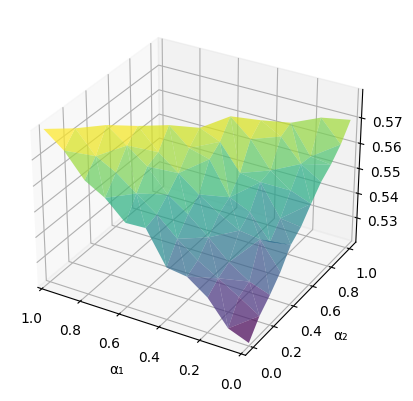

In [110]:
fig = plt.figure()
ax = plt.axes(projection ='3d')
surf = ax.plot_trisurf(X, Y, Z, linewidth=0.1, alpha=0.7, color='b', cmap='viridis')

ax.set_xlabel("α₁")
ax.set_ylabel("α₂")
ax.set_xlim([1,0])

plt.savefig('movielens_surface_surface.png', dpi=300)